<a href="https://colab.research.google.com/github/quanndm/kltn/blob/dev/notebooks/tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 2394, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 2394 (delta 16), reused 11 (delta 4), pack-reused 2365 (from 2)
Receiving objects: 100% (2394/2394), 25.55 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (1659/1659), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [3]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import gc

from kltn import *
from kltn.datasets.get_datasets import get_datasets_lits, convert_to_2D_dataset, get_datasets_lits_2d, get_liver_mask_bbox
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage2
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results_stage_2

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
LOGGER = init_logger(config["log_path"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.09% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
0.46% complete (down: 15704.5 kB/s up: 420.9 kB/s peers: 3) downloading LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
1.00% complete (down: 8465.6 kB/s up: 250.3 kB/s peers: 7) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (un

## Model

In [8]:
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_liver.pth"
model_stage_1 = ModelFactory.get_model("unet3d_resnextcot",in_channels=1, n_classes=1, n_channels=16).to(device)
model_stage_1.load_state_dict(torch.load(weight_path, map_location=device))

<All keys matched successfully>

In [6]:
model = ModelFactory.get_model("unet2d_resnextcot",in_channels=3, n_classes=1, n_channels=16).to(device)

## Prepare Dataset 2.5D

In [10]:
liver_masks_bbox = get_liver_mask_bbox(source=config["source_folder_lits"], model_stage_1=model_stage_1, device=device)

In [11]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"


patient_ids, bboxs = liver_masks_bbox
results = [
    {
        "patient_id": int(pid),
        "bbox": [int(x) for x in bbox]
    }
    for pid, bbox in zip(patient_ids, bboxs)
]
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

In [12]:
import json

path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"
def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

liver_masks_bbox = load_json(path_save_result)


In [13]:
convert_to_2D_dataset(source=config["source_folder_lits"], bbox=liver_masks_bbox, slides=3, save_dir=config["path_save_dataset_2D"])

Patient 43 processed.
Patient 14 processed.
Patient 76 processed.
Patient 22 processed.
Patient 105 processed.
Patient 62 processed.
Patient 107 processed.
Patient 116 processed.
Patient 123 processed.
Patient 103 processed.
Patient 92 processed.
Patient 10 processed.
Patient 31 processed.
Patient 93 processed.
Patient 8 processed.
Patient 15 processed.
Patient 74 processed.
Patient 89 processed.
Patient 65 processed.
Patient 35 processed.
Patient 19 processed.
Patient 129 processed.
Patient 128 processed.
Patient 66 processed.
Patient 91 processed.
Patient 102 processed.
Patient 40 processed.
Patient 80 processed.
Patient 7 processed.
Patient 73 processed.
Patient 18 processed.
Patient 79 processed.
Patient 48 processed.
Patient 12 processed.
Patient 104 processed.
Patient 122 processed.
Patient 112 processed.
Patient 45 processed.
Patient 110 processed.
Patient 52 processed.
Patient 114 processed.
Patient 55 processed.
Patient 111 processed.
Patient 27 processed.
Patient 125 processe

## Load data

In [7]:
# full_train_dataset, val_dataset = get_datasets_lits(source_folder=config["source_folder_lits"], seed=123, fold_number=3, mode="tumor", device=device, liver_masks_bbox=liver_masks_bbox)
full_train_dataset, val_dataset = get_datasets_lits_2d(source_folder=config["path_save_dataset_2D"], seed=123, fold_number=2)
print(len(full_train_dataset), len(val_dataset))

46701 11675


In [8]:
train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=1, shuffle=True,
                                           num_workers=1, pin_memory=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False,
                                         pin_memory=True, num_workers=1)

In [9]:
for batch in train_loader:
  image, seg = batch["image"], batch["label"]
  print(image.shape)
  print(seg.shape)

  break

torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])


## visualize

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch

def visualize_from_loader(image_tensor, label_tensor, liver_mask):
    """
    Hiển thị 3 ảnh: Volume, Liver Mask, và Liver Mask + Segmentation

    Args:
        image_tensor: Tensor, shape [1, 3, H, W]
        label_tensor: Tensor, shape [ 1, 1, H, W]
        liver_mask: Tensor, shape [1, 1, H, W]
    Notes:
        - Chuyển đổi sang numpy
        - Hiển thị 3 ảnh: volume, liver mask, và liver mask + segmentation
    """

    # Chuyển đổi sang numpy, nén tensor về dạng [D, H, W]
    image = image_tensor.detach().cpu().numpy().squeeze() # shape [3, H, W]
    label = label_tensor.detach().cpu().numpy().squeeze() # shape [ H, W]
    liver_mask = liver_mask.detach().cpu().numpy().squeeze() # shape [ H, W]


    image_center = image[1]

    # Bảng màu cho mask khối u
    cmap1 = mcolors.ListedColormap(["black", "red"])
    cmap2 = mcolors.ListedColormap(["black", "yellow"])

    # Vẽ hình
    plt.figure(figsize=(18, 6))

    # Ảnh đầu tiên: Volume (Ảnh gốc)
    plt.subplot(1, 3, 1)
    plt.title("Volume (slice center of 2.5D)")
    plt.imshow(image_center, cmap='gray')
    plt.axis("off")

    # Ảnh thứ ba: Liver Mask + Segmentation
    plt.subplot(1, 3, 2)
    plt.title("Liver Mask + Volume")
    plt.imshow(image_center, cmap='gray')
    plt.imshow(liver_mask, cmap=cmap2, alpha=0.5)
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Tumor Mask + Volume")
    plt.imshow(image_center, cmap='gray')
    plt.imshow(label, cmap=cmap1, alpha=0.5)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
i = 0
for train_data in train_loader:
    image = train_data["image"]
    label = train_data["label"]
    liver_mask = train_data["liver_mask"]
    # visualize_from_loader(image, label, liver_mask)

    if np.any(label.cpu().numpy().squeeze() > 0):
      i += 1
      visualize_from_loader(image, label, liver_mask)

      if i == 10:
        break
    else:
      continue



In [ ]:
i = 0
for val_data in val_loader:
    i+= 1

    image = val_data["image"]
    label = val_data["label"]
    liver_mask = val_data["liver_mask"]
    visualize_from_loader(image, label, liver_mask)

    if i == 10:
      break

## Training

In [ ]:
# criterion = DiceLossWSigmoid().to(device)
criterion = TverskyLossWSigmoid().to(device)

dice_acc = DiceMetric(include_background=False, reduction='mean_batch', get_not_nans=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=float(config["learning_rate_train"]), weight_decay=float(config["weight_decay"]))
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=int(config["max_epochs"]), eta_min = float(config["eta_min"]))

In [ ]:
LOGGER.info("[TRAINER] Start TRAIN process...")

(
    val_acc_max,
    best_epoch,
    dices_tumor,
    loss_epochs,
    trains_epoch,
    ious_tumor,
    precisions_tumor,
    recalls_tumor,
    time_tmp
) = trainer_stage2(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    loss_func=criterion,
    acc_func=dice_acc,
    scheduler=scheduler,
    batch_size=config["batch_size"],
    max_epochs = config["max_epochs"],
    start_epoch = config["start_epoch"],
    val_every=config["val_every"],
    path_save_model=config["path_save_model_state"],
    logger=LOGGER,
    save_model=True,
    post_fix="tumor_2d"
)

[TRAINER] Start TRAIN process...
INFO:kltn.utils.logger:[TRAINER] Start TRAIN process...

==============================Training epoch 1==============================
INFO:kltn.utils.logger:
==============================Training epoch 1==============================


Epoch 1/100 1/105 loss: 0.9273 time 3.71s
Epoch 1/100 2/105 loss: 0.9291 time 1.01s
Epoch 1/100 3/105 loss: 0.9263 time 2.36s
Epoch 1/100 4/105 loss: 0.9238 time 3.93s
Epoch 1/100 5/105 loss: 0.9215 time 3.86s
Epoch 1/100 6/105 loss: 0.9145 time 1.15s
Epoch 1/100 7/105 loss: 0.9139 time 7.25s
Epoch 1/100 8/105 loss: 0.9128 time 0.67s
Epoch 1/100 9/105 loss: 0.9107 time 8.71s
Epoch 1/100 10/105 loss: 0.9032 time 3.14s
Epoch 1/100 11/105 loss: 0.9016 time 0.65s
Epoch 1/100 12/105 loss: 0.9002 time 3.66s
Epoch 1/100 13/105 loss: 0.8987 time 4.20s
Epoch 1/100 14/105 loss: 0.8936 time 3.05s
Epoch 1/100 15/105 loss: 0.8935 time 10.69s
Epoch 1/100 16/105 loss: 0.8932 time 3.40s
Epoch 1/100 17/105 loss: 0.8928 time 1.91s
Epoch 1/100 18/105 loss: 0.8923 time 2.76s
Epoch 1/100 19/105 loss: 0.8920 time 7.90s
Epoch 1/100 20/105 loss: 0.8914 time 3.20s
Epoch 1/100 21/105 loss: 0.8901 time 0.65s
Epoch 1/100 22/105 loss: 0.8897 time 3.89s
Epoch 1/100 23/105 loss: 0.8892 time 3.54s
Epoch 1/100 24/105 

Final training epochs: 1/100 ---[loss: 0.8464] ---[time 356.55s]
INFO:kltn.utils.logger:Final training epochs: 1/100 ---[loss: 0.8464] ---[time 356.55s]

********************Epoch 1 Validation********************
INFO:kltn.utils.logger:
********************Epoch 1 Validation********************


Epoch 1/100 105/105 loss: 0.8464 time 2.19s


Val 1/100 1/26, Dice_Tumor: 0.311495, time 2.82s
INFO:kltn.utils.logger:Val 1/100 1/26, Dice_Tumor: 0.311495, time 2.82s
Val 1/100 2/26, Dice_Tumor: 0.251875, time 1.00s
INFO:kltn.utils.logger:Val 1/100 2/26, Dice_Tumor: 0.251875, time 1.00s
Val 1/100 3/26, Dice_Tumor: 0.068084, time 5.22s
INFO:kltn.utils.logger:Val 1/100 3/26, Dice_Tumor: 0.068084, time 5.22s
Val 1/100 4/26, Dice_Tumor: 0.000000, time 4.23s
INFO:kltn.utils.logger:Val 1/100 4/26, Dice_Tumor: 0.000000, time 4.23s
Val 1/100 5/26, Dice_Tumor: 0.000000, time 4.28s
INFO:kltn.utils.logger:Val 1/100 5/26, Dice_Tumor: 0.000000, time 4.28s
Val 1/100 6/26, Dice_Tumor: 0.541111, time 4.48s
INFO:kltn.utils.logger:Val 1/100 6/26, Dice_Tumor: 0.541111, time 4.48s
Val 1/100 7/26, Dice_Tumor: 0.000000, time 1.20s
INFO:kltn.utils.logger:Val 1/100 7/26, Dice_Tumor: 0.000000, time 1.20s
Val 1/100 8/26, Dice_Tumor: 0.000000, time 4.28s
INFO:kltn.utils.logger:Val 1/100 8/26, Dice_Tumor: 0.000000, time 4.28s
Val 1/100 9/26, Dice_Tumor: 0.00

New best (0.000000 --> 0.085656). At epoch 1
Epoch 2/100 1/105 loss: 0.8149 time 4.96s
Epoch 2/100 2/105 loss: 0.8138 time 6.62s
Epoch 2/100 3/105 loss: 0.8124 time 5.04s
Epoch 2/100 4/105 loss: 0.8114 time 5.75s
Epoch 2/100 5/105 loss: 0.8107 time 1.11s
Epoch 2/100 6/105 loss: 0.8106 time 3.88s
Epoch 2/100 7/105 loss: 0.8105 time 4.14s
Epoch 2/100 8/105 loss: 0.8103 time 10.61s
Epoch 2/100 9/105 loss: 0.8082 time 1.50s
Epoch 2/100 10/105 loss: 0.8080 time 0.73s
Epoch 2/100 11/105 loss: 0.8075 time 4.08s
Epoch 2/100 12/105 loss: 0.8072 time 0.87s
Epoch 2/100 13/105 loss: 0.8068 time 2.27s
Epoch 2/100 14/105 loss: 0.8065 time 4.43s
Epoch 2/100 15/105 loss: 0.8058 time 2.75s
Epoch 2/100 16/105 loss: 0.8055 time 6.87s
Epoch 2/100 17/105 loss: 0.8052 time 2.04s
Epoch 2/100 18/105 loss: 0.8048 time 4.27s
Epoch 2/100 19/105 loss: 0.8049 time 3.89s
Epoch 2/100 20/105 loss: 0.8011 time 7.49s
Epoch 2/100 21/105 loss: 0.8010 time 1.76s
Epoch 2/100 22/105 loss: 0.8009 time 4.36s
Epoch 2/100 23/10

Final training epochs: 2/100 ---[loss: 0.7806] ---[time 367.14s]
INFO:kltn.utils.logger:Final training epochs: 2/100 ---[loss: 0.7806] ---[time 367.14s]

********************Epoch 2 Validation********************
INFO:kltn.utils.logger:
********************Epoch 2 Validation********************


Epoch 2/100 105/105 loss: 0.7806 time 1.46s


Val 2/100 1/26, Dice_Tumor: 0.278795, time 2.38s
INFO:kltn.utils.logger:Val 2/100 1/26, Dice_Tumor: 0.278795, time 2.38s
Val 2/100 2/26, Dice_Tumor: 0.439350, time 1.93s
INFO:kltn.utils.logger:Val 2/100 2/26, Dice_Tumor: 0.439350, time 1.93s
Val 2/100 3/26, Dice_Tumor: 0.188928, time 4.80s
INFO:kltn.utils.logger:Val 2/100 3/26, Dice_Tumor: 0.188928, time 4.80s
Val 2/100 4/26, Dice_Tumor: 0.000000, time 4.40s
INFO:kltn.utils.logger:Val 2/100 4/26, Dice_Tumor: 0.000000, time 4.40s
Val 2/100 5/26, Dice_Tumor: 0.000000, time 4.95s
INFO:kltn.utils.logger:Val 2/100 5/26, Dice_Tumor: 0.000000, time 4.95s
Val 2/100 6/26, Dice_Tumor: 0.728565, time 3.80s
INFO:kltn.utils.logger:Val 2/100 6/26, Dice_Tumor: 0.728565, time 3.80s
Val 2/100 7/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 2/100 7/26, Dice_Tumor: 0.000000, time 1.05s
Val 2/100 8/26, Dice_Tumor: 0.000000, time 4.55s
INFO:kltn.utils.logger:Val 2/100 8/26, Dice_Tumor: 0.000000, time 4.55s
Val 2/100 9/26, Dice_Tumor: 0.00

New best (0.085656 --> 0.108205). At epoch 2
Epoch 3/100 1/105 loss: 0.7715 time 3.77s
Epoch 3/100 2/105 loss: 0.7712 time 5.27s
Epoch 3/100 3/105 loss: 0.7709 time 5.41s
Epoch 3/100 4/105 loss: 0.7715 time 0.87s
Epoch 3/100 5/105 loss: 0.7704 time 3.86s
Epoch 3/100 6/105 loss: 0.7699 time 3.84s
Epoch 3/100 7/105 loss: 0.7655 time 4.40s
Epoch 3/100 8/105 loss: 0.7661 time 4.99s
Epoch 3/100 9/105 loss: 0.7664 time 1.00s
Epoch 3/100 10/105 loss: 0.7667 time 2.90s
Epoch 3/100 11/105 loss: 0.7654 time 1.86s
Epoch 3/100 12/105 loss: 0.7658 time 1.19s
Epoch 3/100 13/105 loss: 0.7638 time 4.18s
Epoch 3/100 14/105 loss: 0.7638 time 3.54s
Epoch 3/100 15/105 loss: 0.7642 time 9.78s
Epoch 3/100 16/105 loss: 0.7647 time 4.32s
Epoch 3/100 17/105 loss: 0.7649 time 1.29s
Epoch 3/100 18/105 loss: 0.7652 time 3.41s
Epoch 3/100 19/105 loss: 0.7646 time 11.95s
Epoch 3/100 20/105 loss: 0.7647 time 3.61s
Epoch 3/100 21/105 loss: 0.7649 time 0.93s
Epoch 3/100 22/105 loss: 0.7647 time 5.02s
Epoch 3/100 23/10

Final training epochs: 3/100 ---[loss: 0.7524] ---[time 364.40s]
INFO:kltn.utils.logger:Final training epochs: 3/100 ---[loss: 0.7524] ---[time 364.40s]

********************Epoch 3 Validation********************
INFO:kltn.utils.logger:
********************Epoch 3 Validation********************


Epoch 3/100 105/105 loss: 0.7524 time 4.24s


Val 3/100 1/26, Dice_Tumor: 0.382843, time 2.25s
INFO:kltn.utils.logger:Val 3/100 1/26, Dice_Tumor: 0.382843, time 2.25s
Val 3/100 2/26, Dice_Tumor: 0.397640, time 1.34s
INFO:kltn.utils.logger:Val 3/100 2/26, Dice_Tumor: 0.397640, time 1.34s
Val 3/100 3/26, Dice_Tumor: 0.422094, time 4.80s
INFO:kltn.utils.logger:Val 3/100 3/26, Dice_Tumor: 0.422094, time 4.80s
Val 3/100 4/26, Dice_Tumor: 0.000000, time 4.91s
INFO:kltn.utils.logger:Val 3/100 4/26, Dice_Tumor: 0.000000, time 4.91s
Val 3/100 5/26, Dice_Tumor: 0.044435, time 3.96s
INFO:kltn.utils.logger:Val 3/100 5/26, Dice_Tumor: 0.044435, time 3.96s
Val 3/100 6/26, Dice_Tumor: 0.809240, time 4.07s
INFO:kltn.utils.logger:Val 3/100 6/26, Dice_Tumor: 0.809240, time 4.07s
Val 3/100 7/26, Dice_Tumor: 0.000000, time 0.94s
INFO:kltn.utils.logger:Val 3/100 7/26, Dice_Tumor: 0.000000, time 0.94s
Val 3/100 8/26, Dice_Tumor: 0.000000, time 5.01s
INFO:kltn.utils.logger:Val 3/100 8/26, Dice_Tumor: 0.000000, time 5.01s
Val 3/100 9/26, Dice_Tumor: 0.00

New best (0.108205 --> 0.181252). At epoch 3
Epoch 4/100 1/105 loss: 0.7590 time 3.53s
Epoch 4/100 2/105 loss: 0.7581 time 1.19s
Epoch 4/100 3/105 loss: 0.7563 time 4.48s
Epoch 4/100 4/105 loss: 0.7567 time 2.48s
Epoch 4/100 5/105 loss: 0.7565 time 5.61s
Epoch 4/100 6/105 loss: 0.7536 time 0.78s
Epoch 4/100 7/105 loss: 0.7540 time 4.30s
Epoch 4/100 8/105 loss: 0.7546 time 0.87s
Epoch 4/100 9/105 loss: 0.7548 time 2.66s
Epoch 4/100 10/105 loss: 0.7550 time 0.98s
Epoch 4/100 11/105 loss: 0.7551 time 4.30s
Epoch 4/100 12/105 loss: 0.7519 time 4.03s
Epoch 4/100 13/105 loss: 0.7520 time 7.07s
Epoch 4/100 14/105 loss: 0.7523 time 0.65s
Epoch 4/100 15/105 loss: 0.7524 time 6.53s
Epoch 4/100 16/105 loss: 0.7525 time 1.08s
Epoch 4/100 17/105 loss: 0.7526 time 5.08s
Epoch 4/100 18/105 loss: 0.7526 time 0.97s
Epoch 4/100 19/105 loss: 0.7526 time 10.65s
Epoch 4/100 20/105 loss: 0.7501 time 7.01s
Epoch 4/100 21/105 loss: 0.7502 time 4.34s
Epoch 4/100 22/105 loss: 0.7477 time 1.57s
Epoch 4/100 23/10

Final training epochs: 4/100 ---[loss: 0.7354] ---[time 361.63s]
INFO:kltn.utils.logger:Final training epochs: 4/100 ---[loss: 0.7354] ---[time 361.63s]

********************Epoch 4 Validation********************
INFO:kltn.utils.logger:
********************Epoch 4 Validation********************


Epoch 4/100 105/105 loss: 0.7354 time 4.04s


Val 4/100 1/26, Dice_Tumor: 0.336594, time 2.23s
INFO:kltn.utils.logger:Val 4/100 1/26, Dice_Tumor: 0.336594, time 2.23s
Val 4/100 2/26, Dice_Tumor: 0.446124, time 1.44s
INFO:kltn.utils.logger:Val 4/100 2/26, Dice_Tumor: 0.446124, time 1.44s
Val 4/100 3/26, Dice_Tumor: 0.312787, time 4.91s
INFO:kltn.utils.logger:Val 4/100 3/26, Dice_Tumor: 0.312787, time 4.91s
Val 4/100 4/26, Dice_Tumor: 0.000284, time 4.79s
INFO:kltn.utils.logger:Val 4/100 4/26, Dice_Tumor: 0.000284, time 4.79s
Val 4/100 5/26, Dice_Tumor: 0.043564, time 4.01s
INFO:kltn.utils.logger:Val 4/100 5/26, Dice_Tumor: 0.043564, time 4.01s
Val 4/100 6/26, Dice_Tumor: 0.483056, time 3.99s
INFO:kltn.utils.logger:Val 4/100 6/26, Dice_Tumor: 0.483056, time 3.99s
Val 4/100 7/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 4/100 7/26, Dice_Tumor: 0.000000, time 1.01s
Val 4/100 8/26, Dice_Tumor: 0.000000, time 4.93s
INFO:kltn.utils.logger:Val 4/100 8/26, Dice_Tumor: 0.000000, time 4.93s
Val 4/100 9/26, Dice_Tumor: 0.00

Epoch 5/100 1/105 loss: 0.7458 time 2.06s
Epoch 5/100 2/105 loss: 0.7449 time 1.35s
Epoch 5/100 3/105 loss: 0.7448 time 5.10s
Epoch 5/100 4/105 loss: 0.7466 time 0.83s
Epoch 5/100 5/105 loss: 0.7427 time 3.12s
Epoch 5/100 6/105 loss: 0.7430 time 1.16s
Epoch 5/100 7/105 loss: 0.7437 time 4.26s
Epoch 5/100 8/105 loss: 0.7438 time 3.51s
Epoch 5/100 9/105 loss: 0.7341 time 6.08s
Epoch 5/100 10/105 loss: 0.7352 time 0.65s
Epoch 5/100 11/105 loss: 0.7360 time 4.27s
Epoch 5/100 12/105 loss: 0.7363 time 2.96s
Epoch 5/100 13/105 loss: 0.7352 time 0.79s
Epoch 5/100 14/105 loss: 0.7358 time 3.13s
Epoch 5/100 15/105 loss: 0.7362 time 5.96s
Epoch 5/100 16/105 loss: 0.7338 time 3.66s
Epoch 5/100 17/105 loss: 0.7341 time 0.82s
Epoch 5/100 18/105 loss: 0.7344 time 4.48s
Epoch 5/100 19/105 loss: 0.7337 time 1.74s
Epoch 5/100 20/105 loss: 0.7342 time 1.88s
Epoch 5/100 21/105 loss: 0.7344 time 2.13s
Epoch 5/100 22/105 loss: 0.7328 time 4.25s
Epoch 5/100 23/105 loss: 0.7335 time 4.47s
Epoch 5/100 24/105 l

Final training epochs: 5/100 ---[loss: 0.7226] ---[time 362.29s]
INFO:kltn.utils.logger:Final training epochs: 5/100 ---[loss: 0.7226] ---[time 362.29s]

********************Epoch 5 Validation********************
INFO:kltn.utils.logger:
********************Epoch 5 Validation********************


Epoch 5/100 105/105 loss: 0.7226 time 1.26s


Val 5/100 1/26, Dice_Tumor: 0.443576, time 2.46s
INFO:kltn.utils.logger:Val 5/100 1/26, Dice_Tumor: 0.443576, time 2.46s
Val 5/100 2/26, Dice_Tumor: 0.380369, time 1.43s
INFO:kltn.utils.logger:Val 5/100 2/26, Dice_Tumor: 0.380369, time 1.43s
Val 5/100 3/26, Dice_Tumor: 0.560097, time 4.81s
INFO:kltn.utils.logger:Val 5/100 3/26, Dice_Tumor: 0.560097, time 4.81s
Val 5/100 4/26, Dice_Tumor: 0.000320, time 4.83s
INFO:kltn.utils.logger:Val 5/100 4/26, Dice_Tumor: 0.000320, time 4.83s
Val 5/100 5/26, Dice_Tumor: 0.127638, time 4.03s
INFO:kltn.utils.logger:Val 5/100 5/26, Dice_Tumor: 0.127638, time 4.03s
Val 5/100 6/26, Dice_Tumor: 0.807697, time 4.06s
INFO:kltn.utils.logger:Val 5/100 6/26, Dice_Tumor: 0.807697, time 4.06s
Val 5/100 7/26, Dice_Tumor: 0.000000, time 1.08s
INFO:kltn.utils.logger:Val 5/100 7/26, Dice_Tumor: 0.000000, time 1.08s
Val 5/100 8/26, Dice_Tumor: 0.000000, time 5.20s
INFO:kltn.utils.logger:Val 5/100 8/26, Dice_Tumor: 0.000000, time 5.20s
Val 5/100 9/26, Dice_Tumor: 0.00

New best (0.181252 --> 0.226842). At epoch 5
Epoch 6/100 1/105 loss: 0.7106 time 1.62s
Epoch 6/100 2/105 loss: 0.6923 time 6.11s
Epoch 6/100 3/105 loss: 0.6915 time 9.31s
Epoch 6/100 4/105 loss: 0.7019 time 3.07s
Epoch 6/100 5/105 loss: 0.6881 time 6.19s
Epoch 6/100 6/105 loss: 0.6969 time 4.88s
Epoch 6/100 7/105 loss: 0.7044 time 4.36s
Epoch 6/100 8/105 loss: 0.7089 time 3.20s
Epoch 6/100 9/105 loss: 0.7126 time 0.91s
Epoch 6/100 10/105 loss: 0.6942 time 7.65s
Epoch 6/100 11/105 loss: 0.6975 time 2.45s
Epoch 6/100 12/105 loss: 0.7008 time 6.39s
Epoch 6/100 13/105 loss: 0.7039 time 1.07s
Epoch 6/100 14/105 loss: 0.7065 time 4.98s
Epoch 6/100 15/105 loss: 0.7083 time 0.75s
Epoch 6/100 16/105 loss: 0.7025 time 3.92s
Epoch 6/100 17/105 loss: 0.7045 time 0.91s
Epoch 6/100 18/105 loss: 0.7061 time 1.01s
Epoch 6/100 19/105 loss: 0.7077 time 1.74s
Epoch 6/100 20/105 loss: 0.7051 time 1.67s
Epoch 6/100 21/105 loss: 0.7031 time 4.70s
Epoch 6/100 22/105 loss: 0.7039 time 4.32s
Epoch 6/100 23/105

Final training epochs: 6/100 ---[loss: 0.7096] ---[time 370.86s]
INFO:kltn.utils.logger:Final training epochs: 6/100 ---[loss: 0.7096] ---[time 370.86s]

********************Epoch 6 Validation********************
INFO:kltn.utils.logger:
********************Epoch 6 Validation********************


Epoch 6/100 105/105 loss: 0.7096 time 3.54s


Val 6/100 1/26, Dice_Tumor: 0.389585, time 2.18s
INFO:kltn.utils.logger:Val 6/100 1/26, Dice_Tumor: 0.389585, time 2.18s
Val 6/100 2/26, Dice_Tumor: 0.427768, time 1.81s
INFO:kltn.utils.logger:Val 6/100 2/26, Dice_Tumor: 0.427768, time 1.81s
Val 6/100 3/26, Dice_Tumor: 0.470688, time 4.69s
INFO:kltn.utils.logger:Val 6/100 3/26, Dice_Tumor: 0.470688, time 4.69s
Val 6/100 4/26, Dice_Tumor: 0.000000, time 4.23s
INFO:kltn.utils.logger:Val 6/100 4/26, Dice_Tumor: 0.000000, time 4.23s
Val 6/100 5/26, Dice_Tumor: 0.118055, time 4.82s
INFO:kltn.utils.logger:Val 6/100 5/26, Dice_Tumor: 0.118055, time 4.82s
Val 6/100 6/26, Dice_Tumor: 0.693627, time 3.72s
INFO:kltn.utils.logger:Val 6/100 6/26, Dice_Tumor: 0.693627, time 3.72s
Val 6/100 7/26, Dice_Tumor: 0.000000, time 0.99s
INFO:kltn.utils.logger:Val 6/100 7/26, Dice_Tumor: 0.000000, time 0.99s
Val 6/100 8/26, Dice_Tumor: 0.000000, time 4.50s
INFO:kltn.utils.logger:Val 6/100 8/26, Dice_Tumor: 0.000000, time 4.50s
Val 6/100 9/26, Dice_Tumor: 0.00

New best (0.226842 --> 0.227809). At epoch 6
Epoch 7/100 1/105 loss: 0.7319 time 5.36s
Epoch 7/100 2/105 loss: 0.7304 time 2.23s
Epoch 7/100 3/105 loss: 0.7129 time 6.36s
Epoch 7/100 4/105 loss: 0.7181 time 2.21s
Epoch 7/100 5/105 loss: 0.6943 time 1.58s
Epoch 7/100 6/105 loss: 0.6996 time 2.79s
Epoch 7/100 7/105 loss: 0.7038 time 5.53s
Epoch 7/100 8/105 loss: 0.7074 time 4.22s
Epoch 7/100 9/105 loss: 0.7092 time 1.60s
Epoch 7/100 10/105 loss: 0.7122 time 4.51s
Epoch 7/100 11/105 loss: 0.7129 time 2.07s
Epoch 7/100 12/105 loss: 0.6932 time 5.04s
Epoch 7/100 13/105 loss: 0.6880 time 4.24s
Epoch 7/100 14/105 loss: 0.6830 time 5.18s
Epoch 7/100 15/105 loss: 0.6703 time 2.24s
Epoch 7/100 16/105 loss: 0.6738 time 1.98s
Epoch 7/100 17/105 loss: 0.6773 time 3.50s
Epoch 7/100 18/105 loss: 0.6807 time 0.66s
Epoch 7/100 19/105 loss: 0.6835 time 11.90s
Epoch 7/100 20/105 loss: 0.6859 time 3.12s
Epoch 7/100 21/105 loss: 0.6883 time 3.15s
Epoch 7/100 22/105 loss: 0.6896 time 2.05s
Epoch 7/100 23/10

Final training epochs: 7/100 ---[loss: 0.6980] ---[time 367.16s]
INFO:kltn.utils.logger:Final training epochs: 7/100 ---[loss: 0.6980] ---[time 367.16s]

********************Epoch 7 Validation********************
INFO:kltn.utils.logger:
********************Epoch 7 Validation********************


Epoch 7/100 105/105 loss: 0.6980 time 7.69s


Val 7/100 1/26, Dice_Tumor: 0.311821, time 2.47s
INFO:kltn.utils.logger:Val 7/100 1/26, Dice_Tumor: 0.311821, time 2.47s
Val 7/100 2/26, Dice_Tumor: 0.329162, time 1.29s
INFO:kltn.utils.logger:Val 7/100 2/26, Dice_Tumor: 0.329162, time 1.29s
Val 7/100 3/26, Dice_Tumor: 0.332109, time 4.84s
INFO:kltn.utils.logger:Val 7/100 3/26, Dice_Tumor: 0.332109, time 4.84s
Val 7/100 4/26, Dice_Tumor: 0.009162, time 4.66s
INFO:kltn.utils.logger:Val 7/100 4/26, Dice_Tumor: 0.009162, time 4.66s
Val 7/100 5/26, Dice_Tumor: 0.415955, time 4.02s
INFO:kltn.utils.logger:Val 7/100 5/26, Dice_Tumor: 0.415955, time 4.02s
Val 7/100 6/26, Dice_Tumor: 0.719981, time 3.98s
INFO:kltn.utils.logger:Val 7/100 6/26, Dice_Tumor: 0.719981, time 3.98s
Val 7/100 7/26, Dice_Tumor: 0.004619, time 0.99s
INFO:kltn.utils.logger:Val 7/100 7/26, Dice_Tumor: 0.004619, time 0.99s
Val 7/100 8/26, Dice_Tumor: 0.000000, time 5.21s
INFO:kltn.utils.logger:Val 7/100 8/26, Dice_Tumor: 0.000000, time 5.21s
Val 7/100 9/26, Dice_Tumor: 0.00

Epoch 8/100 1/105 loss: 0.5965 time 3.37s
Epoch 8/100 2/105 loss: 0.6616 time 2.44s
Epoch 8/100 3/105 loss: 0.6830 time 1.02s
Epoch 8/100 4/105 loss: 0.6918 time 1.80s
Epoch 8/100 5/105 loss: 0.6800 time 0.75s
Epoch 8/100 6/105 loss: 0.6839 time 4.62s
Epoch 8/100 7/105 loss: 0.6834 time 5.85s
Epoch 8/100 8/105 loss: 0.6901 time 3.54s
Epoch 8/100 9/105 loss: 0.6853 time 4.24s
Epoch 8/100 10/105 loss: 0.6722 time 0.73s
Epoch 8/100 11/105 loss: 0.6769 time 1.73s
Epoch 8/100 12/105 loss: 0.6809 time 5.90s
Epoch 8/100 13/105 loss: 0.6777 time 1.50s
Epoch 8/100 14/105 loss: 0.6792 time 3.85s
Epoch 8/100 15/105 loss: 0.6778 time 8.09s
Epoch 8/100 16/105 loss: 0.6800 time 1.89s
Epoch 8/100 17/105 loss: 0.6803 time 4.04s
Epoch 8/100 18/105 loss: 0.6830 time 3.86s
Epoch 8/100 19/105 loss: 0.6852 time 3.37s
Epoch 8/100 20/105 loss: 0.6850 time 5.57s
Epoch 8/100 21/105 loss: 0.6757 time 2.03s
Epoch 8/100 22/105 loss: 0.6779 time 1.84s
Epoch 8/100 23/105 loss: 0.6791 time 3.14s
Epoch 8/100 24/105 l

Final training epochs: 8/100 ---[loss: 0.6887] ---[time 368.14s]
INFO:kltn.utils.logger:Final training epochs: 8/100 ---[loss: 0.6887] ---[time 368.14s]

********************Epoch 8 Validation********************
INFO:kltn.utils.logger:
********************Epoch 8 Validation********************


Epoch 8/100 105/105 loss: 0.6887 time 4.69s


Val 8/100 1/26, Dice_Tumor: 0.368754, time 2.09s
INFO:kltn.utils.logger:Val 8/100 1/26, Dice_Tumor: 0.368754, time 2.09s
Val 8/100 2/26, Dice_Tumor: 0.347601, time 1.45s
INFO:kltn.utils.logger:Val 8/100 2/26, Dice_Tumor: 0.347601, time 1.45s
Val 8/100 3/26, Dice_Tumor: 0.578535, time 5.38s
INFO:kltn.utils.logger:Val 8/100 3/26, Dice_Tumor: 0.578535, time 5.38s
Val 8/100 4/26, Dice_Tumor: 0.010928, time 4.13s
INFO:kltn.utils.logger:Val 8/100 4/26, Dice_Tumor: 0.010928, time 4.13s
Val 8/100 5/26, Dice_Tumor: 0.176375, time 4.18s
INFO:kltn.utils.logger:Val 8/100 5/26, Dice_Tumor: 0.176375, time 4.18s
Val 8/100 6/26, Dice_Tumor: 0.635013, time 4.48s
INFO:kltn.utils.logger:Val 8/100 6/26, Dice_Tumor: 0.635013, time 4.48s
Val 8/100 7/26, Dice_Tumor: 0.004694, time 0.93s
INFO:kltn.utils.logger:Val 8/100 7/26, Dice_Tumor: 0.004694, time 0.93s
Val 8/100 8/26, Dice_Tumor: 0.000000, time 4.49s
INFO:kltn.utils.logger:Val 8/100 8/26, Dice_Tumor: 0.000000, time 4.49s
Val 8/100 9/26, Dice_Tumor: 0.00

Epoch 9/100 1/105 loss: 0.5276 time 4.89s
Epoch 9/100 2/105 loss: 0.6240 time 5.06s
Epoch 9/100 3/105 loss: 0.6592 time 4.24s
Epoch 9/100 4/105 loss: 0.6722 time 0.99s
Epoch 9/100 5/105 loss: 0.6835 time 1.32s
Epoch 9/100 6/105 loss: 0.6917 time 4.73s
Epoch 9/100 7/105 loss: 0.6961 time 2.99s
Epoch 9/100 8/105 loss: 0.6991 time 0.66s
Epoch 9/100 9/105 loss: 0.7004 time 2.04s
Epoch 9/100 10/105 loss: 0.7019 time 1.55s
Epoch 9/100 11/105 loss: 0.7035 time 4.87s
Epoch 9/100 12/105 loss: 0.7046 time 0.73s
Epoch 9/100 13/105 loss: 0.7058 time 2.37s
Epoch 9/100 14/105 loss: 0.7068 time 3.74s
Epoch 9/100 15/105 loss: 0.7056 time 3.60s
Epoch 9/100 16/105 loss: 0.6992 time 5.14s
Epoch 9/100 17/105 loss: 0.6990 time 3.88s
Epoch 9/100 18/105 loss: 0.7001 time 2.53s
Epoch 9/100 19/105 loss: 0.7010 time 3.51s
Epoch 9/100 20/105 loss: 0.7019 time 1.90s
Epoch 9/100 21/105 loss: 0.6972 time 1.66s
Epoch 9/100 22/105 loss: 0.6982 time 0.84s
Epoch 9/100 23/105 loss: 0.6991 time 5.64s
Epoch 9/100 24/105 l

Final training epochs: 9/100 ---[loss: 0.6715] ---[time 363.15s]
INFO:kltn.utils.logger:Final training epochs: 9/100 ---[loss: 0.6715] ---[time 363.15s]

********************Epoch 9 Validation********************
INFO:kltn.utils.logger:
********************Epoch 9 Validation********************


Epoch 9/100 105/105 loss: 0.6715 time 5.14s


Val 9/100 1/26, Dice_Tumor: 0.548891, time 2.20s
INFO:kltn.utils.logger:Val 9/100 1/26, Dice_Tumor: 0.548891, time 2.20s
Val 9/100 2/26, Dice_Tumor: 0.611910, time 1.32s
INFO:kltn.utils.logger:Val 9/100 2/26, Dice_Tumor: 0.611910, time 1.32s
Val 9/100 3/26, Dice_Tumor: 0.319230, time 5.44s
INFO:kltn.utils.logger:Val 9/100 3/26, Dice_Tumor: 0.319230, time 5.44s
Val 9/100 4/26, Dice_Tumor: 0.000000, time 4.17s
INFO:kltn.utils.logger:Val 9/100 4/26, Dice_Tumor: 0.000000, time 4.17s
Val 9/100 5/26, Dice_Tumor: 0.073853, time 4.21s
INFO:kltn.utils.logger:Val 9/100 5/26, Dice_Tumor: 0.073853, time 4.21s
Val 9/100 6/26, Dice_Tumor: 0.784012, time 4.64s
INFO:kltn.utils.logger:Val 9/100 6/26, Dice_Tumor: 0.784012, time 4.64s
Val 9/100 7/26, Dice_Tumor: 0.000000, time 0.79s
INFO:kltn.utils.logger:Val 9/100 7/26, Dice_Tumor: 0.000000, time 0.79s
Val 9/100 8/26, Dice_Tumor: 0.000000, time 4.47s
INFO:kltn.utils.logger:Val 9/100 8/26, Dice_Tumor: 0.000000, time 4.47s
Val 9/100 9/26, Dice_Tumor: 0.00

New best (0.227809 --> 0.243891). At epoch 9
Epoch 10/100 1/105 loss: 0.6830 time 4.51s
Epoch 10/100 2/105 loss: 0.6426 time 4.53s
Epoch 10/100 3/105 loss: 0.6660 time 2.70s
Epoch 10/100 4/105 loss: 0.6810 time 1.47s
Epoch 10/100 5/105 loss: 0.6864 time 6.14s
Epoch 10/100 6/105 loss: 0.6910 time 3.68s
Epoch 10/100 7/105 loss: 0.6687 time 6.94s
Epoch 10/100 8/105 loss: 0.6746 time 6.90s
Epoch 10/100 9/105 loss: 0.6790 time 0.93s
Epoch 10/100 10/105 loss: 0.6831 time 5.16s
Epoch 10/100 11/105 loss: 0.6860 time 5.48s
Epoch 10/100 12/105 loss: 0.6884 time 4.20s
Epoch 10/100 13/105 loss: 0.6630 time 6.24s
Epoch 10/100 14/105 loss: 0.6607 time 0.93s
Epoch 10/100 15/105 loss: 0.6638 time 7.03s
Epoch 10/100 16/105 loss: 0.6673 time 3.43s
Epoch 10/100 17/105 loss: 0.6706 time 3.46s
Epoch 10/100 18/105 loss: 0.6721 time 1.22s
Epoch 10/100 19/105 loss: 0.6746 time 5.77s
Epoch 10/100 20/105 loss: 0.6771 time 3.81s
Epoch 10/100 21/105 loss: 0.6790 time 2.34s
Epoch 10/100 22/105 loss: 0.6794 time 1.

Final training epochs: 10/100 ---[loss: 0.6567] ---[time 370.51s]
INFO:kltn.utils.logger:Final training epochs: 10/100 ---[loss: 0.6567] ---[time 370.51s]

********************Epoch 10 Validation********************
INFO:kltn.utils.logger:
********************Epoch 10 Validation********************


Epoch 10/100 105/105 loss: 0.6567 time 2.23s


Val 10/100 1/26, Dice_Tumor: 0.338302, time 2.28s
INFO:kltn.utils.logger:Val 10/100 1/26, Dice_Tumor: 0.338302, time 2.28s
Val 10/100 2/26, Dice_Tumor: 0.543294, time 1.32s
INFO:kltn.utils.logger:Val 10/100 2/26, Dice_Tumor: 0.543294, time 1.32s
Val 10/100 3/26, Dice_Tumor: 0.276155, time 4.88s
INFO:kltn.utils.logger:Val 10/100 3/26, Dice_Tumor: 0.276155, time 4.88s
Val 10/100 4/26, Dice_Tumor: 0.000000, time 4.90s
INFO:kltn.utils.logger:Val 10/100 4/26, Dice_Tumor: 0.000000, time 4.90s
Val 10/100 5/26, Dice_Tumor: 0.395471, time 4.08s
INFO:kltn.utils.logger:Val 10/100 5/26, Dice_Tumor: 0.395471, time 4.08s
Val 10/100 6/26, Dice_Tumor: 0.698418, time 4.07s
INFO:kltn.utils.logger:Val 10/100 6/26, Dice_Tumor: 0.698418, time 4.07s
Val 10/100 7/26, Dice_Tumor: 0.033789, time 1.03s
INFO:kltn.utils.logger:Val 10/100 7/26, Dice_Tumor: 0.033789, time 1.03s
Val 10/100 8/26, Dice_Tumor: 0.000000, time 4.80s
INFO:kltn.utils.logger:Val 10/100 8/26, Dice_Tumor: 0.000000, time 4.80s
Val 10/100 9/26,

New best (0.243891 --> 0.273663). At epoch 10
Epoch 11/100 1/105 loss: 0.4226 time 2.05s
Epoch 11/100 2/105 loss: 0.5658 time 1.80s
Epoch 11/100 3/105 loss: 0.5146 time 2.49s
Epoch 11/100 4/105 loss: 0.5641 time 4.37s
Epoch 11/100 5/105 loss: 0.5944 time 4.37s
Epoch 11/100 6/105 loss: 0.6140 time 4.05s
Epoch 11/100 7/105 loss: 0.6289 time 4.65s
Epoch 11/100 8/105 loss: 0.6370 time 2.66s
Epoch 11/100 9/105 loss: 0.6453 time 4.30s
Epoch 11/100 10/105 loss: 0.6520 time 5.49s
Epoch 11/100 11/105 loss: 0.6510 time 3.69s
Epoch 11/100 12/105 loss: 0.6516 time 4.40s
Epoch 11/100 13/105 loss: 0.6547 time 0.72s
Epoch 11/100 14/105 loss: 0.6589 time 4.45s
Epoch 11/100 15/105 loss: 0.6623 time 1.06s
Epoch 11/100 16/105 loss: 0.6655 time 5.33s
Epoch 11/100 17/105 loss: 0.6530 time 5.90s
Epoch 11/100 18/105 loss: 0.6568 time 4.77s
Epoch 11/100 19/105 loss: 0.6600 time 3.90s
Epoch 11/100 20/105 loss: 0.6508 time 6.82s
Epoch 11/100 21/105 loss: 0.6498 time 3.58s
Epoch 11/100 22/105 loss: 0.6473 time 3

Final training epochs: 11/100 ---[loss: 0.6446] ---[time 368.26s]
INFO:kltn.utils.logger:Final training epochs: 11/100 ---[loss: 0.6446] ---[time 368.26s]

********************Epoch 11 Validation********************
INFO:kltn.utils.logger:
********************Epoch 11 Validation********************


Epoch 11/100 105/105 loss: 0.6446 time 4.50s


Val 11/100 1/26, Dice_Tumor: 0.358994, time 2.09s
INFO:kltn.utils.logger:Val 11/100 1/26, Dice_Tumor: 0.358994, time 2.09s
Val 11/100 2/26, Dice_Tumor: 0.358725, time 2.01s
INFO:kltn.utils.logger:Val 11/100 2/26, Dice_Tumor: 0.358725, time 2.01s
Val 11/100 3/26, Dice_Tumor: 0.638842, time 4.87s
INFO:kltn.utils.logger:Val 11/100 3/26, Dice_Tumor: 0.638842, time 4.87s
Val 11/100 4/26, Dice_Tumor: 0.033726, time 4.38s
INFO:kltn.utils.logger:Val 11/100 4/26, Dice_Tumor: 0.033726, time 4.38s
Val 11/100 5/26, Dice_Tumor: 0.681680, time 4.98s
INFO:kltn.utils.logger:Val 11/100 5/26, Dice_Tumor: 0.681680, time 4.98s
Val 11/100 6/26, Dice_Tumor: 0.720252, time 3.84s
INFO:kltn.utils.logger:Val 11/100 6/26, Dice_Tumor: 0.720252, time 3.84s
Val 11/100 7/26, Dice_Tumor: 0.008016, time 1.03s
INFO:kltn.utils.logger:Val 11/100 7/26, Dice_Tumor: 0.008016, time 1.03s
Val 11/100 8/26, Dice_Tumor: 0.000000, time 4.57s
INFO:kltn.utils.logger:Val 11/100 8/26, Dice_Tumor: 0.000000, time 4.57s
Val 11/100 9/26,

Epoch 12/100 1/105 loss: 0.7102 time 5.14s
Epoch 12/100 2/105 loss: 0.6829 time 0.68s
Epoch 12/100 3/105 loss: 0.6695 time 3.20s
Epoch 12/100 4/105 loss: 0.6823 time 3.60s
Epoch 12/100 5/105 loss: 0.6733 time 3.59s
Epoch 12/100 6/105 loss: 0.6783 time 4.87s
Epoch 12/100 7/105 loss: 0.6759 time 4.09s
Epoch 12/100 8/105 loss: 0.6573 time 6.57s
Epoch 12/100 9/105 loss: 0.6358 time 1.53s
Epoch 12/100 10/105 loss: 0.6433 time 4.57s
Epoch 12/100 11/105 loss: 0.6160 time 2.84s
Epoch 12/100 12/105 loss: 0.6233 time 5.94s
Epoch 12/100 13/105 loss: 0.6308 time 0.94s
Epoch 12/100 14/105 loss: 0.6363 time 4.07s
Epoch 12/100 15/105 loss: 0.6402 time 6.45s
Epoch 12/100 16/105 loss: 0.6446 time 2.07s
Epoch 12/100 17/105 loss: 0.6485 time 4.31s
Epoch 12/100 18/105 loss: 0.6522 time 3.44s
Epoch 12/100 19/105 loss: 0.6552 time 1.16s
Epoch 12/100 20/105 loss: 0.6578 time 3.93s
Epoch 12/100 21/105 loss: 0.6595 time 3.36s
Epoch 12/100 22/105 loss: 0.6487 time 3.84s
Epoch 12/100 23/105 loss: 0.6458 time 5.6

Final training epochs: 12/100 ---[loss: 0.6319] ---[time 364.99s]
INFO:kltn.utils.logger:Final training epochs: 12/100 ---[loss: 0.6319] ---[time 364.99s]

********************Epoch 12 Validation********************
INFO:kltn.utils.logger:
********************Epoch 12 Validation********************


Epoch 12/100 105/105 loss: 0.6319 time 5.37s


Val 12/100 1/26, Dice_Tumor: 0.256881, time 2.46s
INFO:kltn.utils.logger:Val 12/100 1/26, Dice_Tumor: 0.256881, time 2.46s
Val 12/100 2/26, Dice_Tumor: 0.000000, time 1.32s
INFO:kltn.utils.logger:Val 12/100 2/26, Dice_Tumor: 0.000000, time 1.32s
Val 12/100 3/26, Dice_Tumor: 0.353449, time 4.87s
INFO:kltn.utils.logger:Val 12/100 3/26, Dice_Tumor: 0.353449, time 4.87s
Val 12/100 4/26, Dice_Tumor: 0.046647, time 4.74s
INFO:kltn.utils.logger:Val 12/100 4/26, Dice_Tumor: 0.046647, time 4.74s
Val 12/100 5/26, Dice_Tumor: 0.009079, time 4.16s
INFO:kltn.utils.logger:Val 12/100 5/26, Dice_Tumor: 0.009079, time 4.16s
Val 12/100 6/26, Dice_Tumor: 0.332451, time 4.02s
INFO:kltn.utils.logger:Val 12/100 6/26, Dice_Tumor: 0.332451, time 4.02s
Val 12/100 7/26, Dice_Tumor: 0.000000, time 0.97s
INFO:kltn.utils.logger:Val 12/100 7/26, Dice_Tumor: 0.000000, time 0.97s
Val 12/100 8/26, Dice_Tumor: 0.000000, time 5.05s
INFO:kltn.utils.logger:Val 12/100 8/26, Dice_Tumor: 0.000000, time 5.05s
Val 12/100 9/26,

Epoch 13/100 1/105 loss: 0.7067 time 1.74s
Epoch 13/100 2/105 loss: 0.6775 time 4.45s
Epoch 13/100 3/105 loss: 0.6878 time 2.67s
Epoch 13/100 4/105 loss: 0.6585 time 5.20s
Epoch 13/100 5/105 loss: 0.6038 time 3.95s
Epoch 13/100 6/105 loss: 0.6215 time 5.05s
Epoch 13/100 7/105 loss: 0.6059 time 4.72s
Epoch 13/100 8/105 loss: 0.6183 time 2.19s
Epoch 13/100 9/105 loss: 0.6107 time 3.92s
Epoch 13/100 10/105 loss: 0.5973 time 3.46s
Epoch 13/100 11/105 loss: 0.5887 time 1.95s
Epoch 13/100 12/105 loss: 0.5935 time 3.87s
Epoch 13/100 13/105 loss: 0.5716 time 2.06s
Epoch 13/100 14/105 loss: 0.5803 time 6.62s
Epoch 13/100 15/105 loss: 0.5893 time 0.80s
Epoch 13/100 16/105 loss: 0.5725 time 1.33s
Epoch 13/100 17/105 loss: 0.5813 time 2.18s
Epoch 13/100 18/105 loss: 0.5890 time 4.40s
Epoch 13/100 19/105 loss: 0.5957 time 0.96s
Epoch 13/100 20/105 loss: 0.6008 time 3.82s
Epoch 13/100 21/105 loss: 0.6060 time 3.55s
Epoch 13/100 22/105 loss: 0.6030 time 12.83s
Epoch 13/100 23/105 loss: 0.6067 time 3.

Final training epochs: 13/100 ---[loss: 0.6159] ---[time 362.66s]
INFO:kltn.utils.logger:Final training epochs: 13/100 ---[loss: 0.6159] ---[time 362.66s]

********************Epoch 13 Validation********************
INFO:kltn.utils.logger:
********************Epoch 13 Validation********************


Epoch 13/100 105/105 loss: 0.6159 time 4.49s


Val 13/100 1/26, Dice_Tumor: 0.580309, time 2.52s
INFO:kltn.utils.logger:Val 13/100 1/26, Dice_Tumor: 0.580309, time 2.52s
Val 13/100 2/26, Dice_Tumor: 0.509651, time 1.30s
INFO:kltn.utils.logger:Val 13/100 2/26, Dice_Tumor: 0.509651, time 1.30s
Val 13/100 3/26, Dice_Tumor: 0.402552, time 4.91s
INFO:kltn.utils.logger:Val 13/100 3/26, Dice_Tumor: 0.402552, time 4.91s
Val 13/100 4/26, Dice_Tumor: 0.023952, time 4.93s
INFO:kltn.utils.logger:Val 13/100 4/26, Dice_Tumor: 0.023952, time 4.93s
Val 13/100 5/26, Dice_Tumor: 0.422610, time 4.12s
INFO:kltn.utils.logger:Val 13/100 5/26, Dice_Tumor: 0.422610, time 4.12s
Val 13/100 6/26, Dice_Tumor: 0.446842, time 4.07s
INFO:kltn.utils.logger:Val 13/100 6/26, Dice_Tumor: 0.446842, time 4.07s
Val 13/100 7/26, Dice_Tumor: 0.023731, time 0.98s
INFO:kltn.utils.logger:Val 13/100 7/26, Dice_Tumor: 0.023731, time 0.98s
Val 13/100 8/26, Dice_Tumor: 0.000000, time 5.16s
INFO:kltn.utils.logger:Val 13/100 8/26, Dice_Tumor: 0.000000, time 5.16s
Val 13/100 9/26,

Epoch 14/100 1/105 loss: 0.4215 time 4.80s
Epoch 14/100 2/105 loss: 0.5544 time 3.77s
Epoch 14/100 3/105 loss: 0.5927 time 4.63s
Epoch 14/100 4/105 loss: 0.6213 time 3.81s
Epoch 14/100 5/105 loss: 0.5768 time 4.17s
Epoch 14/100 6/105 loss: 0.5415 time 0.84s
Epoch 14/100 7/105 loss: 0.5650 time 0.66s
Epoch 14/100 8/105 loss: 0.5837 time 0.92s
Epoch 14/100 9/105 loss: 0.5592 time 0.92s
Epoch 14/100 10/105 loss: 0.5672 time 4.78s
Epoch 14/100 11/105 loss: 0.5575 time 9.23s
Epoch 14/100 12/105 loss: 0.5640 time 8.00s
Epoch 14/100 13/105 loss: 0.5752 time 5.88s
Epoch 14/100 14/105 loss: 0.5597 time 4.04s
Epoch 14/100 15/105 loss: 0.5693 time 3.78s
Epoch 14/100 16/105 loss: 0.5778 time 6.12s
Epoch 14/100 17/105 loss: 0.5819 time 5.26s
Epoch 14/100 18/105 loss: 0.5891 time 4.34s
Epoch 14/100 19/105 loss: 0.5849 time 2.96s
Epoch 14/100 20/105 loss: 0.5682 time 2.72s
Epoch 14/100 21/105 loss: 0.5720 time 2.91s
Epoch 14/100 22/105 loss: 0.5769 time 2.12s
Epoch 14/100 23/105 loss: 0.5793 time 0.6

Final training epochs: 14/100 ---[loss: 0.6045] ---[time 375.12s]
INFO:kltn.utils.logger:Final training epochs: 14/100 ---[loss: 0.6045] ---[time 375.12s]

********************Epoch 14 Validation********************
INFO:kltn.utils.logger:
********************Epoch 14 Validation********************


Epoch 14/100 105/105 loss: 0.6045 time 2.15s


Val 14/100 1/26, Dice_Tumor: 0.502214, time 2.22s
INFO:kltn.utils.logger:Val 14/100 1/26, Dice_Tumor: 0.502214, time 2.22s
Val 14/100 2/26, Dice_Tumor: 0.591633, time 1.59s
INFO:kltn.utils.logger:Val 14/100 2/26, Dice_Tumor: 0.591633, time 1.59s
Val 14/100 3/26, Dice_Tumor: 0.426106, time 5.10s
INFO:kltn.utils.logger:Val 14/100 3/26, Dice_Tumor: 0.426106, time 5.10s
Val 14/100 4/26, Dice_Tumor: 0.036810, time 4.79s
INFO:kltn.utils.logger:Val 14/100 4/26, Dice_Tumor: 0.036810, time 4.79s
Val 14/100 5/26, Dice_Tumor: 0.178293, time 4.05s
INFO:kltn.utils.logger:Val 14/100 5/26, Dice_Tumor: 0.178293, time 4.05s
Val 14/100 6/26, Dice_Tumor: 0.614457, time 4.05s
INFO:kltn.utils.logger:Val 14/100 6/26, Dice_Tumor: 0.614457, time 4.05s
Val 14/100 7/26, Dice_Tumor: 0.019895, time 0.98s
INFO:kltn.utils.logger:Val 14/100 7/26, Dice_Tumor: 0.019895, time 0.98s
Val 14/100 8/26, Dice_Tumor: 0.000000, time 4.93s
INFO:kltn.utils.logger:Val 14/100 8/26, Dice_Tumor: 0.000000, time 4.93s
Val 14/100 9/26,

New best (0.273663 --> 0.275124). At epoch 14
Epoch 15/100 1/105 loss: 0.7033 time 1.69s
Epoch 15/100 2/105 loss: 0.5032 time 6.53s
Epoch 15/100 3/105 loss: 0.5578 time 6.12s
Epoch 15/100 4/105 loss: 0.5951 time 1.89s
Epoch 15/100 5/105 loss: 0.6169 time 4.43s
Epoch 15/100 6/105 loss: 0.6314 time 6.45s
Epoch 15/100 7/105 loss: 0.6323 time 4.29s
Epoch 15/100 8/105 loss: 0.5946 time 1.18s
Epoch 15/100 9/105 loss: 0.6072 time 4.80s
Epoch 15/100 10/105 loss: 0.6170 time 8.36s
Epoch 15/100 11/105 loss: 0.6216 time 3.85s
Epoch 15/100 12/105 loss: 0.6288 time 4.81s
Epoch 15/100 13/105 loss: 0.6344 time 5.33s
Epoch 15/100 14/105 loss: 0.6291 time 2.44s
Epoch 15/100 15/105 loss: 0.6341 time 0.81s
Epoch 15/100 16/105 loss: 0.6225 time 1.37s
Epoch 15/100 17/105 loss: 0.6275 time 2.18s
Epoch 15/100 18/105 loss: 0.6317 time 4.53s
Epoch 15/100 19/105 loss: 0.6356 time 1.05s
Epoch 15/100 20/105 loss: 0.6393 time 2.79s
Epoch 15/100 21/105 loss: 0.6425 time 5.03s
Epoch 15/100 22/105 loss: 0.6453 time 3

Final training epochs: 15/100 ---[loss: 0.5805] ---[time 374.85s]
INFO:kltn.utils.logger:Final training epochs: 15/100 ---[loss: 0.5805] ---[time 374.85s]

********************Epoch 15 Validation********************
INFO:kltn.utils.logger:
********************Epoch 15 Validation********************


Epoch 15/100 105/105 loss: 0.5805 time 3.89s


Val 15/100 1/26, Dice_Tumor: 0.158203, time 2.20s
INFO:kltn.utils.logger:Val 15/100 1/26, Dice_Tumor: 0.158203, time 2.20s
Val 15/100 2/26, Dice_Tumor: 0.586989, time 1.39s
INFO:kltn.utils.logger:Val 15/100 2/26, Dice_Tumor: 0.586989, time 1.39s
Val 15/100 3/26, Dice_Tumor: 0.001043, time 4.96s
INFO:kltn.utils.logger:Val 15/100 3/26, Dice_Tumor: 0.001043, time 4.96s
Val 15/100 4/26, Dice_Tumor: 0.000000, time 4.78s
INFO:kltn.utils.logger:Val 15/100 4/26, Dice_Tumor: 0.000000, time 4.78s
Val 15/100 5/26, Dice_Tumor: 0.367971, time 4.16s
INFO:kltn.utils.logger:Val 15/100 5/26, Dice_Tumor: 0.367971, time 4.16s
Val 15/100 6/26, Dice_Tumor: 0.401782, time 4.04s
INFO:kltn.utils.logger:Val 15/100 6/26, Dice_Tumor: 0.401782, time 4.04s
Val 15/100 7/26, Dice_Tumor: 0.041063, time 1.02s
INFO:kltn.utils.logger:Val 15/100 7/26, Dice_Tumor: 0.041063, time 1.02s
Val 15/100 8/26, Dice_Tumor: 0.000000, time 5.07s
INFO:kltn.utils.logger:Val 15/100 8/26, Dice_Tumor: 0.000000, time 5.07s
Val 15/100 9/26,

Epoch 16/100 1/105 loss: 0.5950 time 1.33s
Epoch 16/100 2/105 loss: 0.6480 time 5.08s
Epoch 16/100 3/105 loss: 0.6200 time 3.33s
Epoch 16/100 4/105 loss: 0.6406 time 1.04s
Epoch 16/100 5/105 loss: 0.6530 time 3.73s
Epoch 16/100 6/105 loss: 0.5985 time 4.31s
Epoch 16/100 7/105 loss: 0.5552 time 3.80s
Epoch 16/100 8/105 loss: 0.5737 time 1.36s
Epoch 16/100 9/105 loss: 0.5499 time 4.25s
Epoch 16/100 10/105 loss: 0.5644 time 3.81s
Epoch 16/100 11/105 loss: 0.5637 time 3.80s
Epoch 16/100 12/105 loss: 0.5691 time 5.54s
Epoch 16/100 13/105 loss: 0.5800 time 6.39s
Epoch 16/100 14/105 loss: 0.5893 time 4.28s
Epoch 16/100 15/105 loss: 0.5971 time 2.69s
Epoch 16/100 16/105 loss: 0.5869 time 0.73s
Epoch 16/100 17/105 loss: 0.5809 time 3.72s
Epoch 16/100 18/105 loss: 0.5667 time 4.45s
Epoch 16/100 19/105 loss: 0.5742 time 1.67s
Epoch 16/100 20/105 loss: 0.5728 time 2.54s
Epoch 16/100 21/105 loss: 0.5790 time 4.06s
Epoch 16/100 22/105 loss: 0.5846 time 0.98s
Epoch 16/100 23/105 loss: 0.5817 time 3.6

Final training epochs: 16/100 ---[loss: 0.5772] ---[time 374.33s]
INFO:kltn.utils.logger:Final training epochs: 16/100 ---[loss: 0.5772] ---[time 374.33s]

********************Epoch 16 Validation********************
INFO:kltn.utils.logger:
********************Epoch 16 Validation********************


Epoch 16/100 105/105 loss: 0.5772 time 2.68s


Val 16/100 1/26, Dice_Tumor: 0.446988, time 2.30s
INFO:kltn.utils.logger:Val 16/100 1/26, Dice_Tumor: 0.446988, time 2.30s
Val 16/100 2/26, Dice_Tumor: 0.574805, time 1.43s
INFO:kltn.utils.logger:Val 16/100 2/26, Dice_Tumor: 0.574805, time 1.43s
Val 16/100 3/26, Dice_Tumor: 0.131600, time 4.94s
INFO:kltn.utils.logger:Val 16/100 3/26, Dice_Tumor: 0.131600, time 4.94s
Val 16/100 4/26, Dice_Tumor: 0.042042, time 4.92s
INFO:kltn.utils.logger:Val 16/100 4/26, Dice_Tumor: 0.042042, time 4.92s
Val 16/100 5/26, Dice_Tumor: 0.672596, time 3.97s
INFO:kltn.utils.logger:Val 16/100 5/26, Dice_Tumor: 0.672596, time 3.97s
Val 16/100 6/26, Dice_Tumor: 0.229832, time 4.00s
INFO:kltn.utils.logger:Val 16/100 6/26, Dice_Tumor: 0.229832, time 4.00s
Val 16/100 7/26, Dice_Tumor: 0.018820, time 1.02s
INFO:kltn.utils.logger:Val 16/100 7/26, Dice_Tumor: 0.018820, time 1.02s
Val 16/100 8/26, Dice_Tumor: 0.000000, time 4.96s
INFO:kltn.utils.logger:Val 16/100 8/26, Dice_Tumor: 0.000000, time 4.96s
Val 16/100 9/26,

Epoch 17/100 1/105 loss: 0.2765 time 1.51s
Epoch 17/100 2/105 loss: 0.3372 time 4.92s
Epoch 17/100 3/105 loss: 0.4588 time 1.45s
Epoch 17/100 4/105 loss: 0.4981 time 3.03s
Epoch 17/100 5/105 loss: 0.4911 time 3.87s
Epoch 17/100 6/105 loss: 0.5013 time 3.76s
Epoch 17/100 7/105 loss: 0.5012 time 3.38s
Epoch 17/100 8/105 loss: 0.5263 time 1.04s
Epoch 17/100 9/105 loss: 0.5151 time 3.17s
Epoch 17/100 10/105 loss: 0.5230 time 4.79s
Epoch 17/100 11/105 loss: 0.5395 time 0.66s
Epoch 17/100 12/105 loss: 0.5521 time 4.18s
Epoch 17/100 13/105 loss: 0.5293 time 2.39s
Epoch 17/100 14/105 loss: 0.5416 time 5.65s
Epoch 17/100 15/105 loss: 0.5521 time 0.83s
Epoch 17/100 16/105 loss: 0.5384 time 7.54s
Epoch 17/100 17/105 loss: 0.5232 time 0.66s
Epoch 17/100 18/105 loss: 0.5083 time 4.18s
Epoch 17/100 19/105 loss: 0.5186 time 1.66s
Epoch 17/100 20/105 loss: 0.5279 time 0.66s
Epoch 17/100 21/105 loss: 0.5363 time 5.38s
Epoch 17/100 22/105 loss: 0.5438 time 3.61s
Epoch 17/100 23/105 loss: 0.5360 time 5.5

Final training epochs: 17/100 ---[loss: 0.5533] ---[time 377.71s]
INFO:kltn.utils.logger:Final training epochs: 17/100 ---[loss: 0.5533] ---[time 377.71s]

********************Epoch 17 Validation********************
INFO:kltn.utils.logger:
********************Epoch 17 Validation********************


Epoch 17/100 105/105 loss: 0.5533 time 7.91s


Val 17/100 1/26, Dice_Tumor: 0.520209, time 2.20s
INFO:kltn.utils.logger:Val 17/100 1/26, Dice_Tumor: 0.520209, time 2.20s
Val 17/100 2/26, Dice_Tumor: 0.499877, time 1.31s
INFO:kltn.utils.logger:Val 17/100 2/26, Dice_Tumor: 0.499877, time 1.31s
Val 17/100 3/26, Dice_Tumor: 0.378596, time 5.30s
INFO:kltn.utils.logger:Val 17/100 3/26, Dice_Tumor: 0.378596, time 5.30s
Val 17/100 4/26, Dice_Tumor: 0.010139, time 4.37s
INFO:kltn.utils.logger:Val 17/100 4/26, Dice_Tumor: 0.010139, time 4.37s
Val 17/100 5/26, Dice_Tumor: 0.491372, time 4.23s
INFO:kltn.utils.logger:Val 17/100 5/26, Dice_Tumor: 0.491372, time 4.23s
Val 17/100 6/26, Dice_Tumor: 0.767518, time 4.53s
INFO:kltn.utils.logger:Val 17/100 6/26, Dice_Tumor: 0.767518, time 4.53s
Val 17/100 7/26, Dice_Tumor: 0.081769, time 1.18s
INFO:kltn.utils.logger:Val 17/100 7/26, Dice_Tumor: 0.081769, time 1.18s
Val 17/100 8/26, Dice_Tumor: 0.000000, time 4.37s
INFO:kltn.utils.logger:Val 17/100 8/26, Dice_Tumor: 0.000000, time 4.37s
Val 17/100 9/26,

New best (0.275124 --> 0.294698). At epoch 17
Epoch 18/100 1/105 loss: 0.7233 time 5.94s
Epoch 18/100 2/105 loss: 0.4812 time 4.80s
Epoch 18/100 3/105 loss: 0.4830 time 3.84s
Epoch 18/100 4/105 loss: 0.5381 time 4.17s
Epoch 18/100 5/105 loss: 0.5715 time 3.16s
Epoch 18/100 6/105 loss: 0.5955 time 0.79s
Epoch 18/100 7/105 loss: 0.5988 time 3.76s
Epoch 18/100 8/105 loss: 0.6118 time 3.79s
Epoch 18/100 9/105 loss: 0.5881 time 5.98s
Epoch 18/100 10/105 loss: 0.5531 time 6.16s
Epoch 18/100 11/105 loss: 0.5524 time 5.29s
Epoch 18/100 12/105 loss: 0.5649 time 4.59s
Epoch 18/100 13/105 loss: 0.5637 time 3.09s
Epoch 18/100 14/105 loss: 0.5734 time 4.72s
Epoch 18/100 15/105 loss: 0.5577 time 1.75s
Epoch 18/100 16/105 loss: 0.5499 time 0.78s
Epoch 18/100 17/105 loss: 0.5313 time 2.94s
Epoch 18/100 18/105 loss: 0.5408 time 1.67s
Epoch 18/100 19/105 loss: 0.5494 time 6.80s
Epoch 18/100 20/105 loss: 0.5572 time 0.66s
Epoch 18/100 21/105 loss: 0.5468 time 9.91s
Epoch 18/100 22/105 loss: 0.5538 time 1

Final training epochs: 18/100 ---[loss: 0.5450] ---[time 380.53s]
INFO:kltn.utils.logger:Final training epochs: 18/100 ---[loss: 0.5450] ---[time 380.53s]

********************Epoch 18 Validation********************
INFO:kltn.utils.logger:
********************Epoch 18 Validation********************


Epoch 18/100 105/105 loss: 0.5450 time 4.94s


Val 18/100 1/26, Dice_Tumor: 0.375310, time 2.26s
INFO:kltn.utils.logger:Val 18/100 1/26, Dice_Tumor: 0.375310, time 2.26s
Val 18/100 2/26, Dice_Tumor: 0.796023, time 1.68s
INFO:kltn.utils.logger:Val 18/100 2/26, Dice_Tumor: 0.796023, time 1.68s
Val 18/100 3/26, Dice_Tumor: 0.048508, time 4.76s
INFO:kltn.utils.logger:Val 18/100 3/26, Dice_Tumor: 0.048508, time 4.76s
Val 18/100 4/26, Dice_Tumor: 0.028513, time 4.34s
INFO:kltn.utils.logger:Val 18/100 4/26, Dice_Tumor: 0.028513, time 4.34s
Val 18/100 5/26, Dice_Tumor: 0.128315, time 4.88s
INFO:kltn.utils.logger:Val 18/100 5/26, Dice_Tumor: 0.128315, time 4.88s
Val 18/100 6/26, Dice_Tumor: 0.461884, time 3.79s
INFO:kltn.utils.logger:Val 18/100 6/26, Dice_Tumor: 0.461884, time 3.79s
Val 18/100 7/26, Dice_Tumor: 0.002465, time 1.01s
INFO:kltn.utils.logger:Val 18/100 7/26, Dice_Tumor: 0.002465, time 1.01s
Val 18/100 8/26, Dice_Tumor: 0.000000, time 4.56s
INFO:kltn.utils.logger:Val 18/100 8/26, Dice_Tumor: 0.000000, time 4.56s
Val 18/100 9/26,

Epoch 19/100 1/105 loss: 0.3900 time 5.23s
Epoch 19/100 2/105 loss: 0.3565 time 5.00s
Epoch 19/100 3/105 loss: 0.4714 time 4.82s
Epoch 19/100 4/105 loss: 0.4328 time 3.74s
Epoch 19/100 5/105 loss: 0.4867 time 11.84s
Epoch 19/100 6/105 loss: 0.5225 time 4.26s
Epoch 19/100 7/105 loss: 0.5490 time 2.76s
Epoch 19/100 8/105 loss: 0.5568 time 6.68s
Epoch 19/100 9/105 loss: 0.5245 time 4.21s
Epoch 19/100 10/105 loss: 0.5425 time 1.79s
Epoch 19/100 11/105 loss: 0.5051 time 1.17s
Epoch 19/100 12/105 loss: 0.5218 time 5.56s
Epoch 19/100 13/105 loss: 0.5356 time 2.51s
Epoch 19/100 14/105 loss: 0.5296 time 3.84s
Epoch 19/100 15/105 loss: 0.5339 time 4.58s
Epoch 19/100 16/105 loss: 0.5144 time 2.29s
Epoch 19/100 17/105 loss: 0.5254 time 1.01s
Epoch 19/100 18/105 loss: 0.5041 time 1.64s
Epoch 19/100 19/105 loss: 0.5145 time 1.01s
Epoch 19/100 20/105 loss: 0.5113 time 2.71s
Epoch 19/100 21/105 loss: 0.5110 time 1.94s
Epoch 19/100 22/105 loss: 0.5131 time 0.70s
Epoch 19/100 23/105 loss: 0.5004 time 3.

Final training epochs: 19/100 ---[loss: 0.5285] ---[time 374.94s]
INFO:kltn.utils.logger:Final training epochs: 19/100 ---[loss: 0.5285] ---[time 374.94s]

********************Epoch 19 Validation********************
INFO:kltn.utils.logger:
********************Epoch 19 Validation********************


Epoch 19/100 105/105 loss: 0.5285 time 3.68s


Val 19/100 1/26, Dice_Tumor: 0.422780, time 2.40s
INFO:kltn.utils.logger:Val 19/100 1/26, Dice_Tumor: 0.422780, time 2.40s
Val 19/100 2/26, Dice_Tumor: 0.404172, time 1.51s
INFO:kltn.utils.logger:Val 19/100 2/26, Dice_Tumor: 0.404172, time 1.51s
Val 19/100 3/26, Dice_Tumor: 0.017579, time 4.94s
INFO:kltn.utils.logger:Val 19/100 3/26, Dice_Tumor: 0.017579, time 4.94s
Val 19/100 4/26, Dice_Tumor: 0.025762, time 4.81s
INFO:kltn.utils.logger:Val 19/100 4/26, Dice_Tumor: 0.025762, time 4.81s
Val 19/100 5/26, Dice_Tumor: 0.394221, time 4.01s
INFO:kltn.utils.logger:Val 19/100 5/26, Dice_Tumor: 0.394221, time 4.01s
Val 19/100 6/26, Dice_Tumor: 0.533946, time 4.10s
INFO:kltn.utils.logger:Val 19/100 6/26, Dice_Tumor: 0.533946, time 4.10s
Val 19/100 7/26, Dice_Tumor: 0.106761, time 0.98s
INFO:kltn.utils.logger:Val 19/100 7/26, Dice_Tumor: 0.106761, time 0.98s
Val 19/100 8/26, Dice_Tumor: 0.000000, time 5.02s
INFO:kltn.utils.logger:Val 19/100 8/26, Dice_Tumor: 0.000000, time 5.02s
Val 19/100 9/26,

Epoch 20/100 1/105 loss: 0.5897 time 4.14s
Epoch 20/100 2/105 loss: 0.6455 time 4.03s
Epoch 20/100 3/105 loss: 0.6633 time 5.10s
Epoch 20/100 4/105 loss: 0.5616 time 4.02s
Epoch 20/100 5/105 loss: 0.4748 time 1.08s
Epoch 20/100 6/105 loss: 0.5085 time 0.65s
Epoch 20/100 7/105 loss: 0.5237 time 0.65s
Epoch 20/100 8/105 loss: 0.5459 time 5.21s
Epoch 20/100 9/105 loss: 0.5636 time 5.21s
Epoch 20/100 10/105 loss: 0.5774 time 5.28s
Epoch 20/100 11/105 loss: 0.5793 time 2.89s
Epoch 20/100 12/105 loss: 0.5559 time 0.92s
Epoch 20/100 13/105 loss: 0.5671 time 0.65s
Epoch 20/100 14/105 loss: 0.5749 time 6.43s
Epoch 20/100 15/105 loss: 0.5834 time 9.15s
Epoch 20/100 16/105 loss: 0.5745 time 3.45s
Epoch 20/100 17/105 loss: 0.5819 time 4.14s
Epoch 20/100 18/105 loss: 0.5736 time 0.78s
Epoch 20/100 19/105 loss: 0.5506 time 1.71s
Epoch 20/100 20/105 loss: 0.5371 time 7.32s
Epoch 20/100 21/105 loss: 0.5246 time 3.57s
Epoch 20/100 22/105 loss: 0.5327 time 1.17s
Epoch 20/100 23/105 loss: 0.5401 time 3.7

Final training epochs: 20/100 ---[loss: 0.5156] ---[time 379.49s]
INFO:kltn.utils.logger:Final training epochs: 20/100 ---[loss: 0.5156] ---[time 379.49s]

********************Epoch 20 Validation********************
INFO:kltn.utils.logger:
********************Epoch 20 Validation********************


Epoch 20/100 105/105 loss: 0.5156 time 4.29s


Val 20/100 1/26, Dice_Tumor: 0.392675, time 2.22s
INFO:kltn.utils.logger:Val 20/100 1/26, Dice_Tumor: 0.392675, time 2.22s
Val 20/100 2/26, Dice_Tumor: 0.280992, time 1.54s
INFO:kltn.utils.logger:Val 20/100 2/26, Dice_Tumor: 0.280992, time 1.54s
Val 20/100 3/26, Dice_Tumor: 0.008434, time 5.39s
INFO:kltn.utils.logger:Val 20/100 3/26, Dice_Tumor: 0.008434, time 5.39s
Val 20/100 4/26, Dice_Tumor: 0.055200, time 4.16s
INFO:kltn.utils.logger:Val 20/100 4/26, Dice_Tumor: 0.055200, time 4.16s
Val 20/100 5/26, Dice_Tumor: 0.113084, time 4.32s
INFO:kltn.utils.logger:Val 20/100 5/26, Dice_Tumor: 0.113084, time 4.32s
Val 20/100 6/26, Dice_Tumor: 0.040579, time 4.59s
INFO:kltn.utils.logger:Val 20/100 6/26, Dice_Tumor: 0.040579, time 4.59s
Val 20/100 7/26, Dice_Tumor: 0.265184, time 0.91s
INFO:kltn.utils.logger:Val 20/100 7/26, Dice_Tumor: 0.265184, time 0.91s
Val 20/100 8/26, Dice_Tumor: 0.000000, time 4.72s
INFO:kltn.utils.logger:Val 20/100 8/26, Dice_Tumor: 0.000000, time 4.72s
Val 20/100 9/26,

Epoch 21/100 1/105 loss: 0.6983 time 5.26s
Epoch 21/100 2/105 loss: 0.7011 time 2.88s
Epoch 21/100 3/105 loss: 0.5049 time 5.50s
Epoch 21/100 4/105 loss: 0.4545 time 3.77s
Epoch 21/100 5/105 loss: 0.4325 time 0.90s
Epoch 21/100 6/105 loss: 0.4485 time 0.77s
Epoch 21/100 7/105 loss: 0.4852 time 2.29s
Epoch 21/100 8/105 loss: 0.5127 time 1.45s
Epoch 21/100 9/105 loss: 0.5038 time 4.16s
Epoch 21/100 10/105 loss: 0.5246 time 0.69s
Epoch 21/100 11/105 loss: 0.5368 time 3.40s
Epoch 21/100 12/105 loss: 0.5081 time 4.10s
Epoch 21/100 13/105 loss: 0.5026 time 2.22s
Epoch 21/100 14/105 loss: 0.5168 time 2.04s
Epoch 21/100 15/105 loss: 0.5291 time 5.63s
Epoch 21/100 16/105 loss: 0.5399 time 4.75s
Epoch 21/100 17/105 loss: 0.5179 time 2.86s
Epoch 21/100 18/105 loss: 0.5251 time 2.31s
Epoch 21/100 19/105 loss: 0.5131 time 7.43s
Epoch 21/100 20/105 loss: 0.5225 time 1.53s
Epoch 21/100 21/105 loss: 0.5310 time 0.70s
Epoch 21/100 22/105 loss: 0.5117 time 1.57s
Epoch 21/100 23/105 loss: 0.5199 time 4.4

Final training epochs: 21/100 ---[loss: 0.5042] ---[time 378.61s]
INFO:kltn.utils.logger:Final training epochs: 21/100 ---[loss: 0.5042] ---[time 378.61s]

********************Epoch 21 Validation********************
INFO:kltn.utils.logger:
********************Epoch 21 Validation********************


Epoch 21/100 105/105 loss: 0.5042 time 4.87s


Val 21/100 1/26, Dice_Tumor: 0.414442, time 2.43s
INFO:kltn.utils.logger:Val 21/100 1/26, Dice_Tumor: 0.414442, time 2.43s
Val 21/100 2/26, Dice_Tumor: 0.000000, time 1.54s
INFO:kltn.utils.logger:Val 21/100 2/26, Dice_Tumor: 0.000000, time 1.54s
Val 21/100 3/26, Dice_Tumor: 0.000000, time 4.76s
INFO:kltn.utils.logger:Val 21/100 3/26, Dice_Tumor: 0.000000, time 4.76s
Val 21/100 4/26, Dice_Tumor: 0.028571, time 4.29s
INFO:kltn.utils.logger:Val 21/100 4/26, Dice_Tumor: 0.028571, time 4.29s
Val 21/100 5/26, Dice_Tumor: 0.138492, time 4.62s
INFO:kltn.utils.logger:Val 21/100 5/26, Dice_Tumor: 0.138492, time 4.62s
Val 21/100 6/26, Dice_Tumor: 0.493427, time 3.97s
INFO:kltn.utils.logger:Val 21/100 6/26, Dice_Tumor: 0.493427, time 3.97s
Val 21/100 7/26, Dice_Tumor: 0.014418, time 1.04s
INFO:kltn.utils.logger:Val 21/100 7/26, Dice_Tumor: 0.014418, time 1.04s
Val 21/100 8/26, Dice_Tumor: 0.000000, time 4.50s
INFO:kltn.utils.logger:Val 21/100 8/26, Dice_Tumor: 0.000000, time 4.50s
Val 21/100 9/26,

Epoch 22/100 1/105 loss: 0.7010 time 7.56s
Epoch 22/100 2/105 loss: 0.7012 time 4.14s
Epoch 22/100 3/105 loss: 0.5277 time 9.79s
Epoch 22/100 4/105 loss: 0.5002 time 3.77s
Epoch 22/100 5/105 loss: 0.4512 time 3.87s
Epoch 22/100 6/105 loss: 0.4928 time 4.20s
Epoch 22/100 7/105 loss: 0.5225 time 3.97s
Epoch 22/100 8/105 loss: 0.5447 time 4.11s
Epoch 22/100 9/105 loss: 0.5149 time 3.94s
Epoch 22/100 10/105 loss: 0.5335 time 3.76s
Epoch 22/100 11/105 loss: 0.5130 time 3.66s
Epoch 22/100 12/105 loss: 0.4964 time 7.63s
Epoch 22/100 13/105 loss: 0.4820 time 0.77s
Epoch 22/100 14/105 loss: 0.4574 time 4.65s
Epoch 22/100 15/105 loss: 0.4737 time 4.90s
Epoch 22/100 16/105 loss: 0.4756 time 3.67s
Epoch 22/100 17/105 loss: 0.4888 time 2.51s
Epoch 22/100 18/105 loss: 0.4820 time 4.36s
Epoch 22/100 19/105 loss: 0.4817 time 0.66s
Epoch 22/100 20/105 loss: 0.4842 time 3.41s
Epoch 22/100 21/105 loss: 0.4759 time 1.12s
Epoch 22/100 22/105 loss: 0.4863 time 5.64s
Epoch 22/100 23/105 loss: 0.4918 time 1.8

Final training epochs: 22/100 ---[loss: 0.4920] ---[time 367.57s]
INFO:kltn.utils.logger:Final training epochs: 22/100 ---[loss: 0.4920] ---[time 367.57s]

********************Epoch 22 Validation********************
INFO:kltn.utils.logger:
********************Epoch 22 Validation********************


Epoch 22/100 105/105 loss: 0.4920 time 3.30s


Val 22/100 1/26, Dice_Tumor: 0.524704, time 2.07s
INFO:kltn.utils.logger:Val 22/100 1/26, Dice_Tumor: 0.524704, time 2.07s
Val 22/100 2/26, Dice_Tumor: 0.583945, time 1.47s
INFO:kltn.utils.logger:Val 22/100 2/26, Dice_Tumor: 0.583945, time 1.47s
Val 22/100 3/26, Dice_Tumor: 0.255544, time 5.25s
INFO:kltn.utils.logger:Val 22/100 3/26, Dice_Tumor: 0.255544, time 5.25s
Val 22/100 4/26, Dice_Tumor: 0.003232, time 4.41s
INFO:kltn.utils.logger:Val 22/100 4/26, Dice_Tumor: 0.003232, time 4.41s
Val 22/100 5/26, Dice_Tumor: 0.078867, time 4.21s
INFO:kltn.utils.logger:Val 22/100 5/26, Dice_Tumor: 0.078867, time 4.21s
Val 22/100 6/26, Dice_Tumor: 0.673737, time 4.46s
INFO:kltn.utils.logger:Val 22/100 6/26, Dice_Tumor: 0.673737, time 4.46s
Val 22/100 7/26, Dice_Tumor: 0.107113, time 0.98s
INFO:kltn.utils.logger:Val 22/100 7/26, Dice_Tumor: 0.107113, time 0.98s
Val 22/100 8/26, Dice_Tumor: 0.000000, time 4.38s
INFO:kltn.utils.logger:Val 22/100 8/26, Dice_Tumor: 0.000000, time 4.38s
Val 22/100 9/26,

Epoch 23/100 1/105 loss: 0.2839 time 7.74s
Epoch 23/100 2/105 loss: 0.3153 time 0.93s
Epoch 23/100 3/105 loss: 0.2921 time 5.47s
Epoch 23/100 4/105 loss: 0.3938 time 2.15s
Epoch 23/100 5/105 loss: 0.4005 time 0.96s
Epoch 23/100 6/105 loss: 0.4276 time 0.85s
Epoch 23/100 7/105 loss: 0.3953 time 1.18s
Epoch 23/100 8/105 loss: 0.4040 time 0.67s
Epoch 23/100 9/105 loss: 0.3717 time 4.50s
Epoch 23/100 10/105 loss: 0.4049 time 2.81s
Epoch 23/100 11/105 loss: 0.4323 time 4.49s
Epoch 23/100 12/105 loss: 0.4504 time 5.12s
Epoch 23/100 13/105 loss: 0.4696 time 4.39s
Epoch 23/100 14/105 loss: 0.4868 time 1.02s
Epoch 23/100 15/105 loss: 0.5014 time 5.23s
Epoch 23/100 16/105 loss: 0.5043 time 3.60s
Epoch 23/100 17/105 loss: 0.4960 time 0.70s
Epoch 23/100 18/105 loss: 0.5074 time 4.60s
Epoch 23/100 19/105 loss: 0.5175 time 2.40s
Epoch 23/100 20/105 loss: 0.5145 time 1.46s
Epoch 23/100 21/105 loss: 0.5188 time 3.37s
Epoch 23/100 22/105 loss: 0.5104 time 3.62s
Epoch 23/100 23/105 loss: 0.5187 time 8.3

Final training epochs: 23/100 ---[loss: 0.4917] ---[time 364.04s]
INFO:kltn.utils.logger:Final training epochs: 23/100 ---[loss: 0.4917] ---[time 364.04s]

********************Epoch 23 Validation********************
INFO:kltn.utils.logger:
********************Epoch 23 Validation********************


Epoch 23/100 105/105 loss: 0.4917 time 5.32s


Val 23/100 1/26, Dice_Tumor: 0.226325, time 2.19s
INFO:kltn.utils.logger:Val 23/100 1/26, Dice_Tumor: 0.226325, time 2.19s
Val 23/100 2/26, Dice_Tumor: 0.271684, time 1.44s
INFO:kltn.utils.logger:Val 23/100 2/26, Dice_Tumor: 0.271684, time 1.44s
Val 23/100 3/26, Dice_Tumor: 0.074306, time 5.21s
INFO:kltn.utils.logger:Val 23/100 3/26, Dice_Tumor: 0.074306, time 5.21s
Val 23/100 4/26, Dice_Tumor: 0.000000, time 4.45s
INFO:kltn.utils.logger:Val 23/100 4/26, Dice_Tumor: 0.000000, time 4.45s
Val 23/100 5/26, Dice_Tumor: 0.061870, time 4.23s
INFO:kltn.utils.logger:Val 23/100 5/26, Dice_Tumor: 0.061870, time 4.23s
Val 23/100 6/26, Dice_Tumor: 0.216796, time 4.26s
INFO:kltn.utils.logger:Val 23/100 6/26, Dice_Tumor: 0.216796, time 4.26s
Val 23/100 7/26, Dice_Tumor: 0.017524, time 0.96s
INFO:kltn.utils.logger:Val 23/100 7/26, Dice_Tumor: 0.017524, time 0.96s
Val 23/100 8/26, Dice_Tumor: 0.000000, time 4.51s
INFO:kltn.utils.logger:Val 23/100 8/26, Dice_Tumor: 0.000000, time 4.51s
Val 23/100 9/26,

Epoch 24/100 1/105 loss: 0.7005 time 2.14s
Epoch 24/100 2/105 loss: 0.5270 time 0.74s
Epoch 24/100 3/105 loss: 0.4189 time 1.25s
Epoch 24/100 4/105 loss: 0.3727 time 5.75s
Epoch 24/100 5/105 loss: 0.3882 time 6.89s
Epoch 24/100 6/105 loss: 0.4401 time 0.89s
Epoch 24/100 7/105 loss: 0.4211 time 4.20s
Epoch 24/100 8/105 loss: 0.4560 time 4.36s
Epoch 24/100 9/105 loss: 0.4240 time 6.13s
Epoch 24/100 10/105 loss: 0.4517 time 0.97s
Epoch 24/100 11/105 loss: 0.4743 time 1.66s
Epoch 24/100 12/105 loss: 0.4933 time 1.87s
Epoch 24/100 13/105 loss: 0.4746 time 3.72s
Epoch 24/100 14/105 loss: 0.4503 time 5.50s
Epoch 24/100 15/105 loss: 0.4387 time 3.55s
Epoch 24/100 16/105 loss: 0.4298 time 0.68s
Epoch 24/100 17/105 loss: 0.4220 time 6.26s
Epoch 24/100 18/105 loss: 0.4257 time 2.16s
Epoch 24/100 19/105 loss: 0.4403 time 11.41s
Epoch 24/100 20/105 loss: 0.4533 time 4.28s
Epoch 24/100 21/105 loss: 0.4428 time 3.76s
Epoch 24/100 22/105 loss: 0.4545 time 0.95s
Epoch 24/100 23/105 loss: 0.4458 time 4.

Final training epochs: 24/100 ---[loss: 0.4693] ---[time 373.40s]
INFO:kltn.utils.logger:Final training epochs: 24/100 ---[loss: 0.4693] ---[time 373.40s]

********************Epoch 24 Validation********************
INFO:kltn.utils.logger:
********************Epoch 24 Validation********************


Epoch 24/100 105/105 loss: 0.4693 time 1.02s


Val 24/100 1/26, Dice_Tumor: 0.209581, time 2.16s
INFO:kltn.utils.logger:Val 24/100 1/26, Dice_Tumor: 0.209581, time 2.16s
Val 24/100 2/26, Dice_Tumor: 0.584615, time 1.48s
INFO:kltn.utils.logger:Val 24/100 2/26, Dice_Tumor: 0.584615, time 1.48s
Val 24/100 3/26, Dice_Tumor: 0.171418, time 5.49s
INFO:kltn.utils.logger:Val 24/100 3/26, Dice_Tumor: 0.171418, time 5.49s
Val 24/100 4/26, Dice_Tumor: 0.038898, time 4.06s
INFO:kltn.utils.logger:Val 24/100 4/26, Dice_Tumor: 0.038898, time 4.06s
Val 24/100 5/26, Dice_Tumor: 0.225158, time 4.21s
INFO:kltn.utils.logger:Val 24/100 5/26, Dice_Tumor: 0.225158, time 4.21s
Val 24/100 6/26, Dice_Tumor: 0.529298, time 4.48s
INFO:kltn.utils.logger:Val 24/100 6/26, Dice_Tumor: 0.529298, time 4.48s
Val 24/100 7/26, Dice_Tumor: 0.001236, time 1.15s
INFO:kltn.utils.logger:Val 24/100 7/26, Dice_Tumor: 0.001236, time 1.15s
Val 24/100 8/26, Dice_Tumor: 0.000000, time 4.39s
INFO:kltn.utils.logger:Val 24/100 8/26, Dice_Tumor: 0.000000, time 4.39s
Val 24/100 9/26,

Epoch 25/100 1/105 loss: 0.7009 time 1.28s
Epoch 25/100 2/105 loss: 0.4663 time 3.70s
Epoch 25/100 3/105 loss: 0.4729 time 6.10s
Epoch 25/100 4/105 loss: 0.3982 time 2.14s
Epoch 25/100 5/105 loss: 0.3881 time 0.88s
Epoch 25/100 6/105 loss: 0.4222 time 3.95s
Epoch 25/100 7/105 loss: 0.3795 time 5.04s
Epoch 25/100 8/105 loss: 0.3525 time 0.75s
Epoch 25/100 9/105 loss: 0.3365 time 4.24s
Epoch 25/100 10/105 loss: 0.3729 time 3.19s
Epoch 25/100 11/105 loss: 0.3833 time 6.50s
Epoch 25/100 12/105 loss: 0.4093 time 3.84s
Epoch 25/100 13/105 loss: 0.4320 time 12.10s
Epoch 25/100 14/105 loss: 0.4455 time 1.23s
Epoch 25/100 15/105 loss: 0.4273 time 7.30s
Epoch 25/100 16/105 loss: 0.4378 time 1.86s
Epoch 25/100 17/105 loss: 0.4533 time 1.49s
Epoch 25/100 18/105 loss: 0.4461 time 4.24s
Epoch 25/100 19/105 loss: 0.4466 time 3.71s
Epoch 25/100 20/105 loss: 0.4593 time 1.51s
Epoch 25/100 21/105 loss: 0.4514 time 5.09s
Epoch 25/100 22/105 loss: 0.4627 time 4.25s
Epoch 25/100 23/105 loss: 0.4730 time 1.

Final training epochs: 25/100 ---[loss: 0.4566] ---[time 367.60s]
INFO:kltn.utils.logger:Final training epochs: 25/100 ---[loss: 0.4566] ---[time 367.60s]

********************Epoch 25 Validation********************
INFO:kltn.utils.logger:
********************Epoch 25 Validation********************


Epoch 25/100 105/105 loss: 0.4566 time 1.40s


Val 25/100 1/26, Dice_Tumor: 0.306038, time 2.63s
INFO:kltn.utils.logger:Val 25/100 1/26, Dice_Tumor: 0.306038, time 2.63s
Val 25/100 2/26, Dice_Tumor: 0.456091, time 1.39s
INFO:kltn.utils.logger:Val 25/100 2/26, Dice_Tumor: 0.456091, time 1.39s
Val 25/100 3/26, Dice_Tumor: 0.405773, time 4.87s
INFO:kltn.utils.logger:Val 25/100 3/26, Dice_Tumor: 0.405773, time 4.87s
Val 25/100 4/26, Dice_Tumor: 0.035294, time 4.49s
INFO:kltn.utils.logger:Val 25/100 4/26, Dice_Tumor: 0.035294, time 4.49s
Val 25/100 5/26, Dice_Tumor: 0.114170, time 4.14s
INFO:kltn.utils.logger:Val 25/100 5/26, Dice_Tumor: 0.114170, time 4.14s
Val 25/100 6/26, Dice_Tumor: 0.584673, time 4.08s
INFO:kltn.utils.logger:Val 25/100 6/26, Dice_Tumor: 0.584673, time 4.08s
Val 25/100 7/26, Dice_Tumor: 0.027409, time 1.03s
INFO:kltn.utils.logger:Val 25/100 7/26, Dice_Tumor: 0.027409, time 1.03s
Val 25/100 8/26, Dice_Tumor: 0.000000, time 5.11s
INFO:kltn.utils.logger:Val 25/100 8/26, Dice_Tumor: 0.000000, time 5.11s
Val 25/100 9/26,

Epoch 26/100 1/105 loss: 0.3004 time 2.66s
Epoch 26/100 2/105 loss: 0.2514 time 3.49s
Epoch 26/100 3/105 loss: 0.4035 time 0.86s
Epoch 26/100 4/105 loss: 0.3673 time 4.18s
Epoch 26/100 5/105 loss: 0.3350 time 1.45s
Epoch 26/100 6/105 loss: 0.3961 time 4.02s
Epoch 26/100 7/105 loss: 0.3575 time 3.95s
Epoch 26/100 8/105 loss: 0.3346 time 7.61s
Epoch 26/100 9/105 loss: 0.3761 time 5.23s
Epoch 26/100 10/105 loss: 0.3967 time 5.82s
Epoch 26/100 11/105 loss: 0.4243 time 1.67s
Epoch 26/100 12/105 loss: 0.4477 time 0.98s
Epoch 26/100 13/105 loss: 0.4509 time 5.63s
Epoch 26/100 14/105 loss: 0.4689 time 7.83s
Epoch 26/100 15/105 loss: 0.4753 time 2.14s
Epoch 26/100 16/105 loss: 0.4672 time 4.66s
Epoch 26/100 17/105 loss: 0.4593 time 9.31s
Epoch 26/100 18/105 loss: 0.4729 time 2.23s
Epoch 26/100 19/105 loss: 0.4843 time 1.05s
Epoch 26/100 20/105 loss: 0.4677 time 11.33s
Epoch 26/100 21/105 loss: 0.4791 time 3.42s
Epoch 26/100 22/105 loss: 0.4650 time 1.22s
Epoch 26/100 23/105 loss: 0.4557 time 2.

Final training epochs: 26/100 ---[loss: 0.4530] ---[time 378.33s]
INFO:kltn.utils.logger:Final training epochs: 26/100 ---[loss: 0.4530] ---[time 378.33s]

********************Epoch 26 Validation********************
INFO:kltn.utils.logger:
********************Epoch 26 Validation********************


Epoch 26/100 105/105 loss: 0.4530 time 2.22s


Val 26/100 1/26, Dice_Tumor: 0.558676, time 2.22s
INFO:kltn.utils.logger:Val 26/100 1/26, Dice_Tumor: 0.558676, time 2.22s
Val 26/100 2/26, Dice_Tumor: 0.456932, time 1.53s
INFO:kltn.utils.logger:Val 26/100 2/26, Dice_Tumor: 0.456932, time 1.53s
Val 26/100 3/26, Dice_Tumor: 0.131185, time 5.22s
INFO:kltn.utils.logger:Val 26/100 3/26, Dice_Tumor: 0.131185, time 5.22s
Val 26/100 4/26, Dice_Tumor: 0.038919, time 4.33s
INFO:kltn.utils.logger:Val 26/100 4/26, Dice_Tumor: 0.038919, time 4.33s
Val 26/100 5/26, Dice_Tumor: 0.090258, time 4.28s
INFO:kltn.utils.logger:Val 26/100 5/26, Dice_Tumor: 0.090258, time 4.28s
Val 26/100 6/26, Dice_Tumor: 0.734358, time 4.46s
INFO:kltn.utils.logger:Val 26/100 6/26, Dice_Tumor: 0.734358, time 4.46s
Val 26/100 7/26, Dice_Tumor: 0.040115, time 1.12s
INFO:kltn.utils.logger:Val 26/100 7/26, Dice_Tumor: 0.040115, time 1.12s
Val 26/100 8/26, Dice_Tumor: 0.000000, time 4.43s
INFO:kltn.utils.logger:Val 26/100 8/26, Dice_Tumor: 0.000000, time 4.43s
Val 26/100 9/26,

Epoch 27/100 1/105 loss: 0.7030 time 5.42s
Epoch 27/100 2/105 loss: 0.4897 time 4.64s
Epoch 27/100 3/105 loss: 0.4639 time 0.66s
Epoch 27/100 4/105 loss: 0.3816 time 3.85s
Epoch 27/100 5/105 loss: 0.4466 time 3.81s
Epoch 27/100 6/105 loss: 0.4219 time 2.88s
Epoch 27/100 7/105 loss: 0.3847 time 4.72s
Epoch 27/100 8/105 loss: 0.3704 time 3.42s
Epoch 27/100 9/105 loss: 0.3614 time 4.27s
Epoch 27/100 10/105 loss: 0.3481 time 3.97s
Epoch 27/100 11/105 loss: 0.3378 time 1.82s
Epoch 27/100 12/105 loss: 0.3681 time 3.70s
Epoch 27/100 13/105 loss: 0.3626 time 6.22s
Epoch 27/100 14/105 loss: 0.3867 time 3.95s
Epoch 27/100 15/105 loss: 0.4077 time 2.10s
Epoch 27/100 16/105 loss: 0.4261 time 2.06s
Epoch 27/100 17/105 loss: 0.4422 time 3.03s
Epoch 27/100 18/105 loss: 0.4399 time 1.82s
Epoch 27/100 19/105 loss: 0.4520 time 4.23s
Epoch 27/100 20/105 loss: 0.4644 time 1.03s
Epoch 27/100 21/105 loss: 0.4757 time 0.65s
Epoch 27/100 22/105 loss: 0.4860 time 5.93s
Epoch 27/100 23/105 loss: 0.4870 time 4.0

Final training epochs: 27/100 ---[loss: 0.4557] ---[time 370.87s]
INFO:kltn.utils.logger:Final training epochs: 27/100 ---[loss: 0.4557] ---[time 370.87s]

********************Epoch 27 Validation********************
INFO:kltn.utils.logger:
********************Epoch 27 Validation********************


Epoch 27/100 105/105 loss: 0.4557 time 6.01s


Val 27/100 1/26, Dice_Tumor: 0.237026, time 2.48s
INFO:kltn.utils.logger:Val 27/100 1/26, Dice_Tumor: 0.237026, time 2.48s
Val 27/100 2/26, Dice_Tumor: 0.313085, time 1.25s
INFO:kltn.utils.logger:Val 27/100 2/26, Dice_Tumor: 0.313085, time 1.25s
Val 27/100 3/26, Dice_Tumor: 0.197396, time 4.83s
INFO:kltn.utils.logger:Val 27/100 3/26, Dice_Tumor: 0.197396, time 4.83s
Val 27/100 4/26, Dice_Tumor: 0.042842, time 4.68s
INFO:kltn.utils.logger:Val 27/100 4/26, Dice_Tumor: 0.042842, time 4.68s
Val 27/100 5/26, Dice_Tumor: 0.132071, time 4.11s
INFO:kltn.utils.logger:Val 27/100 5/26, Dice_Tumor: 0.132071, time 4.11s
Val 27/100 6/26, Dice_Tumor: 0.584618, time 4.02s
INFO:kltn.utils.logger:Val 27/100 6/26, Dice_Tumor: 0.584618, time 4.02s
Val 27/100 7/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 27/100 7/26, Dice_Tumor: 0.000000, time 1.05s
Val 27/100 8/26, Dice_Tumor: 0.000000, time 5.02s
INFO:kltn.utils.logger:Val 27/100 8/26, Dice_Tumor: 0.000000, time 5.02s
Val 27/100 9/26,

Epoch 28/100 1/105 loss: 0.7006 time 1.90s
Epoch 28/100 2/105 loss: 0.7012 time 4.02s
Epoch 28/100 3/105 loss: 0.7018 time 1.53s
Epoch 28/100 4/105 loss: 0.7021 time 1.68s
Epoch 28/100 5/105 loss: 0.7016 time 2.95s
Epoch 28/100 6/105 loss: 0.6149 time 6.07s
Epoch 28/100 7/105 loss: 0.6044 time 0.75s
Epoch 28/100 8/105 loss: 0.5485 time 1.55s
Epoch 28/100 9/105 loss: 0.5620 time 0.69s
Epoch 28/100 10/105 loss: 0.5156 time 4.22s
Epoch 28/100 11/105 loss: 0.4834 time 2.99s
Epoch 28/100 12/105 loss: 0.4774 time 0.66s
Epoch 28/100 13/105 loss: 0.4853 time 1.22s
Epoch 28/100 14/105 loss: 0.4850 time 2.80s
Epoch 28/100 15/105 loss: 0.4619 time 2.33s
Epoch 28/100 16/105 loss: 0.4588 time 6.28s
Epoch 28/100 17/105 loss: 0.4373 time 1.15s
Epoch 28/100 18/105 loss: 0.4486 time 6.54s
Epoch 28/100 19/105 loss: 0.4448 time 5.34s
Epoch 28/100 20/105 loss: 0.4335 time 3.65s
Epoch 28/100 21/105 loss: 0.4464 time 4.18s
Epoch 28/100 22/105 loss: 0.4389 time 2.43s
Epoch 28/100 23/105 loss: 0.4349 time 6.9

Final training epochs: 28/100 ---[loss: 0.4429] ---[time 370.61s]
INFO:kltn.utils.logger:Final training epochs: 28/100 ---[loss: 0.4429] ---[time 370.61s]

********************Epoch 28 Validation********************
INFO:kltn.utils.logger:
********************Epoch 28 Validation********************


Epoch 28/100 105/105 loss: 0.4429 time 4.43s


Val 28/100 1/26, Dice_Tumor: 0.228128, time 2.26s
INFO:kltn.utils.logger:Val 28/100 1/26, Dice_Tumor: 0.228128, time 2.26s
Val 28/100 2/26, Dice_Tumor: 0.484984, time 1.37s
INFO:kltn.utils.logger:Val 28/100 2/26, Dice_Tumor: 0.484984, time 1.37s
Val 28/100 3/26, Dice_Tumor: 0.221975, time 5.18s
INFO:kltn.utils.logger:Val 28/100 3/26, Dice_Tumor: 0.221975, time 5.18s
Val 28/100 4/26, Dice_Tumor: 0.280912, time 4.32s
INFO:kltn.utils.logger:Val 28/100 4/26, Dice_Tumor: 0.280912, time 4.32s
Val 28/100 5/26, Dice_Tumor: 0.178242, time 4.61s
INFO:kltn.utils.logger:Val 28/100 5/26, Dice_Tumor: 0.178242, time 4.61s
Val 28/100 6/26, Dice_Tumor: 0.418425, time 3.88s
INFO:kltn.utils.logger:Val 28/100 6/26, Dice_Tumor: 0.418425, time 3.88s
Val 28/100 7/26, Dice_Tumor: 0.036738, time 1.06s
INFO:kltn.utils.logger:Val 28/100 7/26, Dice_Tumor: 0.036738, time 1.06s
Val 28/100 8/26, Dice_Tumor: 0.000000, time 4.53s
INFO:kltn.utils.logger:Val 28/100 8/26, Dice_Tumor: 0.000000, time 4.53s
Val 28/100 9/26,

Epoch 29/100 1/105 loss: 0.4087 time 5.54s
Epoch 29/100 2/105 loss: 0.2880 time 6.08s
Epoch 29/100 3/105 loss: 0.2949 time 2.06s
Epoch 29/100 4/105 loss: 0.2718 time 1.23s
Epoch 29/100 5/105 loss: 0.2985 time 1.68s
Epoch 29/100 6/105 loss: 0.2855 time 2.44s
Epoch 29/100 7/105 loss: 0.2777 time 3.66s
Epoch 29/100 8/105 loss: 0.3307 time 0.67s
Epoch 29/100 9/105 loss: 0.3718 time 1.72s
Epoch 29/100 10/105 loss: 0.3744 time 3.82s
Epoch 29/100 11/105 loss: 0.3962 time 4.60s
Epoch 29/100 12/105 loss: 0.3894 time 0.66s
Epoch 29/100 13/105 loss: 0.3747 time 3.69s
Epoch 29/100 14/105 loss: 0.3980 time 3.19s
Epoch 29/100 15/105 loss: 0.4183 time 0.77s
Epoch 29/100 16/105 loss: 0.4134 time 5.45s
Epoch 29/100 17/105 loss: 0.4303 time 4.03s
Epoch 29/100 18/105 loss: 0.4450 time 4.08s
Epoch 29/100 19/105 loss: 0.4342 time 4.51s
Epoch 29/100 20/105 loss: 0.4194 time 4.67s
Epoch 29/100 21/105 loss: 0.4076 time 3.69s
Epoch 29/100 22/105 loss: 0.4007 time 6.80s
Epoch 29/100 23/105 loss: 0.3975 time 1.1

Final training epochs: 29/100 ---[loss: 0.4406] ---[time 372.13s]
INFO:kltn.utils.logger:Final training epochs: 29/100 ---[loss: 0.4406] ---[time 372.13s]

********************Epoch 29 Validation********************
INFO:kltn.utils.logger:
********************Epoch 29 Validation********************


Epoch 29/100 105/105 loss: 0.4406 time 0.62s


Val 29/100 1/26, Dice_Tumor: 0.449161, time 2.10s
INFO:kltn.utils.logger:Val 29/100 1/26, Dice_Tumor: 0.449161, time 2.10s
Val 29/100 2/26, Dice_Tumor: 0.568350, time 1.44s
INFO:kltn.utils.logger:Val 29/100 2/26, Dice_Tumor: 0.568350, time 1.44s
Val 29/100 3/26, Dice_Tumor: 0.323091, time 5.42s
INFO:kltn.utils.logger:Val 29/100 3/26, Dice_Tumor: 0.323091, time 5.42s
Val 29/100 4/26, Dice_Tumor: 0.000000, time 4.03s
INFO:kltn.utils.logger:Val 29/100 4/26, Dice_Tumor: 0.000000, time 4.03s
Val 29/100 5/26, Dice_Tumor: 0.136269, time 4.19s
INFO:kltn.utils.logger:Val 29/100 5/26, Dice_Tumor: 0.136269, time 4.19s
Val 29/100 6/26, Dice_Tumor: 0.755933, time 4.38s
INFO:kltn.utils.logger:Val 29/100 6/26, Dice_Tumor: 0.755933, time 4.38s
Val 29/100 7/26, Dice_Tumor: 0.019889, time 1.17s
INFO:kltn.utils.logger:Val 29/100 7/26, Dice_Tumor: 0.019889, time 1.17s
Val 29/100 8/26, Dice_Tumor: 0.000000, time 4.47s
INFO:kltn.utils.logger:Val 29/100 8/26, Dice_Tumor: 0.000000, time 4.47s
Val 29/100 9/26,

Epoch 30/100 1/105 loss: 0.1387 time 4.64s
Epoch 30/100 2/105 loss: 0.1363 time 10.11s
Epoch 30/100 3/105 loss: 0.1578 time 5.01s
Epoch 30/100 4/105 loss: 0.2935 time 4.18s
Epoch 30/100 5/105 loss: 0.2896 time 1.16s
Epoch 30/100 6/105 loss: 0.2781 time 3.73s
Epoch 30/100 7/105 loss: 0.3396 time 5.46s
Epoch 30/100 8/105 loss: 0.3224 time 3.69s
Epoch 30/100 9/105 loss: 0.3651 time 1.78s
Epoch 30/100 10/105 loss: 0.3421 time 2.42s
Epoch 30/100 11/105 loss: 0.3748 time 1.19s
Epoch 30/100 12/105 loss: 0.4019 time 3.96s
Epoch 30/100 13/105 loss: 0.3909 time 1.00s
Epoch 30/100 14/105 loss: 0.4130 time 1.16s
Epoch 30/100 15/105 loss: 0.3960 time 0.69s
Epoch 30/100 16/105 loss: 0.3910 time 7.05s
Epoch 30/100 17/105 loss: 0.3770 time 3.78s
Epoch 30/100 18/105 loss: 0.3943 time 4.49s
Epoch 30/100 19/105 loss: 0.4104 time 4.68s
Epoch 30/100 20/105 loss: 0.4046 time 6.97s
Epoch 30/100 21/105 loss: 0.4092 time 5.13s
Epoch 30/100 22/105 loss: 0.4226 time 2.05s
Epoch 30/100 23/105 loss: 0.4191 time 0.

Final training epochs: 30/100 ---[loss: 0.4251] ---[time 373.68s]
INFO:kltn.utils.logger:Final training epochs: 30/100 ---[loss: 0.4251] ---[time 373.68s]

********************Epoch 30 Validation********************
INFO:kltn.utils.logger:
********************Epoch 30 Validation********************


Epoch 30/100 105/105 loss: 0.4251 time 9.04s


Val 30/100 1/26, Dice_Tumor: 0.427899, time 2.12s
INFO:kltn.utils.logger:Val 30/100 1/26, Dice_Tumor: 0.427899, time 2.12s
Val 30/100 2/26, Dice_Tumor: 0.780523, time 1.42s
INFO:kltn.utils.logger:Val 30/100 2/26, Dice_Tumor: 0.780523, time 1.42s
Val 30/100 3/26, Dice_Tumor: 0.000000, time 5.46s
INFO:kltn.utils.logger:Val 30/100 3/26, Dice_Tumor: 0.000000, time 5.46s
Val 30/100 4/26, Dice_Tumor: 0.071006, time 4.13s
INFO:kltn.utils.logger:Val 30/100 4/26, Dice_Tumor: 0.071006, time 4.13s
Val 30/100 5/26, Dice_Tumor: 0.000000, time 4.27s
INFO:kltn.utils.logger:Val 30/100 5/26, Dice_Tumor: 0.000000, time 4.27s
Val 30/100 6/26, Dice_Tumor: 0.319909, time 4.44s
INFO:kltn.utils.logger:Val 30/100 6/26, Dice_Tumor: 0.319909, time 4.44s
Val 30/100 7/26, Dice_Tumor: 0.033832, time 1.21s
INFO:kltn.utils.logger:Val 30/100 7/26, Dice_Tumor: 0.033832, time 1.21s
Val 30/100 8/26, Dice_Tumor: 0.000000, time 4.41s
INFO:kltn.utils.logger:Val 30/100 8/26, Dice_Tumor: 0.000000, time 4.41s
Val 30/100 9/26,

Epoch 31/100 1/105 loss: 0.1064 time 4.76s
Epoch 31/100 2/105 loss: 0.1324 time 1.24s
Epoch 31/100 3/105 loss: 0.1656 time 4.12s
Epoch 31/100 4/105 loss: 0.2097 time 3.34s
Epoch 31/100 5/105 loss: 0.1931 time 3.59s
Epoch 31/100 6/105 loss: 0.1992 time 4.44s
Epoch 31/100 7/105 loss: 0.2709 time 0.88s
Epoch 31/100 8/105 loss: 0.2584 time 2.60s
Epoch 31/100 9/105 loss: 0.3078 time 12.59s
Epoch 31/100 10/105 loss: 0.3228 time 1.30s
Epoch 31/100 11/105 loss: 0.3571 time 3.36s
Epoch 31/100 12/105 loss: 0.3857 time 0.92s
Epoch 31/100 13/105 loss: 0.3698 time 3.15s
Epoch 31/100 14/105 loss: 0.3805 time 0.77s
Epoch 31/100 15/105 loss: 0.3770 time 2.18s
Epoch 31/100 16/105 loss: 0.3973 time 1.05s
Epoch 31/100 17/105 loss: 0.3928 time 3.74s
Epoch 31/100 18/105 loss: 0.3854 time 0.75s
Epoch 31/100 19/105 loss: 0.4020 time 3.84s
Epoch 31/100 20/105 loss: 0.4157 time 4.53s
Epoch 31/100 21/105 loss: 0.4061 time 3.52s
Epoch 31/100 22/105 loss: 0.3975 time 0.66s
Epoch 31/100 23/105 loss: 0.3881 time 7.

Final training epochs: 31/100 ---[loss: 0.4145] ---[time 377.15s]
INFO:kltn.utils.logger:Final training epochs: 31/100 ---[loss: 0.4145] ---[time 377.15s]

********************Epoch 31 Validation********************
INFO:kltn.utils.logger:
********************Epoch 31 Validation********************


Epoch 31/100 105/105 loss: 0.4145 time 5.61s


Val 31/100 1/26, Dice_Tumor: 0.234917, time 2.22s
INFO:kltn.utils.logger:Val 31/100 1/26, Dice_Tumor: 0.234917, time 2.22s
Val 31/100 2/26, Dice_Tumor: 0.371297, time 1.65s
INFO:kltn.utils.logger:Val 31/100 2/26, Dice_Tumor: 0.371297, time 1.65s
Val 31/100 3/26, Dice_Tumor: 0.285075, time 4.86s
INFO:kltn.utils.logger:Val 31/100 3/26, Dice_Tumor: 0.285075, time 4.86s
Val 31/100 4/26, Dice_Tumor: 0.159533, time 4.34s
INFO:kltn.utils.logger:Val 31/100 4/26, Dice_Tumor: 0.159533, time 4.34s
Val 31/100 5/26, Dice_Tumor: 0.000904, time 4.80s
INFO:kltn.utils.logger:Val 31/100 5/26, Dice_Tumor: 0.000904, time 4.80s
Val 31/100 6/26, Dice_Tumor: 0.237022, time 3.88s
INFO:kltn.utils.logger:Val 31/100 6/26, Dice_Tumor: 0.237022, time 3.88s
Val 31/100 7/26, Dice_Tumor: 0.119000, time 1.00s
INFO:kltn.utils.logger:Val 31/100 7/26, Dice_Tumor: 0.119000, time 1.00s
Val 31/100 8/26, Dice_Tumor: 0.000000, time 4.53s
INFO:kltn.utils.logger:Val 31/100 8/26, Dice_Tumor: 0.000000, time 4.53s
Val 31/100 9/26,

Epoch 32/100 1/105 loss: 0.7017 time 3.28s
Epoch 32/100 2/105 loss: 0.7009 time 4.64s
Epoch 32/100 3/105 loss: 0.7008 time 4.04s
Epoch 32/100 4/105 loss: 0.5809 time 3.82s
Epoch 32/100 5/105 loss: 0.5021 time 3.67s
Epoch 32/100 6/105 loss: 0.4531 time 1.17s
Epoch 32/100 7/105 loss: 0.4448 time 2.23s
Epoch 32/100 8/105 loss: 0.4767 time 5.55s
Epoch 32/100 9/105 loss: 0.4436 time 4.38s
Epoch 32/100 10/105 loss: 0.4671 time 4.74s
Epoch 32/100 11/105 loss: 0.4884 time 4.94s
Epoch 32/100 12/105 loss: 0.5015 time 4.06s
Epoch 32/100 13/105 loss: 0.5168 time 0.75s
Epoch 32/100 14/105 loss: 0.4886 time 2.93s
Epoch 32/100 15/105 loss: 0.4770 time 3.34s
Epoch 32/100 16/105 loss: 0.4606 time 4.29s
Epoch 32/100 17/105 loss: 0.4410 time 4.61s
Epoch 32/100 18/105 loss: 0.4248 time 0.68s
Epoch 32/100 19/105 loss: 0.4394 time 1.75s
Epoch 32/100 20/105 loss: 0.4345 time 0.65s
Epoch 32/100 21/105 loss: 0.4214 time 6.59s
Epoch 32/100 22/105 loss: 0.4131 time 2.35s
Epoch 32/100 23/105 loss: 0.4043 time 4.9

Final training epochs: 32/100 ---[loss: 0.4041] ---[time 384.43s]
INFO:kltn.utils.logger:Final training epochs: 32/100 ---[loss: 0.4041] ---[time 384.43s]

********************Epoch 32 Validation********************
INFO:kltn.utils.logger:
********************Epoch 32 Validation********************


Epoch 32/100 105/105 loss: 0.4041 time 1.33s


Val 32/100 1/26, Dice_Tumor: 0.176751, time 2.22s
INFO:kltn.utils.logger:Val 32/100 1/26, Dice_Tumor: 0.176751, time 2.22s
Val 32/100 2/26, Dice_Tumor: 0.273473, time 1.39s
INFO:kltn.utils.logger:Val 32/100 2/26, Dice_Tumor: 0.273473, time 1.39s
Val 32/100 3/26, Dice_Tumor: 0.134014, time 5.27s
INFO:kltn.utils.logger:Val 32/100 3/26, Dice_Tumor: 0.134014, time 5.27s
Val 32/100 4/26, Dice_Tumor: 0.046332, time 4.35s
INFO:kltn.utils.logger:Val 32/100 4/26, Dice_Tumor: 0.046332, time 4.35s
Val 32/100 5/26, Dice_Tumor: 0.000000, time 4.21s
INFO:kltn.utils.logger:Val 32/100 5/26, Dice_Tumor: 0.000000, time 4.21s
Val 32/100 6/26, Dice_Tumor: 0.390127, time 4.31s
INFO:kltn.utils.logger:Val 32/100 6/26, Dice_Tumor: 0.390127, time 4.31s
Val 32/100 7/26, Dice_Tumor: 0.086974, time 1.00s
INFO:kltn.utils.logger:Val 32/100 7/26, Dice_Tumor: 0.086974, time 1.00s
Val 32/100 8/26, Dice_Tumor: 0.000000, time 4.58s
INFO:kltn.utils.logger:Val 32/100 8/26, Dice_Tumor: 0.000000, time 4.58s
Val 32/100 9/26,

Epoch 33/100 1/105 loss: 0.2056 time 9.85s
Epoch 33/100 2/105 loss: 0.1781 time 3.36s
Epoch 33/100 3/105 loss: 0.1824 time 3.72s
Epoch 33/100 4/105 loss: 0.3126 time 4.36s
Epoch 33/100 5/105 loss: 0.3013 time 6.27s
Epoch 33/100 6/105 loss: 0.2909 time 1.08s
Epoch 33/100 7/105 loss: 0.2667 time 4.48s
Epoch 33/100 8/105 loss: 0.2492 time 3.06s
Epoch 33/100 9/105 loss: 0.2754 time 3.96s
Epoch 33/100 10/105 loss: 0.3179 time 5.00s
Epoch 33/100 11/105 loss: 0.3528 time 0.66s
Epoch 33/100 12/105 loss: 0.3548 time 2.68s
Epoch 33/100 13/105 loss: 0.3617 time 5.33s
Epoch 33/100 14/105 loss: 0.3859 time 4.34s
Epoch 33/100 15/105 loss: 0.4071 time 0.80s
Epoch 33/100 16/105 loss: 0.3965 time 0.77s
Epoch 33/100 17/105 loss: 0.4145 time 1.76s
Epoch 33/100 18/105 loss: 0.4051 time 3.82s
Epoch 33/100 19/105 loss: 0.3984 time 6.41s
Epoch 33/100 20/105 loss: 0.3879 time 1.74s
Epoch 33/100 21/105 loss: 0.4028 time 1.02s
Epoch 33/100 22/105 loss: 0.4002 time 0.65s
Epoch 33/100 23/105 loss: 0.4133 time 2.3

Final training epochs: 33/100 ---[loss: 0.4062] ---[time 364.77s]
INFO:kltn.utils.logger:Final training epochs: 33/100 ---[loss: 0.4062] ---[time 364.77s]

********************Epoch 33 Validation********************
INFO:kltn.utils.logger:
********************Epoch 33 Validation********************


Epoch 33/100 105/105 loss: 0.4062 time 3.08s


Val 33/100 1/26, Dice_Tumor: 0.212358, time 2.47s
INFO:kltn.utils.logger:Val 33/100 1/26, Dice_Tumor: 0.212358, time 2.47s
Val 33/100 2/26, Dice_Tumor: 0.651190, time 1.50s
INFO:kltn.utils.logger:Val 33/100 2/26, Dice_Tumor: 0.651190, time 1.50s
Val 33/100 3/26, Dice_Tumor: 0.296535, time 4.99s
INFO:kltn.utils.logger:Val 33/100 3/26, Dice_Tumor: 0.296535, time 4.99s
Val 33/100 4/26, Dice_Tumor: 0.000000, time 4.77s
INFO:kltn.utils.logger:Val 33/100 4/26, Dice_Tumor: 0.000000, time 4.77s
Val 33/100 5/26, Dice_Tumor: 0.005787, time 4.08s
INFO:kltn.utils.logger:Val 33/100 5/26, Dice_Tumor: 0.005787, time 4.08s
Val 33/100 6/26, Dice_Tumor: 0.421534, time 4.12s
INFO:kltn.utils.logger:Val 33/100 6/26, Dice_Tumor: 0.421534, time 4.12s
Val 33/100 7/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 33/100 7/26, Dice_Tumor: 0.000000, time 1.01s
Val 33/100 8/26, Dice_Tumor: 0.000000, time 5.04s
INFO:kltn.utils.logger:Val 33/100 8/26, Dice_Tumor: 0.000000, time 5.04s
Val 33/100 9/26,

Epoch 34/100 1/105 loss: 0.7004 time 5.08s
Epoch 34/100 2/105 loss: 0.6954 time 4.49s
Epoch 34/100 3/105 loss: 0.5261 time 4.77s
Epoch 34/100 4/105 loss: 0.5697 time 8.55s
Epoch 34/100 5/105 loss: 0.5243 time 6.71s
Epoch 34/100 6/105 loss: 0.4889 time 5.00s
Epoch 34/100 7/105 loss: 0.4450 time 1.99s
Epoch 34/100 8/105 loss: 0.4653 time 4.40s
Epoch 34/100 9/105 loss: 0.4915 time 1.81s
Epoch 34/100 10/105 loss: 0.4602 time 6.90s
Epoch 34/100 11/105 loss: 0.4820 time 3.07s
Epoch 34/100 12/105 loss: 0.4581 time 2.89s
Epoch 34/100 13/105 loss: 0.4368 time 0.71s
Epoch 34/100 14/105 loss: 0.4199 time 0.71s
Epoch 34/100 15/105 loss: 0.4023 time 3.84s
Epoch 34/100 16/105 loss: 0.3826 time 2.70s
Epoch 34/100 17/105 loss: 0.3946 time 3.88s
Epoch 34/100 18/105 loss: 0.3855 time 2.56s
Epoch 34/100 19/105 loss: 0.4021 time 1.02s
Epoch 34/100 20/105 loss: 0.3949 time 0.69s
Epoch 34/100 21/105 loss: 0.3837 time 4.48s
Epoch 34/100 22/105 loss: 0.3789 time 1.75s
Epoch 34/100 23/105 loss: 0.3932 time 4.9

Final training epochs: 34/100 ---[loss: 0.3997] ---[time 371.96s]
INFO:kltn.utils.logger:Final training epochs: 34/100 ---[loss: 0.3997] ---[time 371.96s]

********************Epoch 34 Validation********************
INFO:kltn.utils.logger:
********************Epoch 34 Validation********************


Epoch 34/100 105/105 loss: 0.3997 time 5.40s


Val 34/100 1/26, Dice_Tumor: 0.316532, time 2.57s
INFO:kltn.utils.logger:Val 34/100 1/26, Dice_Tumor: 0.316532, time 2.57s
Val 34/100 2/26, Dice_Tumor: 0.534473, time 1.30s
INFO:kltn.utils.logger:Val 34/100 2/26, Dice_Tumor: 0.534473, time 1.30s
Val 34/100 3/26, Dice_Tumor: 0.420002, time 4.85s
INFO:kltn.utils.logger:Val 34/100 3/26, Dice_Tumor: 0.420002, time 4.85s
Val 34/100 4/26, Dice_Tumor: 0.006055, time 4.42s
INFO:kltn.utils.logger:Val 34/100 4/26, Dice_Tumor: 0.006055, time 4.42s
Val 34/100 5/26, Dice_Tumor: 0.223316, time 4.33s
INFO:kltn.utils.logger:Val 34/100 5/26, Dice_Tumor: 0.223316, time 4.33s
Val 34/100 6/26, Dice_Tumor: 0.462292, time 4.05s
INFO:kltn.utils.logger:Val 34/100 6/26, Dice_Tumor: 0.462292, time 4.05s
Val 34/100 7/26, Dice_Tumor: 0.083413, time 1.02s
INFO:kltn.utils.logger:Val 34/100 7/26, Dice_Tumor: 0.083413, time 1.02s
Val 34/100 8/26, Dice_Tumor: 0.000000, time 5.10s
INFO:kltn.utils.logger:Val 34/100 8/26, Dice_Tumor: 0.000000, time 5.10s
Val 34/100 9/26,

Epoch 35/100 1/105 loss: 0.7106 time 4.83s
Epoch 35/100 2/105 loss: 0.7062 time 0.66s
Epoch 35/100 3/105 loss: 0.5880 time 4.27s
Epoch 35/100 4/105 loss: 0.5154 time 5.69s
Epoch 35/100 5/105 loss: 0.4329 time 1.71s
Epoch 35/100 6/105 loss: 0.4096 time 0.67s
Epoch 35/100 7/105 loss: 0.3868 time 2.93s
Epoch 35/100 8/105 loss: 0.3688 time 1.59s
Epoch 35/100 9/105 loss: 0.4056 time 5.72s
Epoch 35/100 10/105 loss: 0.4114 time 0.85s
Epoch 35/100 11/105 loss: 0.3952 time 5.43s
Epoch 35/100 12/105 loss: 0.3718 time 2.37s
Epoch 35/100 13/105 loss: 0.3974 time 4.87s
Epoch 35/100 14/105 loss: 0.3929 time 3.26s
Epoch 35/100 15/105 loss: 0.3869 time 3.47s
Epoch 35/100 16/105 loss: 0.4064 time 3.75s
Epoch 35/100 17/105 loss: 0.4238 time 3.90s
Epoch 35/100 18/105 loss: 0.4387 time 4.03s
Epoch 35/100 19/105 loss: 0.4270 time 3.90s
Epoch 35/100 20/105 loss: 0.4410 time 5.33s
Epoch 35/100 21/105 loss: 0.4268 time 3.57s
Epoch 35/100 22/105 loss: 0.4145 time 1.09s
Epoch 35/100 23/105 loss: 0.4271 time 0.6

Final training epochs: 35/100 ---[loss: 0.3944] ---[time 366.47s]
INFO:kltn.utils.logger:Final training epochs: 35/100 ---[loss: 0.3944] ---[time 366.47s]

********************Epoch 35 Validation********************
INFO:kltn.utils.logger:
********************Epoch 35 Validation********************


Epoch 35/100 105/105 loss: 0.3944 time 1.62s


Val 35/100 1/26, Dice_Tumor: 0.193083, time 2.21s
INFO:kltn.utils.logger:Val 35/100 1/26, Dice_Tumor: 0.193083, time 2.21s
Val 35/100 2/26, Dice_Tumor: 0.652567, time 1.44s
INFO:kltn.utils.logger:Val 35/100 2/26, Dice_Tumor: 0.652567, time 1.44s
Val 35/100 3/26, Dice_Tumor: 0.236360, time 4.98s
INFO:kltn.utils.logger:Val 35/100 3/26, Dice_Tumor: 0.236360, time 4.98s
Val 35/100 4/26, Dice_Tumor: 0.000000, time 4.75s
INFO:kltn.utils.logger:Val 35/100 4/26, Dice_Tumor: 0.000000, time 4.75s
Val 35/100 5/26, Dice_Tumor: 0.000000, time 4.21s
INFO:kltn.utils.logger:Val 35/100 5/26, Dice_Tumor: 0.000000, time 4.21s
Val 35/100 6/26, Dice_Tumor: 0.055386, time 4.08s
INFO:kltn.utils.logger:Val 35/100 6/26, Dice_Tumor: 0.055386, time 4.08s
Val 35/100 7/26, Dice_Tumor: 0.000000, time 1.27s
INFO:kltn.utils.logger:Val 35/100 7/26, Dice_Tumor: 0.000000, time 1.27s
Val 35/100 8/26, Dice_Tumor: 0.000000, time 4.62s
INFO:kltn.utils.logger:Val 35/100 8/26, Dice_Tumor: 0.000000, time 4.62s
Val 35/100 9/26,

Epoch 36/100 1/105 loss: 0.2513 time 6.13s
Epoch 36/100 2/105 loss: 0.2149 time 4.66s
Epoch 36/100 3/105 loss: 0.1912 time 3.70s
Epoch 36/100 4/105 loss: 0.2592 time 4.72s
Epoch 36/100 5/105 loss: 0.2280 time 2.51s
Epoch 36/100 6/105 loss: 0.2144 time 2.43s
Epoch 36/100 7/105 loss: 0.2841 time 0.67s
Epoch 36/100 8/105 loss: 0.2693 time 2.32s
Epoch 36/100 9/105 loss: 0.3173 time 1.17s
Epoch 36/100 10/105 loss: 0.3549 time 4.19s
Epoch 36/100 11/105 loss: 0.3863 time 5.02s
Epoch 36/100 12/105 loss: 0.3805 time 5.63s
Epoch 36/100 13/105 loss: 0.3704 time 2.29s
Epoch 36/100 14/105 loss: 0.3535 time 3.99s
Epoch 36/100 15/105 loss: 0.3456 time 1.54s
Epoch 36/100 16/105 loss: 0.3678 time 1.75s
Epoch 36/100 17/105 loss: 0.3585 time 2.19s
Epoch 36/100 18/105 loss: 0.3499 time 3.63s
Epoch 36/100 19/105 loss: 0.3449 time 0.70s
Epoch 36/100 20/105 loss: 0.3570 time 6.44s
Epoch 36/100 21/105 loss: 0.3445 time 4.75s
Epoch 36/100 22/105 loss: 0.3607 time 2.78s
Epoch 36/100 23/105 loss: 0.3756 time 4.3

Final training epochs: 36/100 ---[loss: 0.3966] ---[time 381.06s]
INFO:kltn.utils.logger:Final training epochs: 36/100 ---[loss: 0.3966] ---[time 381.06s]

********************Epoch 36 Validation********************
INFO:kltn.utils.logger:
********************Epoch 36 Validation********************


Epoch 36/100 105/105 loss: 0.3966 time 7.20s


Val 36/100 1/26, Dice_Tumor: 0.229163, time 2.21s
INFO:kltn.utils.logger:Val 36/100 1/26, Dice_Tumor: 0.229163, time 2.21s
Val 36/100 2/26, Dice_Tumor: 0.556751, time 1.65s
INFO:kltn.utils.logger:Val 36/100 2/26, Dice_Tumor: 0.556751, time 1.65s
Val 36/100 3/26, Dice_Tumor: 0.204166, time 4.74s
INFO:kltn.utils.logger:Val 36/100 3/26, Dice_Tumor: 0.204166, time 4.74s
Val 36/100 4/26, Dice_Tumor: 0.068571, time 4.39s
INFO:kltn.utils.logger:Val 36/100 4/26, Dice_Tumor: 0.068571, time 4.39s
Val 36/100 5/26, Dice_Tumor: 0.014666, time 4.80s
INFO:kltn.utils.logger:Val 36/100 5/26, Dice_Tumor: 0.014666, time 4.80s
Val 36/100 6/26, Dice_Tumor: 0.363633, time 3.87s
INFO:kltn.utils.logger:Val 36/100 6/26, Dice_Tumor: 0.363633, time 3.87s
Val 36/100 7/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 36/100 7/26, Dice_Tumor: 0.000000, time 1.03s
Val 36/100 8/26, Dice_Tumor: 0.000000, time 4.47s
INFO:kltn.utils.logger:Val 36/100 8/26, Dice_Tumor: 0.000000, time 4.47s
Val 36/100 9/26,

Epoch 37/100 1/105 loss: 0.7011 time 5.13s
Epoch 37/100 2/105 loss: 0.6805 time 4.25s
Epoch 37/100 3/105 loss: 0.5342 time 0.77s
Epoch 37/100 4/105 loss: 0.5760 time 2.90s
Epoch 37/100 5/105 loss: 0.4913 time 2.97s
Epoch 37/100 6/105 loss: 0.4286 time 5.70s
Epoch 37/100 7/105 loss: 0.4674 time 3.98s
Epoch 37/100 8/105 loss: 0.4254 time 0.66s
Epoch 37/100 9/105 loss: 0.3947 time 2.24s
Epoch 37/100 10/105 loss: 0.4257 time 2.80s
Epoch 37/100 11/105 loss: 0.4312 time 4.42s
Epoch 37/100 12/105 loss: 0.4531 time 4.16s
Epoch 37/100 13/105 loss: 0.4290 time 4.48s
Epoch 37/100 14/105 loss: 0.4485 time 0.65s
Epoch 37/100 15/105 loss: 0.4324 time 1.01s
Epoch 37/100 16/105 loss: 0.4143 time 1.27s
Epoch 37/100 17/105 loss: 0.4074 time 3.97s
Epoch 37/100 18/105 loss: 0.4120 time 1.29s
Epoch 37/100 19/105 loss: 0.3985 time 3.51s
Epoch 37/100 20/105 loss: 0.4136 time 3.80s
Epoch 37/100 21/105 loss: 0.4003 time 3.45s
Epoch 37/100 22/105 loss: 0.3864 time 4.22s
Epoch 37/100 23/105 loss: 0.4000 time 1.9

Final training epochs: 37/100 ---[loss: 0.3877] ---[time 377.25s]
INFO:kltn.utils.logger:Final training epochs: 37/100 ---[loss: 0.3877] ---[time 377.25s]

********************Epoch 37 Validation********************
INFO:kltn.utils.logger:
********************Epoch 37 Validation********************


Epoch 37/100 105/105 loss: 0.3877 time 7.67s


Val 37/100 1/26, Dice_Tumor: 0.184434, time 2.37s
INFO:kltn.utils.logger:Val 37/100 1/26, Dice_Tumor: 0.184434, time 2.37s
Val 37/100 2/26, Dice_Tumor: 0.107404, time 1.29s
INFO:kltn.utils.logger:Val 37/100 2/26, Dice_Tumor: 0.107404, time 1.29s
Val 37/100 3/26, Dice_Tumor: 0.000000, time 4.99s
INFO:kltn.utils.logger:Val 37/100 3/26, Dice_Tumor: 0.000000, time 4.99s
Val 37/100 4/26, Dice_Tumor: 0.071006, time 4.87s
INFO:kltn.utils.logger:Val 37/100 4/26, Dice_Tumor: 0.071006, time 4.87s
Val 37/100 5/26, Dice_Tumor: 0.000000, time 4.15s
INFO:kltn.utils.logger:Val 37/100 5/26, Dice_Tumor: 0.000000, time 4.15s
Val 37/100 6/26, Dice_Tumor: 0.049449, time 4.00s
INFO:kltn.utils.logger:Val 37/100 6/26, Dice_Tumor: 0.049449, time 4.00s
Val 37/100 7/26, Dice_Tumor: 0.000000, time 1.07s
INFO:kltn.utils.logger:Val 37/100 7/26, Dice_Tumor: 0.000000, time 1.07s
Val 37/100 8/26, Dice_Tumor: 0.000000, time 5.02s
INFO:kltn.utils.logger:Val 37/100 8/26, Dice_Tumor: 0.000000, time 5.02s
Val 37/100 9/26,

Epoch 38/100 1/105 loss: 0.2115 time 4.45s
Epoch 38/100 2/105 loss: 0.1801 time 10.61s
Epoch 38/100 3/105 loss: 0.3538 time 2.49s
Epoch 38/100 4/105 loss: 0.2937 time 11.67s
Epoch 38/100 5/105 loss: 0.2680 time 3.71s
Epoch 38/100 6/105 loss: 0.3400 time 7.67s
Epoch 38/100 7/105 loss: 0.2988 time 1.19s
Epoch 38/100 8/105 loss: 0.2988 time 1.03s
Epoch 38/100 9/105 loss: 0.2844 time 1.13s
Epoch 38/100 10/105 loss: 0.2722 time 3.90s
Epoch 38/100 11/105 loss: 0.3113 time 11.29s
Epoch 38/100 12/105 loss: 0.2966 time 1.44s
Epoch 38/100 13/105 loss: 0.2971 time 5.54s
Epoch 38/100 14/105 loss: 0.3259 time 5.19s
Epoch 38/100 15/105 loss: 0.3345 time 4.40s
Epoch 38/100 16/105 loss: 0.3378 time 6.31s
Epoch 38/100 17/105 loss: 0.3592 time 3.77s
Epoch 38/100 18/105 loss: 0.3482 time 6.06s
Epoch 38/100 19/105 loss: 0.3667 time 1.13s
Epoch 38/100 20/105 loss: 0.3647 time 0.98s
Epoch 38/100 21/105 loss: 0.3535 time 0.97s
Epoch 38/100 22/105 loss: 0.3457 time 1.11s
Epoch 38/100 23/105 loss: 0.3364 time 

Final training epochs: 38/100 ---[loss: 0.3876] ---[time 381.22s]
INFO:kltn.utils.logger:Final training epochs: 38/100 ---[loss: 0.3876] ---[time 381.22s]

********************Epoch 38 Validation********************
INFO:kltn.utils.logger:
********************Epoch 38 Validation********************


Epoch 38/100 105/105 loss: 0.3876 time 5.66s


Val 38/100 1/26, Dice_Tumor: 0.233232, time 2.25s
INFO:kltn.utils.logger:Val 38/100 1/26, Dice_Tumor: 0.233232, time 2.25s
Val 38/100 2/26, Dice_Tumor: 0.469695, time 1.30s
INFO:kltn.utils.logger:Val 38/100 2/26, Dice_Tumor: 0.469695, time 1.30s
Val 38/100 3/26, Dice_Tumor: 0.259173, time 5.43s
INFO:kltn.utils.logger:Val 38/100 3/26, Dice_Tumor: 0.259173, time 5.43s
Val 38/100 4/26, Dice_Tumor: 0.122271, time 4.18s
INFO:kltn.utils.logger:Val 38/100 4/26, Dice_Tumor: 0.122271, time 4.18s
Val 38/100 5/26, Dice_Tumor: 0.000000, time 4.25s
INFO:kltn.utils.logger:Val 38/100 5/26, Dice_Tumor: 0.000000, time 4.25s
Val 38/100 6/26, Dice_Tumor: 0.048547, time 4.55s
INFO:kltn.utils.logger:Val 38/100 6/26, Dice_Tumor: 0.048547, time 4.55s
Val 38/100 7/26, Dice_Tumor: 0.273568, time 0.96s
INFO:kltn.utils.logger:Val 38/100 7/26, Dice_Tumor: 0.273568, time 0.96s
Val 38/100 8/26, Dice_Tumor: 0.000000, time 4.57s
INFO:kltn.utils.logger:Val 38/100 8/26, Dice_Tumor: 0.000000, time 4.57s
Val 38/100 9/26,

Epoch 39/100 1/105 loss: 0.7005 time 1.78s
Epoch 39/100 2/105 loss: 0.6815 time 5.56s
Epoch 39/100 3/105 loss: 0.6878 time 10.27s
Epoch 39/100 4/105 loss: 0.5652 time 1.57s
Epoch 39/100 5/105 loss: 0.5599 time 3.33s
Epoch 39/100 6/105 loss: 0.4966 time 4.21s
Epoch 39/100 7/105 loss: 0.4324 time 1.16s
Epoch 39/100 8/105 loss: 0.4123 time 2.33s
Epoch 39/100 9/105 loss: 0.4020 time 4.68s
Epoch 39/100 10/105 loss: 0.3947 time 2.49s
Epoch 39/100 11/105 loss: 0.3824 time 4.97s
Epoch 39/100 12/105 loss: 0.4091 time 2.26s
Epoch 39/100 13/105 loss: 0.3894 time 3.94s
Epoch 39/100 14/105 loss: 0.3809 time 3.42s
Epoch 39/100 15/105 loss: 0.3780 time 0.74s
Epoch 39/100 16/105 loss: 0.3982 time 1.90s
Epoch 39/100 17/105 loss: 0.3857 time 5.82s
Epoch 39/100 18/105 loss: 0.4032 time 3.97s
Epoch 39/100 19/105 loss: 0.3921 time 1.02s
Epoch 39/100 20/105 loss: 0.4075 time 2.10s
Epoch 39/100 21/105 loss: 0.4214 time 4.07s
Epoch 39/100 22/105 loss: 0.4345 time 5.07s
Epoch 39/100 23/105 loss: 0.4252 time 5.

Final training epochs: 39/100 ---[loss: 0.3868] ---[time 383.23s]
INFO:kltn.utils.logger:Final training epochs: 39/100 ---[loss: 0.3868] ---[time 383.23s]

********************Epoch 39 Validation********************
INFO:kltn.utils.logger:
********************Epoch 39 Validation********************


Epoch 39/100 105/105 loss: 0.3868 time 1.01s


Val 39/100 1/26, Dice_Tumor: 0.245805, time 2.32s
INFO:kltn.utils.logger:Val 39/100 1/26, Dice_Tumor: 0.245805, time 2.32s
Val 39/100 2/26, Dice_Tumor: 0.714952, time 1.58s
INFO:kltn.utils.logger:Val 39/100 2/26, Dice_Tumor: 0.714952, time 1.58s
Val 39/100 3/26, Dice_Tumor: 0.159863, time 4.99s
INFO:kltn.utils.logger:Val 39/100 3/26, Dice_Tumor: 0.159863, time 4.99s
Val 39/100 4/26, Dice_Tumor: 0.000000, time 4.58s
INFO:kltn.utils.logger:Val 39/100 4/26, Dice_Tumor: 0.000000, time 4.58s
Val 39/100 5/26, Dice_Tumor: 0.000000, time 4.30s
INFO:kltn.utils.logger:Val 39/100 5/26, Dice_Tumor: 0.000000, time 4.30s
Val 39/100 6/26, Dice_Tumor: 0.619262, time 4.09s
INFO:kltn.utils.logger:Val 39/100 6/26, Dice_Tumor: 0.619262, time 4.09s
Val 39/100 7/26, Dice_Tumor: 0.004029, time 1.33s
INFO:kltn.utils.logger:Val 39/100 7/26, Dice_Tumor: 0.004029, time 1.33s
Val 39/100 8/26, Dice_Tumor: 0.000000, time 4.46s
INFO:kltn.utils.logger:Val 39/100 8/26, Dice_Tumor: 0.000000, time 4.46s
Val 39/100 9/26,

Epoch 40/100 1/105 loss: 0.1543 time 1.41s
Epoch 40/100 2/105 loss: 0.4272 time 4.10s
Epoch 40/100 3/105 loss: 0.3164 time 3.00s
Epoch 40/100 4/105 loss: 0.3678 time 3.88s
Epoch 40/100 5/105 loss: 0.3240 time 5.48s
Epoch 40/100 6/105 loss: 0.3418 time 1.27s
Epoch 40/100 7/105 loss: 0.3930 time 5.21s
Epoch 40/100 8/105 loss: 0.3834 time 6.00s
Epoch 40/100 9/105 loss: 0.3549 time 3.90s
Epoch 40/100 10/105 loss: 0.3748 time 4.31s
Epoch 40/100 11/105 loss: 0.3618 time 6.63s
Epoch 40/100 12/105 loss: 0.3901 time 1.27s
Epoch 40/100 13/105 loss: 0.3686 time 5.01s
Epoch 40/100 14/105 loss: 0.3924 time 1.70s
Epoch 40/100 15/105 loss: 0.4133 time 0.83s
Epoch 40/100 16/105 loss: 0.4037 time 6.90s
Epoch 40/100 17/105 loss: 0.3999 time 1.54s
Epoch 40/100 18/105 loss: 0.3875 time 4.03s
Epoch 40/100 19/105 loss: 0.3813 time 1.21s
Epoch 40/100 20/105 loss: 0.3760 time 0.68s
Epoch 40/100 21/105 loss: 0.3681 time 2.11s
Epoch 40/100 22/105 loss: 0.3684 time 3.17s
Epoch 40/100 23/105 loss: 0.3829 time 0.6

Final training epochs: 40/100 ---[loss: 0.3802] ---[time 383.13s]
INFO:kltn.utils.logger:Final training epochs: 40/100 ---[loss: 0.3802] ---[time 383.13s]

********************Epoch 40 Validation********************
INFO:kltn.utils.logger:
********************Epoch 40 Validation********************


Epoch 40/100 105/105 loss: 0.3802 time 5.57s


Val 40/100 1/26, Dice_Tumor: 0.337311, time 2.15s
INFO:kltn.utils.logger:Val 40/100 1/26, Dice_Tumor: 0.337311, time 2.15s
Val 40/100 2/26, Dice_Tumor: 0.573523, time 1.49s
INFO:kltn.utils.logger:Val 40/100 2/26, Dice_Tumor: 0.573523, time 1.49s
Val 40/100 3/26, Dice_Tumor: 0.329916, time 4.91s
INFO:kltn.utils.logger:Val 40/100 3/26, Dice_Tumor: 0.329916, time 4.91s
Val 40/100 4/26, Dice_Tumor: 0.000000, time 5.01s
INFO:kltn.utils.logger:Val 40/100 4/26, Dice_Tumor: 0.000000, time 5.01s
Val 40/100 5/26, Dice_Tumor: 0.026553, time 4.06s
INFO:kltn.utils.logger:Val 40/100 5/26, Dice_Tumor: 0.026553, time 4.06s
Val 40/100 6/26, Dice_Tumor: 0.671578, time 4.14s
INFO:kltn.utils.logger:Val 40/100 6/26, Dice_Tumor: 0.671578, time 4.14s
Val 40/100 7/26, Dice_Tumor: 0.005096, time 1.02s
INFO:kltn.utils.logger:Val 40/100 7/26, Dice_Tumor: 0.005096, time 1.02s
Val 40/100 8/26, Dice_Tumor: 0.000000, time 4.82s
INFO:kltn.utils.logger:Val 40/100 8/26, Dice_Tumor: 0.000000, time 4.82s
Val 40/100 9/26,

Epoch 41/100 1/105 loss: 0.7002 time 9.73s
Epoch 41/100 2/105 loss: 0.5210 time 6.69s
Epoch 41/100 3/105 loss: 0.5585 time 1.33s
Epoch 41/100 4/105 loss: 0.5943 time 1.11s
Epoch 41/100 5/105 loss: 0.5122 time 1.71s
Epoch 41/100 6/105 loss: 0.4451 time 4.97s
Epoch 41/100 7/105 loss: 0.4815 time 1.07s
Epoch 41/100 8/105 loss: 0.5090 time 2.13s
Epoch 41/100 9/105 loss: 0.4904 time 4.79s
Epoch 41/100 10/105 loss: 0.5100 time 1.14s
Epoch 41/100 11/105 loss: 0.5280 time 5.48s
Epoch 41/100 12/105 loss: 0.5368 time 2.21s
Epoch 41/100 13/105 loss: 0.5126 time 1.61s
Epoch 41/100 14/105 loss: 0.4870 time 0.67s
Epoch 41/100 15/105 loss: 0.4677 time 2.42s
Epoch 41/100 16/105 loss: 0.4430 time 11.40s
Epoch 41/100 17/105 loss: 0.4579 time 4.43s
Epoch 41/100 18/105 loss: 0.4574 time 4.38s
Epoch 41/100 19/105 loss: 0.4462 time 1.92s
Epoch 41/100 20/105 loss: 0.4344 time 3.52s
Epoch 41/100 21/105 loss: 0.4471 time 4.63s
Epoch 41/100 22/105 loss: 0.4587 time 1.53s
Epoch 41/100 23/105 loss: 0.4485 time 3.

Final training epochs: 41/100 ---[loss: 0.3760] ---[time 375.60s]
INFO:kltn.utils.logger:Final training epochs: 41/100 ---[loss: 0.3760] ---[time 375.60s]

********************Epoch 41 Validation********************
INFO:kltn.utils.logger:
********************Epoch 41 Validation********************


Epoch 41/100 105/105 loss: 0.3760 time 6.60s


Val 41/100 1/26, Dice_Tumor: 0.257049, time 2.32s
INFO:kltn.utils.logger:Val 41/100 1/26, Dice_Tumor: 0.257049, time 2.32s
Val 41/100 2/26, Dice_Tumor: 0.564783, time 1.29s
INFO:kltn.utils.logger:Val 41/100 2/26, Dice_Tumor: 0.564783, time 1.29s
Val 41/100 3/26, Dice_Tumor: 0.185604, time 5.46s
INFO:kltn.utils.logger:Val 41/100 3/26, Dice_Tumor: 0.185604, time 5.46s
Val 41/100 4/26, Dice_Tumor: 0.071006, time 4.12s
INFO:kltn.utils.logger:Val 41/100 4/26, Dice_Tumor: 0.071006, time 4.12s
Val 41/100 5/26, Dice_Tumor: 0.048542, time 4.25s
INFO:kltn.utils.logger:Val 41/100 5/26, Dice_Tumor: 0.048542, time 4.25s
Val 41/100 6/26, Dice_Tumor: 0.353083, time 4.50s
INFO:kltn.utils.logger:Val 41/100 6/26, Dice_Tumor: 0.353083, time 4.50s
Val 41/100 7/26, Dice_Tumor: 0.000000, time 1.19s
INFO:kltn.utils.logger:Val 41/100 7/26, Dice_Tumor: 0.000000, time 1.19s
Val 41/100 8/26, Dice_Tumor: 0.000000, time 4.39s
INFO:kltn.utils.logger:Val 41/100 8/26, Dice_Tumor: 0.000000, time 4.39s
Val 41/100 9/26,

Epoch 42/100 1/105 loss: 0.7017 time 1.94s
Epoch 42/100 2/105 loss: 0.4309 time 1.41s
Epoch 42/100 3/105 loss: 0.4302 time 4.62s
Epoch 42/100 4/105 loss: 0.3897 time 2.43s
Epoch 42/100 5/105 loss: 0.3467 time 7.41s
Epoch 42/100 6/105 loss: 0.3037 time 1.61s
Epoch 42/100 7/105 loss: 0.3606 time 1.91s
Epoch 42/100 8/105 loss: 0.4032 time 3.75s
Epoch 42/100 9/105 loss: 0.4363 time 9.12s
Epoch 42/100 10/105 loss: 0.4091 time 3.40s
Epoch 42/100 11/105 loss: 0.3928 time 5.32s
Epoch 42/100 12/105 loss: 0.3670 time 12.49s
Epoch 42/100 13/105 loss: 0.3606 time 3.16s
Epoch 42/100 14/105 loss: 0.3493 time 5.07s
Epoch 42/100 15/105 loss: 0.3733 time 4.87s
Epoch 42/100 16/105 loss: 0.3638 time 3.56s
Epoch 42/100 17/105 loss: 0.3576 time 1.53s
Epoch 42/100 18/105 loss: 0.3555 time 0.79s
Epoch 42/100 19/105 loss: 0.3648 time 3.87s
Epoch 42/100 20/105 loss: 0.3621 time 5.45s
Epoch 42/100 21/105 loss: 0.3503 time 3.69s
Epoch 42/100 22/105 loss: 0.3662 time 1.13s
Epoch 42/100 23/105 loss: 0.3808 time 3.

Final training epochs: 42/100 ---[loss: 0.3779] ---[time 368.01s]
INFO:kltn.utils.logger:Final training epochs: 42/100 ---[loss: 0.3779] ---[time 368.01s]

********************Epoch 42 Validation********************
INFO:kltn.utils.logger:
********************Epoch 42 Validation********************


Epoch 42/100 105/105 loss: 0.3779 time 1.03s


Val 42/100 1/26, Dice_Tumor: 0.399835, time 2.65s
INFO:kltn.utils.logger:Val 42/100 1/26, Dice_Tumor: 0.399835, time 2.65s
Val 42/100 2/26, Dice_Tumor: 0.322091, time 1.29s
INFO:kltn.utils.logger:Val 42/100 2/26, Dice_Tumor: 0.322091, time 1.29s
Val 42/100 3/26, Dice_Tumor: 0.314258, time 4.90s
INFO:kltn.utils.logger:Val 42/100 3/26, Dice_Tumor: 0.314258, time 4.90s
Val 42/100 4/26, Dice_Tumor: 0.031194, time 4.68s
INFO:kltn.utils.logger:Val 42/100 4/26, Dice_Tumor: 0.031194, time 4.68s
Val 42/100 5/26, Dice_Tumor: 0.058821, time 4.28s
INFO:kltn.utils.logger:Val 42/100 5/26, Dice_Tumor: 0.058821, time 4.28s
Val 42/100 6/26, Dice_Tumor: 0.166045, time 4.10s
INFO:kltn.utils.logger:Val 42/100 6/26, Dice_Tumor: 0.166045, time 4.10s
Val 42/100 7/26, Dice_Tumor: 0.130661, time 1.05s
INFO:kltn.utils.logger:Val 42/100 7/26, Dice_Tumor: 0.130661, time 1.05s
Val 42/100 8/26, Dice_Tumor: 0.000000, time 5.06s
INFO:kltn.utils.logger:Val 42/100 8/26, Dice_Tumor: 0.000000, time 5.06s
Val 42/100 9/26,

Epoch 43/100 1/105 loss: 0.7003 time 2.08s
Epoch 43/100 2/105 loss: 0.3916 time 10.06s
Epoch 43/100 3/105 loss: 0.3214 time 5.64s
Epoch 43/100 4/105 loss: 0.3212 time 2.79s
Epoch 43/100 5/105 loss: 0.3090 time 4.42s
Epoch 43/100 6/105 loss: 0.2728 time 5.60s
Epoch 43/100 7/105 loss: 0.2715 time 3.48s
Epoch 43/100 8/105 loss: 0.2562 time 4.70s
Epoch 43/100 9/105 loss: 0.2679 time 4.17s
Epoch 43/100 10/105 loss: 0.2599 time 1.65s
Epoch 43/100 11/105 loss: 0.3007 time 5.08s
Epoch 43/100 12/105 loss: 0.3048 time 5.48s
Epoch 43/100 13/105 loss: 0.3353 time 1.07s
Epoch 43/100 14/105 loss: 0.3342 time 5.00s
Epoch 43/100 15/105 loss: 0.3369 time 5.72s
Epoch 43/100 16/105 loss: 0.3238 time 4.51s
Epoch 43/100 17/105 loss: 0.3146 time 1.08s
Epoch 43/100 18/105 loss: 0.3104 time 6.33s
Epoch 43/100 19/105 loss: 0.3006 time 3.65s
Epoch 43/100 20/105 loss: 0.2959 time 2.17s
Epoch 43/100 21/105 loss: 0.2883 time 2.33s
Epoch 43/100 22/105 loss: 0.2813 time 3.11s
Epoch 43/100 23/105 loss: 0.2961 time 2.

Final training epochs: 43/100 ---[loss: 0.3817] ---[time 368.31s]
INFO:kltn.utils.logger:Final training epochs: 43/100 ---[loss: 0.3817] ---[time 368.31s]

********************Epoch 43 Validation********************
INFO:kltn.utils.logger:
********************Epoch 43 Validation********************


Epoch 43/100 105/105 loss: 0.3817 time 11.54s


Val 43/100 1/26, Dice_Tumor: 0.269250, time 2.26s
INFO:kltn.utils.logger:Val 43/100 1/26, Dice_Tumor: 0.269250, time 2.26s
Val 43/100 2/26, Dice_Tumor: 0.402407, time 1.35s
INFO:kltn.utils.logger:Val 43/100 2/26, Dice_Tumor: 0.402407, time 1.35s
Val 43/100 3/26, Dice_Tumor: 0.302535, time 5.00s
INFO:kltn.utils.logger:Val 43/100 3/26, Dice_Tumor: 0.302535, time 5.00s
Val 43/100 4/26, Dice_Tumor: 0.134165, time 4.48s
INFO:kltn.utils.logger:Val 43/100 4/26, Dice_Tumor: 0.134165, time 4.48s
Val 43/100 5/26, Dice_Tumor: 0.000000, time 4.67s
INFO:kltn.utils.logger:Val 43/100 5/26, Dice_Tumor: 0.000000, time 4.67s
Val 43/100 6/26, Dice_Tumor: 0.448521, time 3.89s
INFO:kltn.utils.logger:Val 43/100 6/26, Dice_Tumor: 0.448521, time 3.89s
Val 43/100 7/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 43/100 7/26, Dice_Tumor: 0.000000, time 1.03s
Val 43/100 8/26, Dice_Tumor: 0.000000, time 4.61s
INFO:kltn.utils.logger:Val 43/100 8/26, Dice_Tumor: 0.000000, time 4.61s
Val 43/100 9/26,

Epoch 44/100 1/105 loss: 0.7011 time 1.97s
Epoch 44/100 2/105 loss: 0.7015 time 2.05s
Epoch 44/100 3/105 loss: 0.5067 time 4.02s
Epoch 44/100 4/105 loss: 0.5551 time 1.49s
Epoch 44/100 5/105 loss: 0.5844 time 0.61s
Epoch 44/100 6/105 loss: 0.5024 time 6.38s
Epoch 44/100 7/105 loss: 0.4695 time 6.68s
Epoch 44/100 8/105 loss: 0.4222 time 5.15s
Epoch 44/100 9/105 loss: 0.3934 time 6.27s
Epoch 44/100 10/105 loss: 0.4241 time 2.27s
Epoch 44/100 11/105 loss: 0.3964 time 8.27s
Epoch 44/100 12/105 loss: 0.3924 time 5.20s
Epoch 44/100 13/105 loss: 0.3987 time 0.68s
Epoch 44/100 14/105 loss: 0.4203 time 1.37s
Epoch 44/100 15/105 loss: 0.4033 time 3.92s
Epoch 44/100 16/105 loss: 0.3894 time 2.34s
Epoch 44/100 17/105 loss: 0.4077 time 5.38s
Epoch 44/100 18/105 loss: 0.3913 time 3.85s
Epoch 44/100 19/105 loss: 0.3770 time 3.68s
Epoch 44/100 20/105 loss: 0.3831 time 3.90s
Epoch 44/100 21/105 loss: 0.3812 time 3.34s
Epoch 44/100 22/105 loss: 0.3725 time 4.42s
Epoch 44/100 23/105 loss: 0.3583 time 1.1

Final training epochs: 44/100 ---[loss: 0.3705] ---[time 377.14s]
INFO:kltn.utils.logger:Final training epochs: 44/100 ---[loss: 0.3705] ---[time 377.14s]

********************Epoch 44 Validation********************
INFO:kltn.utils.logger:
********************Epoch 44 Validation********************


Epoch 44/100 105/105 loss: 0.3705 time 4.70s


Val 44/100 1/26, Dice_Tumor: 0.201048, time 2.61s
INFO:kltn.utils.logger:Val 44/100 1/26, Dice_Tumor: 0.201048, time 2.61s
Val 44/100 2/26, Dice_Tumor: 0.226303, time 1.29s
INFO:kltn.utils.logger:Val 44/100 2/26, Dice_Tumor: 0.226303, time 1.29s
Val 44/100 3/26, Dice_Tumor: 0.178448, time 4.93s
INFO:kltn.utils.logger:Val 44/100 3/26, Dice_Tumor: 0.178448, time 4.93s
Val 44/100 4/26, Dice_Tumor: 0.000000, time 4.78s
INFO:kltn.utils.logger:Val 44/100 4/26, Dice_Tumor: 0.000000, time 4.78s
Val 44/100 5/26, Dice_Tumor: 0.000000, time 4.10s
INFO:kltn.utils.logger:Val 44/100 5/26, Dice_Tumor: 0.000000, time 4.10s
Val 44/100 6/26, Dice_Tumor: 0.250512, time 4.14s
INFO:kltn.utils.logger:Val 44/100 6/26, Dice_Tumor: 0.250512, time 4.14s
Val 44/100 7/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 44/100 7/26, Dice_Tumor: 0.000000, time 1.01s
Val 44/100 8/26, Dice_Tumor: 0.000000, time 5.25s
INFO:kltn.utils.logger:Val 44/100 8/26, Dice_Tumor: 0.000000, time 5.25s
Val 44/100 9/26,

Epoch 45/100 1/105 loss: 0.2713 time 5.09s
Epoch 45/100 2/105 loss: 0.2048 time 1.17s
Epoch 45/100 3/105 loss: 0.3699 time 5.30s
Epoch 45/100 4/105 loss: 0.3994 time 1.59s
Epoch 45/100 5/105 loss: 0.3672 time 2.51s
Epoch 45/100 6/105 loss: 0.3209 time 5.51s
Epoch 45/100 7/105 loss: 0.2943 time 3.56s
Epoch 45/100 8/105 loss: 0.2819 time 4.58s
Epoch 45/100 9/105 loss: 0.2770 time 2.82s
Epoch 45/100 10/105 loss: 0.3194 time 2.46s
Epoch 45/100 11/105 loss: 0.3540 time 1.17s
Epoch 45/100 12/105 loss: 0.3332 time 6.59s
Epoch 45/100 13/105 loss: 0.3616 time 1.59s
Epoch 45/100 14/105 loss: 0.3859 time 2.24s
Epoch 45/100 15/105 loss: 0.3655 time 7.89s
Epoch 45/100 16/105 loss: 0.3861 time 4.16s
Epoch 45/100 17/105 loss: 0.3807 time 3.20s
Epoch 45/100 18/105 loss: 0.3969 time 1.25s
Epoch 45/100 19/105 loss: 0.3808 time 2.84s
Epoch 45/100 20/105 loss: 0.3857 time 4.54s
Epoch 45/100 21/105 loss: 0.4007 time 4.63s
Epoch 45/100 22/105 loss: 0.4143 time 2.03s
Epoch 45/100 23/105 loss: 0.4015 time 6.3

Final training epochs: 45/100 ---[loss: 0.3650] ---[time 368.11s]
INFO:kltn.utils.logger:Final training epochs: 45/100 ---[loss: 0.3650] ---[time 368.11s]

********************Epoch 45 Validation********************
INFO:kltn.utils.logger:
********************Epoch 45 Validation********************


Epoch 45/100 105/105 loss: 0.3650 time 0.78s


Val 45/100 1/26, Dice_Tumor: 0.290225, time 2.46s
INFO:kltn.utils.logger:Val 45/100 1/26, Dice_Tumor: 0.290225, time 2.46s
Val 45/100 2/26, Dice_Tumor: 0.415368, time 1.41s
INFO:kltn.utils.logger:Val 45/100 2/26, Dice_Tumor: 0.415368, time 1.41s
Val 45/100 3/26, Dice_Tumor: 0.252036, time 5.38s
INFO:kltn.utils.logger:Val 45/100 3/26, Dice_Tumor: 0.252036, time 5.38s
Val 45/100 4/26, Dice_Tumor: 0.000000, time 4.28s
INFO:kltn.utils.logger:Val 45/100 4/26, Dice_Tumor: 0.000000, time 4.28s
Val 45/100 5/26, Dice_Tumor: 0.000000, time 4.24s
INFO:kltn.utils.logger:Val 45/100 5/26, Dice_Tumor: 0.000000, time 4.24s
Val 45/100 6/26, Dice_Tumor: 0.321959, time 4.57s
INFO:kltn.utils.logger:Val 45/100 6/26, Dice_Tumor: 0.321959, time 4.57s
Val 45/100 7/26, Dice_Tumor: 0.032574, time 1.01s
INFO:kltn.utils.logger:Val 45/100 7/26, Dice_Tumor: 0.032574, time 1.01s
Val 45/100 8/26, Dice_Tumor: 0.000000, time 4.45s
INFO:kltn.utils.logger:Val 45/100 8/26, Dice_Tumor: 0.000000, time 4.45s
Val 45/100 9/26,

Epoch 46/100 1/105 loss: 0.1448 time 8.43s
Epoch 46/100 2/105 loss: 0.1481 time 0.96s
Epoch 46/100 3/105 loss: 0.1269 time 4.33s
Epoch 46/100 4/105 loss: 0.2717 time 0.66s
Epoch 46/100 5/105 loss: 0.2500 time 1.07s
Epoch 46/100 6/105 loss: 0.3250 time 2.33s
Epoch 46/100 7/105 loss: 0.3044 time 4.92s
Epoch 46/100 8/105 loss: 0.2786 time 4.96s
Epoch 46/100 9/105 loss: 0.2648 time 7.38s
Epoch 46/100 10/105 loss: 0.2478 time 4.87s
Epoch 46/100 11/105 loss: 0.2624 time 0.66s
Epoch 46/100 12/105 loss: 0.2989 time 4.93s
Epoch 46/100 13/105 loss: 0.2855 time 3.91s
Epoch 46/100 14/105 loss: 0.2841 time 4.90s
Epoch 46/100 15/105 loss: 0.3092 time 4.17s
Epoch 46/100 16/105 loss: 0.3040 time 3.46s
Epoch 46/100 17/105 loss: 0.3273 time 0.74s
Epoch 46/100 18/105 loss: 0.3155 time 3.52s
Epoch 46/100 19/105 loss: 0.3102 time 1.96s
Epoch 46/100 20/105 loss: 0.3011 time 2.07s
Epoch 46/100 21/105 loss: 0.3201 time 2.62s
Epoch 46/100 22/105 loss: 0.3126 time 8.13s
Epoch 46/100 23/105 loss: 0.3058 time 0.7

Final training epochs: 46/100 ---[loss: 0.3535] ---[time 373.76s]
INFO:kltn.utils.logger:Final training epochs: 46/100 ---[loss: 0.3535] ---[time 373.76s]

********************Epoch 46 Validation********************
INFO:kltn.utils.logger:
********************Epoch 46 Validation********************


Epoch 46/100 105/105 loss: 0.3535 time 5.10s


Val 46/100 1/26, Dice_Tumor: 0.208759, time 2.18s
INFO:kltn.utils.logger:Val 46/100 1/26, Dice_Tumor: 0.208759, time 2.18s
Val 46/100 2/26, Dice_Tumor: 0.334035, time 1.55s
INFO:kltn.utils.logger:Val 46/100 2/26, Dice_Tumor: 0.334035, time 1.55s
Val 46/100 3/26, Dice_Tumor: 0.153494, time 4.95s
INFO:kltn.utils.logger:Val 46/100 3/26, Dice_Tumor: 0.153494, time 4.95s
Val 46/100 4/26, Dice_Tumor: 0.071006, time 4.58s
INFO:kltn.utils.logger:Val 46/100 4/26, Dice_Tumor: 0.071006, time 4.58s
Val 46/100 5/26, Dice_Tumor: 0.000000, time 4.25s
INFO:kltn.utils.logger:Val 46/100 5/26, Dice_Tumor: 0.000000, time 4.25s
Val 46/100 6/26, Dice_Tumor: 0.184141, time 4.14s
INFO:kltn.utils.logger:Val 46/100 6/26, Dice_Tumor: 0.184141, time 4.14s
Val 46/100 7/26, Dice_Tumor: 0.029382, time 1.48s
INFO:kltn.utils.logger:Val 46/100 7/26, Dice_Tumor: 0.029382, time 1.48s
Val 46/100 8/26, Dice_Tumor: 0.000000, time 4.40s
INFO:kltn.utils.logger:Val 46/100 8/26, Dice_Tumor: 0.000000, time 4.40s
Val 46/100 9/26,

Epoch 47/100 1/105 loss: 0.2143 time 4.09s
Epoch 47/100 2/105 loss: 0.2134 time 5.91s
Epoch 47/100 3/105 loss: 0.1790 time 2.05s
Epoch 47/100 4/105 loss: 0.1828 time 2.04s
Epoch 47/100 5/105 loss: 0.2868 time 0.66s
Epoch 47/100 6/105 loss: 0.3565 time 0.89s
Epoch 47/100 7/105 loss: 0.3628 time 6.00s
Epoch 47/100 8/105 loss: 0.3347 time 7.39s
Epoch 47/100 9/105 loss: 0.3179 time 2.50s
Epoch 47/100 10/105 loss: 0.3561 time 4.16s
Epoch 47/100 11/105 loss: 0.3473 time 1.27s
Epoch 47/100 12/105 loss: 0.3288 time 3.52s
Epoch 47/100 13/105 loss: 0.3574 time 2.19s
Epoch 47/100 14/105 loss: 0.3690 time 4.30s
Epoch 47/100 15/105 loss: 0.3911 time 3.83s
Epoch 47/100 16/105 loss: 0.4104 time 2.38s
Epoch 47/100 17/105 loss: 0.4003 time 3.82s
Epoch 47/100 18/105 loss: 0.3834 time 4.81s
Epoch 47/100 19/105 loss: 0.4001 time 4.66s
Epoch 47/100 20/105 loss: 0.3868 time 1.03s
Epoch 47/100 21/105 loss: 0.3758 time 3.19s
Epoch 47/100 22/105 loss: 0.3907 time 5.17s
Epoch 47/100 23/105 loss: 0.3790 time 5.7

Final training epochs: 47/100 ---[loss: 0.3661] ---[time 359.12s]
INFO:kltn.utils.logger:Final training epochs: 47/100 ---[loss: 0.3661] ---[time 359.12s]

********************Epoch 47 Validation********************
INFO:kltn.utils.logger:
********************Epoch 47 Validation********************


Epoch 47/100 105/105 loss: 0.3661 time 2.45s


Val 47/100 1/26, Dice_Tumor: 0.243353, time 2.50s
INFO:kltn.utils.logger:Val 47/100 1/26, Dice_Tumor: 0.243353, time 2.50s
Val 47/100 2/26, Dice_Tumor: 0.625341, time 1.42s
INFO:kltn.utils.logger:Val 47/100 2/26, Dice_Tumor: 0.625341, time 1.42s
Val 47/100 3/26, Dice_Tumor: 0.282932, time 5.06s
INFO:kltn.utils.logger:Val 47/100 3/26, Dice_Tumor: 0.282932, time 5.06s
Val 47/100 4/26, Dice_Tumor: 0.052980, time 4.78s
INFO:kltn.utils.logger:Val 47/100 4/26, Dice_Tumor: 0.052980, time 4.78s
Val 47/100 5/26, Dice_Tumor: 0.011019, time 4.28s
INFO:kltn.utils.logger:Val 47/100 5/26, Dice_Tumor: 0.011019, time 4.28s
Val 47/100 6/26, Dice_Tumor: 0.611196, time 4.05s
INFO:kltn.utils.logger:Val 47/100 6/26, Dice_Tumor: 0.611196, time 4.05s
Val 47/100 7/26, Dice_Tumor: 0.007851, time 0.98s
INFO:kltn.utils.logger:Val 47/100 7/26, Dice_Tumor: 0.007851, time 0.98s
Val 47/100 8/26, Dice_Tumor: 0.000000, time 4.99s
INFO:kltn.utils.logger:Val 47/100 8/26, Dice_Tumor: 0.000000, time 4.99s
Val 47/100 9/26,

Epoch 48/100 1/105 loss: 0.2418 time 4.78s
Epoch 48/100 2/105 loss: 0.4731 time 0.83s
Epoch 48/100 3/105 loss: 0.3630 time 4.50s
Epoch 48/100 4/105 loss: 0.3100 time 4.40s
Epoch 48/100 5/105 loss: 0.3884 time 3.67s
Epoch 48/100 6/105 loss: 0.3426 time 1.95s
Epoch 48/100 7/105 loss: 0.3938 time 1.98s
Epoch 48/100 8/105 loss: 0.4322 time 1.29s
Epoch 48/100 9/105 loss: 0.4620 time 0.99s
Epoch 48/100 10/105 loss: 0.4452 time 1.60s
Epoch 48/100 11/105 loss: 0.4083 time 1.26s
Epoch 48/100 12/105 loss: 0.3873 time 0.66s
Epoch 48/100 13/105 loss: 0.3670 time 9.11s
Epoch 48/100 14/105 loss: 0.3495 time 1.59s
Epoch 48/100 15/105 loss: 0.3734 time 5.58s
Epoch 48/100 16/105 loss: 0.3940 time 1.08s
Epoch 48/100 17/105 loss: 0.3823 time 3.98s
Epoch 48/100 18/105 loss: 0.3910 time 4.40s
Epoch 48/100 19/105 loss: 0.3822 time 2.84s
Epoch 48/100 20/105 loss: 0.3789 time 4.51s
Epoch 48/100 21/105 loss: 0.3695 time 4.10s
Epoch 48/100 22/105 loss: 0.3691 time 4.63s
Epoch 48/100 23/105 loss: 0.3634 time 5.5

Final training epochs: 48/100 ---[loss: 0.3548] ---[time 370.41s]
INFO:kltn.utils.logger:Final training epochs: 48/100 ---[loss: 0.3548] ---[time 370.41s]

********************Epoch 48 Validation********************
INFO:kltn.utils.logger:
********************Epoch 48 Validation********************


Epoch 48/100 105/105 loss: 0.3548 time 1.32s


Val 48/100 1/26, Dice_Tumor: 0.398417, time 2.36s
INFO:kltn.utils.logger:Val 48/100 1/26, Dice_Tumor: 0.398417, time 2.36s
Val 48/100 2/26, Dice_Tumor: 0.566193, time 1.92s
INFO:kltn.utils.logger:Val 48/100 2/26, Dice_Tumor: 0.566193, time 1.92s
Val 48/100 3/26, Dice_Tumor: 0.505469, time 4.76s
INFO:kltn.utils.logger:Val 48/100 3/26, Dice_Tumor: 0.505469, time 4.76s
Val 48/100 4/26, Dice_Tumor: 0.100873, time 4.33s
INFO:kltn.utils.logger:Val 48/100 4/26, Dice_Tumor: 0.100873, time 4.33s
Val 48/100 5/26, Dice_Tumor: 0.075297, time 4.76s
INFO:kltn.utils.logger:Val 48/100 5/26, Dice_Tumor: 0.075297, time 4.76s
Val 48/100 6/26, Dice_Tumor: 0.616860, time 3.90s
INFO:kltn.utils.logger:Val 48/100 6/26, Dice_Tumor: 0.616860, time 3.90s
Val 48/100 7/26, Dice_Tumor: 0.000000, time 1.07s
INFO:kltn.utils.logger:Val 48/100 7/26, Dice_Tumor: 0.000000, time 1.07s
Val 48/100 8/26, Dice_Tumor: 0.000000, time 4.61s
INFO:kltn.utils.logger:Val 48/100 8/26, Dice_Tumor: 0.000000, time 4.61s
Val 48/100 9/26,

Epoch 49/100 1/105 loss: 0.0934 time 2.79s
Epoch 49/100 2/105 loss: 0.3979 time 4.12s
Epoch 49/100 3/105 loss: 0.2972 time 3.64s
Epoch 49/100 4/105 loss: 0.3728 time 4.50s
Epoch 49/100 5/105 loss: 0.3249 time 8.93s
Epoch 49/100 6/105 loss: 0.3396 time 5.04s
Epoch 49/100 7/105 loss: 0.3140 time 2.53s
Epoch 49/100 8/105 loss: 0.2919 time 5.98s
Epoch 49/100 9/105 loss: 0.3370 time 4.13s
Epoch 49/100 10/105 loss: 0.3145 time 4.49s
Epoch 49/100 11/105 loss: 0.3088 time 1.16s
Epoch 49/100 12/105 loss: 0.3122 time 3.29s
Epoch 49/100 13/105 loss: 0.3420 time 3.82s
Epoch 49/100 14/105 loss: 0.3677 time 1.72s
Epoch 49/100 15/105 loss: 0.3552 time 3.88s
Epoch 49/100 16/105 loss: 0.3413 time 4.08s
Epoch 49/100 17/105 loss: 0.3341 time 6.51s
Epoch 49/100 18/105 loss: 0.3545 time 1.96s
Epoch 49/100 19/105 loss: 0.3431 time 7.59s
Epoch 49/100 20/105 loss: 0.3299 time 11.21s
Epoch 49/100 21/105 loss: 0.3207 time 2.35s
Epoch 49/100 22/105 loss: 0.3193 time 1.49s
Epoch 49/100 23/105 loss: 0.3133 time 3.

Final training epochs: 49/100 ---[loss: 0.3587] ---[time 375.71s]
INFO:kltn.utils.logger:Final training epochs: 49/100 ---[loss: 0.3587] ---[time 375.71s]

********************Epoch 49 Validation********************
INFO:kltn.utils.logger:
********************Epoch 49 Validation********************


Epoch 49/100 105/105 loss: 0.3587 time 1.43s


Val 49/100 1/26, Dice_Tumor: 0.250480, time 2.59s
INFO:kltn.utils.logger:Val 49/100 1/26, Dice_Tumor: 0.250480, time 2.59s
Val 49/100 2/26, Dice_Tumor: 0.470147, time 1.67s
INFO:kltn.utils.logger:Val 49/100 2/26, Dice_Tumor: 0.470147, time 1.67s
Val 49/100 3/26, Dice_Tumor: 0.300157, time 4.69s
INFO:kltn.utils.logger:Val 49/100 3/26, Dice_Tumor: 0.300157, time 4.69s
Val 49/100 4/26, Dice_Tumor: 0.255754, time 4.44s
INFO:kltn.utils.logger:Val 49/100 4/26, Dice_Tumor: 0.255754, time 4.44s
Val 49/100 5/26, Dice_Tumor: 0.004062, time 4.58s
INFO:kltn.utils.logger:Val 49/100 5/26, Dice_Tumor: 0.004062, time 4.58s
Val 49/100 6/26, Dice_Tumor: 0.355561, time 4.08s
INFO:kltn.utils.logger:Val 49/100 6/26, Dice_Tumor: 0.355561, time 4.08s
Val 49/100 7/26, Dice_Tumor: 0.000000, time 1.00s
INFO:kltn.utils.logger:Val 49/100 7/26, Dice_Tumor: 0.000000, time 1.00s
Val 49/100 8/26, Dice_Tumor: 0.000000, time 4.75s
INFO:kltn.utils.logger:Val 49/100 8/26, Dice_Tumor: 0.000000, time 4.75s
Val 49/100 9/26,

Epoch 50/100 1/105 loss: 0.1637 time 5.05s
Epoch 50/100 2/105 loss: 0.4327 time 2.92s
Epoch 50/100 3/105 loss: 0.5219 time 1.89s
Epoch 50/100 4/105 loss: 0.4457 time 1.09s
Epoch 50/100 5/105 loss: 0.4071 time 0.79s
Epoch 50/100 6/105 loss: 0.3637 time 1.37s
Epoch 50/100 7/105 loss: 0.4118 time 7.16s
Epoch 50/100 8/105 loss: 0.3752 time 4.23s
Epoch 50/100 9/105 loss: 0.4113 time 4.23s
Epoch 50/100 10/105 loss: 0.4403 time 3.66s
Epoch 50/100 11/105 loss: 0.4089 time 8.60s
Epoch 50/100 12/105 loss: 0.4304 time 12.76s
Epoch 50/100 13/105 loss: 0.4518 time 5.32s
Epoch 50/100 14/105 loss: 0.4477 time 3.39s
Epoch 50/100 15/105 loss: 0.4242 time 5.07s
Epoch 50/100 16/105 loss: 0.4121 time 5.43s
Epoch 50/100 17/105 loss: 0.3939 time 1.97s
Epoch 50/100 18/105 loss: 0.3791 time 3.32s
Epoch 50/100 19/105 loss: 0.3960 time 3.05s
Epoch 50/100 20/105 loss: 0.4113 time 3.71s
Epoch 50/100 21/105 loss: 0.4252 time 2.06s
Epoch 50/100 22/105 loss: 0.4378 time 0.66s
Epoch 50/100 23/105 loss: 0.4360 time 4.

Final training epochs: 50/100 ---[loss: 0.3539] ---[time 371.39s]
INFO:kltn.utils.logger:Final training epochs: 50/100 ---[loss: 0.3539] ---[time 371.39s]

********************Epoch 50 Validation********************
INFO:kltn.utils.logger:
********************Epoch 50 Validation********************


Epoch 50/100 105/105 loss: 0.3539 time 6.41s


Val 50/100 1/26, Dice_Tumor: 0.420479, time 2.27s
INFO:kltn.utils.logger:Val 50/100 1/26, Dice_Tumor: 0.420479, time 2.27s
Val 50/100 2/26, Dice_Tumor: 0.568931, time 1.33s
INFO:kltn.utils.logger:Val 50/100 2/26, Dice_Tumor: 0.568931, time 1.33s
Val 50/100 3/26, Dice_Tumor: 0.259066, time 5.20s
INFO:kltn.utils.logger:Val 50/100 3/26, Dice_Tumor: 0.259066, time 5.20s
Val 50/100 4/26, Dice_Tumor: 0.243363, time 4.39s
INFO:kltn.utils.logger:Val 50/100 4/26, Dice_Tumor: 0.243363, time 4.39s
Val 50/100 5/26, Dice_Tumor: 0.027506, time 4.76s
INFO:kltn.utils.logger:Val 50/100 5/26, Dice_Tumor: 0.027506, time 4.76s
Val 50/100 6/26, Dice_Tumor: 0.512145, time 3.94s
INFO:kltn.utils.logger:Val 50/100 6/26, Dice_Tumor: 0.512145, time 3.94s
Val 50/100 7/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 50/100 7/26, Dice_Tumor: 0.000000, time 1.02s
Val 50/100 8/26, Dice_Tumor: 0.000000, time 4.58s
INFO:kltn.utils.logger:Val 50/100 8/26, Dice_Tumor: 0.000000, time 4.58s
Val 50/100 9/26,

Epoch 51/100 1/105 loss: 0.5167 time 4.36s
Epoch 51/100 2/105 loss: 0.6087 time 4.12s
Epoch 51/100 3/105 loss: 0.6397 time 1.02s
Epoch 51/100 4/105 loss: 0.5419 time 2.27s
Epoch 51/100 5/105 loss: 0.4633 time 4.91s
Epoch 51/100 6/105 loss: 0.4125 time 1.70s
Epoch 51/100 7/105 loss: 0.4235 time 4.64s
Epoch 51/100 8/105 loss: 0.3900 time 0.67s
Epoch 51/100 9/105 loss: 0.3703 time 5.00s
Epoch 51/100 10/105 loss: 0.4041 time 5.09s
Epoch 51/100 11/105 loss: 0.4009 time 4.27s
Epoch 51/100 12/105 loss: 0.3859 time 6.60s
Epoch 51/100 13/105 loss: 0.4103 time 2.01s
Epoch 51/100 14/105 loss: 0.3892 time 3.74s
Epoch 51/100 15/105 loss: 0.3748 time 4.52s
Epoch 51/100 16/105 loss: 0.3634 time 4.69s
Epoch 51/100 17/105 loss: 0.3454 time 1.17s
Epoch 51/100 18/105 loss: 0.3385 time 0.66s
Epoch 51/100 19/105 loss: 0.3275 time 4.09s
Epoch 51/100 20/105 loss: 0.3463 time 0.66s
Epoch 51/100 21/105 loss: 0.3387 time 3.98s
Epoch 51/100 22/105 loss: 0.3292 time 3.87s
Epoch 51/100 23/105 loss: 0.3245 time 2.8

Final training epochs: 51/100 ---[loss: 0.3465] ---[time 377.53s]
INFO:kltn.utils.logger:Final training epochs: 51/100 ---[loss: 0.3465] ---[time 377.53s]

********************Epoch 51 Validation********************
INFO:kltn.utils.logger:
********************Epoch 51 Validation********************


Epoch 51/100 105/105 loss: 0.3465 time 2.23s


Val 51/100 1/26, Dice_Tumor: 0.462045, time 2.70s
INFO:kltn.utils.logger:Val 51/100 1/26, Dice_Tumor: 0.462045, time 2.70s
Val 51/100 2/26, Dice_Tumor: 0.552415, time 1.52s
INFO:kltn.utils.logger:Val 51/100 2/26, Dice_Tumor: 0.552415, time 1.52s
Val 51/100 3/26, Dice_Tumor: 0.147582, time 4.98s
INFO:kltn.utils.logger:Val 51/100 3/26, Dice_Tumor: 0.147582, time 4.98s
Val 51/100 4/26, Dice_Tumor: 0.040115, time 4.92s
INFO:kltn.utils.logger:Val 51/100 4/26, Dice_Tumor: 0.040115, time 4.92s
Val 51/100 5/26, Dice_Tumor: 0.000000, time 4.10s
INFO:kltn.utils.logger:Val 51/100 5/26, Dice_Tumor: 0.000000, time 4.10s
Val 51/100 6/26, Dice_Tumor: 0.424457, time 4.11s
INFO:kltn.utils.logger:Val 51/100 6/26, Dice_Tumor: 0.424457, time 4.11s
Val 51/100 7/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 51/100 7/26, Dice_Tumor: 0.000000, time 1.01s
Val 51/100 8/26, Dice_Tumor: 0.000000, time 5.19s
INFO:kltn.utils.logger:Val 51/100 8/26, Dice_Tumor: 0.000000, time 5.19s
Val 51/100 9/26,

Epoch 52/100 1/105 loss: 0.1644 time 3.03s
Epoch 52/100 2/105 loss: 0.4326 time 1.15s
Epoch 52/100 3/105 loss: 0.5244 time 5.13s
Epoch 52/100 4/105 loss: 0.5683 time 2.28s
Epoch 52/100 5/105 loss: 0.4864 time 4.44s
Epoch 52/100 6/105 loss: 0.4253 time 4.30s
Epoch 52/100 7/105 loss: 0.3855 time 7.68s
Epoch 52/100 8/105 loss: 0.3513 time 1.07s
Epoch 52/100 9/105 loss: 0.3325 time 0.66s
Epoch 52/100 10/105 loss: 0.3692 time 3.25s
Epoch 52/100 11/105 loss: 0.3666 time 0.81s
Epoch 52/100 12/105 loss: 0.3936 time 4.62s
Epoch 52/100 13/105 loss: 0.3713 time 2.74s
Epoch 52/100 14/105 loss: 0.3609 time 0.73s
Epoch 52/100 15/105 loss: 0.3480 time 3.78s
Epoch 52/100 16/105 loss: 0.3478 time 5.81s
Epoch 52/100 17/105 loss: 0.3426 time 5.93s
Epoch 52/100 18/105 loss: 0.3382 time 4.22s
Epoch 52/100 19/105 loss: 0.3574 time 2.06s
Epoch 52/100 20/105 loss: 0.3479 time 2.02s
Epoch 52/100 21/105 loss: 0.3372 time 3.54s
Epoch 52/100 22/105 loss: 0.3307 time 3.80s
Epoch 52/100 23/105 loss: 0.3469 time 4.7

Final training epochs: 52/100 ---[loss: 0.3429] ---[time 367.97s]
INFO:kltn.utils.logger:Final training epochs: 52/100 ---[loss: 0.3429] ---[time 367.97s]

********************Epoch 52 Validation********************
INFO:kltn.utils.logger:
********************Epoch 52 Validation********************


Epoch 52/100 105/105 loss: 0.3429 time 1.16s


Val 52/100 1/26, Dice_Tumor: 0.483573, time 2.26s
INFO:kltn.utils.logger:Val 52/100 1/26, Dice_Tumor: 0.483573, time 2.26s
Val 52/100 2/26, Dice_Tumor: 0.354450, time 1.62s
INFO:kltn.utils.logger:Val 52/100 2/26, Dice_Tumor: 0.354450, time 1.62s
Val 52/100 3/26, Dice_Tumor: 0.141921, time 5.31s
INFO:kltn.utils.logger:Val 52/100 3/26, Dice_Tumor: 0.141921, time 5.31s
Val 52/100 4/26, Dice_Tumor: 0.042042, time 4.37s
INFO:kltn.utils.logger:Val 52/100 4/26, Dice_Tumor: 0.042042, time 4.37s
Val 52/100 5/26, Dice_Tumor: 0.029850, time 4.25s
INFO:kltn.utils.logger:Val 52/100 5/26, Dice_Tumor: 0.029850, time 4.25s
Val 52/100 6/26, Dice_Tumor: 0.391144, time 4.27s
INFO:kltn.utils.logger:Val 52/100 6/26, Dice_Tumor: 0.391144, time 4.27s
Val 52/100 7/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 52/100 7/26, Dice_Tumor: 0.000000, time 1.02s
Val 52/100 8/26, Dice_Tumor: 0.000000, time 4.62s
INFO:kltn.utils.logger:Val 52/100 8/26, Dice_Tumor: 0.000000, time 4.62s
Val 52/100 9/26,

Epoch 53/100 1/105 loss: 0.2751 time 1.68s
Epoch 53/100 2/105 loss: 0.4878 time 1.26s
Epoch 53/100 3/105 loss: 0.3668 time 3.22s
Epoch 53/100 4/105 loss: 0.3007 time 1.58s
Epoch 53/100 5/105 loss: 0.2771 time 3.86s
Epoch 53/100 6/105 loss: 0.2726 time 3.38s
Epoch 53/100 7/105 loss: 0.3338 time 1.86s
Epoch 53/100 8/105 loss: 0.3006 time 3.07s
Epoch 53/100 9/105 loss: 0.2960 time 3.32s
Epoch 53/100 10/105 loss: 0.3043 time 0.66s
Epoch 53/100 11/105 loss: 0.2861 time 3.84s
Epoch 53/100 12/105 loss: 0.2724 time 1.49s
Epoch 53/100 13/105 loss: 0.2962 time 4.76s
Epoch 53/100 14/105 loss: 0.2832 time 3.43s
Epoch 53/100 15/105 loss: 0.2793 time 0.85s
Epoch 53/100 16/105 loss: 0.2985 time 4.72s
Epoch 53/100 17/105 loss: 0.3222 time 2.50s
Epoch 53/100 18/105 loss: 0.3432 time 4.47s
Epoch 53/100 19/105 loss: 0.3622 time 1.76s
Epoch 53/100 20/105 loss: 0.3573 time 7.32s
Epoch 53/100 21/105 loss: 0.3512 time 0.65s
Epoch 53/100 22/105 loss: 0.3671 time 0.86s
Epoch 53/100 23/105 loss: 0.3587 time 0.8

Final training epochs: 53/100 ---[loss: 0.3415] ---[time 370.97s]
INFO:kltn.utils.logger:Final training epochs: 53/100 ---[loss: 0.3415] ---[time 370.97s]

********************Epoch 53 Validation********************
INFO:kltn.utils.logger:
********************Epoch 53 Validation********************


Epoch 53/100 105/105 loss: 0.3415 time 0.66s


Val 53/100 1/26, Dice_Tumor: 0.233496, time 2.25s
INFO:kltn.utils.logger:Val 53/100 1/26, Dice_Tumor: 0.233496, time 2.25s
Val 53/100 2/26, Dice_Tumor: 0.135087, time 1.48s
INFO:kltn.utils.logger:Val 53/100 2/26, Dice_Tumor: 0.135087, time 1.48s
Val 53/100 3/26, Dice_Tumor: 0.113213, time 5.43s
INFO:kltn.utils.logger:Val 53/100 3/26, Dice_Tumor: 0.113213, time 5.43s
Val 53/100 4/26, Dice_Tumor: 0.254860, time 4.19s
INFO:kltn.utils.logger:Val 53/100 4/26, Dice_Tumor: 0.254860, time 4.19s
Val 53/100 5/26, Dice_Tumor: 0.000000, time 4.18s
INFO:kltn.utils.logger:Val 53/100 5/26, Dice_Tumor: 0.000000, time 4.18s
Val 53/100 6/26, Dice_Tumor: 0.290050, time 4.51s
INFO:kltn.utils.logger:Val 53/100 6/26, Dice_Tumor: 0.290050, time 4.51s
Val 53/100 7/26, Dice_Tumor: 0.000000, time 1.19s
INFO:kltn.utils.logger:Val 53/100 7/26, Dice_Tumor: 0.000000, time 1.19s
Val 53/100 8/26, Dice_Tumor: 0.000000, time 4.30s
INFO:kltn.utils.logger:Val 53/100 8/26, Dice_Tumor: 0.000000, time 4.30s
Val 53/100 9/26,

Epoch 54/100 1/105 loss: 0.3531 time 7.34s
Epoch 54/100 2/105 loss: 0.2657 time 3.89s
Epoch 54/100 3/105 loss: 0.4118 time 0.66s
Epoch 54/100 4/105 loss: 0.3422 time 3.38s
Epoch 54/100 5/105 loss: 0.3193 time 0.87s
Epoch 54/100 6/105 loss: 0.3054 time 6.57s
Epoch 54/100 7/105 loss: 0.3618 time 2.59s
Epoch 54/100 8/105 loss: 0.4041 time 3.80s
Epoch 54/100 9/105 loss: 0.4371 time 1.07s
Epoch 54/100 10/105 loss: 0.4004 time 12.09s
Epoch 54/100 11/105 loss: 0.3867 time 1.01s
Epoch 54/100 12/105 loss: 0.3628 time 2.11s
Epoch 54/100 13/105 loss: 0.3504 time 4.18s
Epoch 54/100 14/105 loss: 0.3597 time 4.43s
Epoch 54/100 15/105 loss: 0.3694 time 4.02s
Epoch 54/100 16/105 loss: 0.3557 time 0.78s
Epoch 54/100 17/105 loss: 0.3760 time 4.64s
Epoch 54/100 18/105 loss: 0.3651 time 4.76s
Epoch 54/100 19/105 loss: 0.3566 time 3.09s
Epoch 54/100 20/105 loss: 0.3731 time 4.99s
Epoch 54/100 21/105 loss: 0.3888 time 4.08s
Epoch 54/100 22/105 loss: 0.3816 time 6.81s
Epoch 54/100 23/105 loss: 0.3749 time 5.

Final training epochs: 54/100 ---[loss: 0.3424] ---[time 372.33s]
INFO:kltn.utils.logger:Final training epochs: 54/100 ---[loss: 0.3424] ---[time 372.33s]

********************Epoch 54 Validation********************
INFO:kltn.utils.logger:
********************Epoch 54 Validation********************


Epoch 54/100 105/105 loss: 0.3424 time 4.30s


Val 54/100 1/26, Dice_Tumor: 0.355087, time 2.25s
INFO:kltn.utils.logger:Val 54/100 1/26, Dice_Tumor: 0.355087, time 2.25s
Val 54/100 2/26, Dice_Tumor: 0.288174, time 1.55s
INFO:kltn.utils.logger:Val 54/100 2/26, Dice_Tumor: 0.288174, time 1.55s
Val 54/100 3/26, Dice_Tumor: 0.160601, time 4.81s
INFO:kltn.utils.logger:Val 54/100 3/26, Dice_Tumor: 0.160601, time 4.81s
Val 54/100 4/26, Dice_Tumor: 0.200680, time 4.56s
INFO:kltn.utils.logger:Val 54/100 4/26, Dice_Tumor: 0.200680, time 4.56s
Val 54/100 5/26, Dice_Tumor: 0.000000, time 4.24s
INFO:kltn.utils.logger:Val 54/100 5/26, Dice_Tumor: 0.000000, time 4.24s
Val 54/100 6/26, Dice_Tumor: 0.249860, time 4.01s
INFO:kltn.utils.logger:Val 54/100 6/26, Dice_Tumor: 0.249860, time 4.01s
Val 54/100 7/26, Dice_Tumor: 0.000000, time 1.13s
INFO:kltn.utils.logger:Val 54/100 7/26, Dice_Tumor: 0.000000, time 1.13s
Val 54/100 8/26, Dice_Tumor: 0.000000, time 4.63s
INFO:kltn.utils.logger:Val 54/100 8/26, Dice_Tumor: 0.000000, time 4.63s
Val 54/100 9/26,

Epoch 55/100 1/105 loss: 0.7000 time 5.47s
Epoch 55/100 2/105 loss: 0.3960 time 3.62s
Epoch 55/100 3/105 loss: 0.3789 time 5.26s
Epoch 55/100 4/105 loss: 0.4592 time 5.28s
Epoch 55/100 5/105 loss: 0.5074 time 2.46s
Epoch 55/100 6/105 loss: 0.5395 time 3.05s
Epoch 55/100 7/105 loss: 0.4764 time 0.66s
Epoch 55/100 8/105 loss: 0.4358 time 1.24s
Epoch 55/100 9/105 loss: 0.4079 time 4.04s
Epoch 55/100 10/105 loss: 0.3905 time 3.41s
Epoch 55/100 11/105 loss: 0.3901 time 0.66s
Epoch 55/100 12/105 loss: 0.3633 time 11.99s
Epoch 55/100 13/105 loss: 0.3411 time 4.44s
Epoch 55/100 14/105 loss: 0.3354 time 6.00s
Epoch 55/100 15/105 loss: 0.3598 time 0.65s
Epoch 55/100 16/105 loss: 0.3810 time 2.76s
Epoch 55/100 17/105 loss: 0.3644 time 1.75s
Epoch 55/100 18/105 loss: 0.3603 time 1.66s
Epoch 55/100 19/105 loss: 0.3491 time 0.86s
Epoch 55/100 20/105 loss: 0.3366 time 3.81s
Epoch 55/100 21/105 loss: 0.3300 time 5.68s
Epoch 55/100 22/105 loss: 0.3469 time 0.76s
Epoch 55/100 23/105 loss: 0.3623 time 6.

Final training epochs: 55/100 ---[loss: 0.3394] ---[time 365.47s]
INFO:kltn.utils.logger:Final training epochs: 55/100 ---[loss: 0.3394] ---[time 365.47s]

********************Epoch 55 Validation********************
INFO:kltn.utils.logger:
********************Epoch 55 Validation********************


Epoch 55/100 105/105 loss: 0.3394 time 1.74s


Val 55/100 1/26, Dice_Tumor: 0.192999, time 2.38s
INFO:kltn.utils.logger:Val 55/100 1/26, Dice_Tumor: 0.192999, time 2.38s
Val 55/100 2/26, Dice_Tumor: 0.249650, time 1.51s
INFO:kltn.utils.logger:Val 55/100 2/26, Dice_Tumor: 0.249650, time 1.51s
Val 55/100 3/26, Dice_Tumor: 0.092702, time 5.52s
INFO:kltn.utils.logger:Val 55/100 3/26, Dice_Tumor: 0.092702, time 5.52s
Val 55/100 4/26, Dice_Tumor: 0.264631, time 4.24s
INFO:kltn.utils.logger:Val 55/100 4/26, Dice_Tumor: 0.264631, time 4.24s
Val 55/100 5/26, Dice_Tumor: 0.000000, time 4.17s
INFO:kltn.utils.logger:Val 55/100 5/26, Dice_Tumor: 0.000000, time 4.17s
Val 55/100 6/26, Dice_Tumor: 0.273928, time 4.72s
INFO:kltn.utils.logger:Val 55/100 6/26, Dice_Tumor: 0.273928, time 4.72s
Val 55/100 7/26, Dice_Tumor: 0.000000, time 0.83s
INFO:kltn.utils.logger:Val 55/100 7/26, Dice_Tumor: 0.000000, time 0.83s
Val 55/100 8/26, Dice_Tumor: 0.000000, time 4.63s
INFO:kltn.utils.logger:Val 55/100 8/26, Dice_Tumor: 0.000000, time 4.63s
Val 55/100 9/26,

Epoch 56/100 1/105 loss: 0.3530 time 1.35s
Epoch 56/100 2/105 loss: 0.5282 time 1.10s
Epoch 56/100 3/105 loss: 0.5833 time 4.36s
Epoch 56/100 4/105 loss: 0.4908 time 3.17s
Epoch 56/100 5/105 loss: 0.4307 time 3.31s
Epoch 56/100 6/105 loss: 0.3737 time 8.35s
Epoch 56/100 7/105 loss: 0.3501 time 1.48s
Epoch 56/100 8/105 loss: 0.3330 time 5.52s
Epoch 56/100 9/105 loss: 0.3739 time 1.19s
Epoch 56/100 10/105 loss: 0.3459 time 1.56s
Epoch 56/100 11/105 loss: 0.3231 time 1.59s
Epoch 56/100 12/105 loss: 0.3068 time 4.08s
Epoch 56/100 13/105 loss: 0.3041 time 1.17s
Epoch 56/100 14/105 loss: 0.3325 time 4.60s
Epoch 56/100 15/105 loss: 0.3192 time 1.09s
Epoch 56/100 16/105 loss: 0.3432 time 0.66s
Epoch 56/100 17/105 loss: 0.3311 time 1.11s
Epoch 56/100 18/105 loss: 0.3245 time 3.62s
Epoch 56/100 19/105 loss: 0.3443 time 0.67s
Epoch 56/100 20/105 loss: 0.3621 time 5.30s
Epoch 56/100 21/105 loss: 0.3784 time 0.66s
Epoch 56/100 22/105 loss: 0.3808 time 4.06s
Epoch 56/100 23/105 loss: 0.3746 time 1.5

Final training epochs: 56/100 ---[loss: 0.3412] ---[time 367.76s]
INFO:kltn.utils.logger:Final training epochs: 56/100 ---[loss: 0.3412] ---[time 367.76s]

********************Epoch 56 Validation********************
INFO:kltn.utils.logger:
********************Epoch 56 Validation********************


Epoch 56/100 105/105 loss: 0.3412 time 2.11s


Val 56/100 1/26, Dice_Tumor: 0.359680, time 2.96s
INFO:kltn.utils.logger:Val 56/100 1/26, Dice_Tumor: 0.359680, time 2.96s
Val 56/100 2/26, Dice_Tumor: 0.593375, time 1.70s
INFO:kltn.utils.logger:Val 56/100 2/26, Dice_Tumor: 0.593375, time 1.70s
Val 56/100 3/26, Dice_Tumor: 0.347644, time 4.70s
INFO:kltn.utils.logger:Val 56/100 3/26, Dice_Tumor: 0.347644, time 4.70s
Val 56/100 4/26, Dice_Tumor: 0.155989, time 4.32s
INFO:kltn.utils.logger:Val 56/100 4/26, Dice_Tumor: 0.155989, time 4.32s
Val 56/100 5/26, Dice_Tumor: 0.061941, time 4.60s
INFO:kltn.utils.logger:Val 56/100 5/26, Dice_Tumor: 0.061941, time 4.60s
Val 56/100 6/26, Dice_Tumor: 0.553685, time 4.09s
INFO:kltn.utils.logger:Val 56/100 6/26, Dice_Tumor: 0.553685, time 4.09s
Val 56/100 7/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 56/100 7/26, Dice_Tumor: 0.000000, time 1.02s
Val 56/100 8/26, Dice_Tumor: 0.000000, time 4.96s
INFO:kltn.utils.logger:Val 56/100 8/26, Dice_Tumor: 0.000000, time 4.96s
Val 56/100 9/26,

Epoch 57/100 1/105 loss: 0.1325 time 5.22s
Epoch 57/100 2/105 loss: 0.2522 time 4.31s
Epoch 57/100 3/105 loss: 0.2252 time 0.66s
Epoch 57/100 4/105 loss: 0.3447 time 1.71s
Epoch 57/100 5/105 loss: 0.4161 time 4.11s
Epoch 57/100 6/105 loss: 0.4643 time 2.28s
Epoch 57/100 7/105 loss: 0.4315 time 4.11s
Epoch 57/100 8/105 loss: 0.3960 time 2.23s
Epoch 57/100 9/105 loss: 0.4301 time 4.88s
Epoch 57/100 10/105 loss: 0.4572 time 0.90s
Epoch 57/100 11/105 loss: 0.4375 time 3.80s
Epoch 57/100 12/105 loss: 0.4594 time 3.68s
Epoch 57/100 13/105 loss: 0.4773 time 2.20s
Epoch 57/100 14/105 loss: 0.4780 time 4.62s
Epoch 57/100 15/105 loss: 0.4515 time 10.04s
Epoch 57/100 16/105 loss: 0.4671 time 3.64s
Epoch 57/100 17/105 loss: 0.4447 time 2.15s
Epoch 57/100 18/105 loss: 0.4278 time 8.13s
Epoch 57/100 19/105 loss: 0.4177 time 3.68s
Epoch 57/100 20/105 loss: 0.4014 time 6.10s
Epoch 57/100 21/105 loss: 0.3927 time 0.69s
Epoch 57/100 22/105 loss: 0.4063 time 0.98s
Epoch 57/100 23/105 loss: 0.3914 time 2.

Final training epochs: 57/100 ---[loss: 0.3443] ---[time 380.18s]
INFO:kltn.utils.logger:Final training epochs: 57/100 ---[loss: 0.3443] ---[time 380.18s]

********************Epoch 57 Validation********************
INFO:kltn.utils.logger:
********************Epoch 57 Validation********************


Epoch 57/100 105/105 loss: 0.3443 time 3.92s


Val 57/100 1/26, Dice_Tumor: 0.265377, time 2.31s
INFO:kltn.utils.logger:Val 57/100 1/26, Dice_Tumor: 0.265377, time 2.31s
Val 57/100 2/26, Dice_Tumor: 0.520930, time 1.33s
INFO:kltn.utils.logger:Val 57/100 2/26, Dice_Tumor: 0.520930, time 1.33s
Val 57/100 3/26, Dice_Tumor: 0.177546, time 5.16s
INFO:kltn.utils.logger:Val 57/100 3/26, Dice_Tumor: 0.177546, time 5.16s
Val 57/100 4/26, Dice_Tumor: 0.106838, time 4.71s
INFO:kltn.utils.logger:Val 57/100 4/26, Dice_Tumor: 0.106838, time 4.71s
Val 57/100 5/26, Dice_Tumor: 0.040182, time 4.34s
INFO:kltn.utils.logger:Val 57/100 5/26, Dice_Tumor: 0.040182, time 4.34s
Val 57/100 6/26, Dice_Tumor: 0.529455, time 4.10s
INFO:kltn.utils.logger:Val 57/100 6/26, Dice_Tumor: 0.529455, time 4.10s
Val 57/100 7/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 57/100 7/26, Dice_Tumor: 0.000000, time 1.05s
Val 57/100 8/26, Dice_Tumor: 0.000000, time 4.89s
INFO:kltn.utils.logger:Val 57/100 8/26, Dice_Tumor: 0.000000, time 4.89s
Val 57/100 9/26,

Epoch 58/100 1/105 loss: 0.1299 time 8.31s
Epoch 58/100 2/105 loss: 0.1603 time 5.53s
Epoch 58/100 3/105 loss: 0.1924 time 4.14s
Epoch 58/100 4/105 loss: 0.1932 time 3.83s
Epoch 58/100 5/105 loss: 0.1749 time 3.83s
Epoch 58/100 6/105 loss: 0.2624 time 1.13s
Epoch 58/100 7/105 loss: 0.2466 time 4.98s
Epoch 58/100 8/105 loss: 0.2368 time 4.75s
Epoch 58/100 9/105 loss: 0.2882 time 3.26s
Epoch 58/100 10/105 loss: 0.2694 time 1.64s
Epoch 58/100 11/105 loss: 0.2555 time 4.89s
Epoch 58/100 12/105 loss: 0.2926 time 1.45s
Epoch 58/100 13/105 loss: 0.3240 time 2.48s
Epoch 58/100 14/105 loss: 0.3188 time 5.51s
Epoch 58/100 15/105 loss: 0.3069 time 2.16s
Epoch 58/100 16/105 loss: 0.2990 time 2.62s
Epoch 58/100 17/105 loss: 0.3226 time 4.90s
Epoch 58/100 18/105 loss: 0.3435 time 1.80s
Epoch 58/100 19/105 loss: 0.3308 time 3.21s
Epoch 58/100 20/105 loss: 0.3493 time 0.89s
Epoch 58/100 21/105 loss: 0.3390 time 3.52s
Epoch 58/100 22/105 loss: 0.3410 time 4.38s
Epoch 58/100 23/105 loss: 0.3326 time 1.0

Final training epochs: 58/100 ---[loss: 0.3369] ---[time 380.53s]
INFO:kltn.utils.logger:Final training epochs: 58/100 ---[loss: 0.3369] ---[time 380.53s]

********************Epoch 58 Validation********************
INFO:kltn.utils.logger:
********************Epoch 58 Validation********************


Epoch 58/100 105/105 loss: 0.3369 time 6.32s


Val 58/100 1/26, Dice_Tumor: 0.270238, time 2.10s
INFO:kltn.utils.logger:Val 58/100 1/26, Dice_Tumor: 0.270238, time 2.10s
Val 58/100 2/26, Dice_Tumor: 0.544850, time 1.77s
INFO:kltn.utils.logger:Val 58/100 2/26, Dice_Tumor: 0.544850, time 1.77s
Val 58/100 3/26, Dice_Tumor: 0.220680, time 4.80s
INFO:kltn.utils.logger:Val 58/100 3/26, Dice_Tumor: 0.220680, time 4.80s
Val 58/100 4/26, Dice_Tumor: 0.071006, time 4.28s
INFO:kltn.utils.logger:Val 58/100 4/26, Dice_Tumor: 0.071006, time 4.28s
Val 58/100 5/26, Dice_Tumor: 0.085849, time 4.87s
INFO:kltn.utils.logger:Val 58/100 5/26, Dice_Tumor: 0.085849, time 4.87s
Val 58/100 6/26, Dice_Tumor: 0.486186, time 3.92s
INFO:kltn.utils.logger:Val 58/100 6/26, Dice_Tumor: 0.486186, time 3.92s
Val 58/100 7/26, Dice_Tumor: 0.000000, time 0.98s
INFO:kltn.utils.logger:Val 58/100 7/26, Dice_Tumor: 0.000000, time 0.98s
Val 58/100 8/26, Dice_Tumor: 0.000000, time 4.53s
INFO:kltn.utils.logger:Val 58/100 8/26, Dice_Tumor: 0.000000, time 4.53s
Val 58/100 9/26,

Epoch 59/100 1/105 loss: 0.6878 time 6.23s
Epoch 59/100 2/105 loss: 0.6946 time 1.06s
Epoch 59/100 3/105 loss: 0.6964 time 4.78s
Epoch 59/100 4/105 loss: 0.6190 time 4.87s
Epoch 59/100 5/105 loss: 0.5343 time 3.86s
Epoch 59/100 6/105 loss: 0.4685 time 2.43s
Epoch 59/100 7/105 loss: 0.4234 time 1.82s
Epoch 59/100 8/105 loss: 0.3896 time 1.12s
Epoch 59/100 9/105 loss: 0.3951 time 5.06s
Epoch 59/100 10/105 loss: 0.3728 time 3.76s
Epoch 59/100 11/105 loss: 0.4027 time 1.65s
Epoch 59/100 12/105 loss: 0.3834 time 0.93s
Epoch 59/100 13/105 loss: 0.4082 time 1.50s
Epoch 59/100 14/105 loss: 0.3899 time 7.04s
Epoch 59/100 15/105 loss: 0.3914 time 4.15s
Epoch 59/100 16/105 loss: 0.3788 time 4.37s
Epoch 59/100 17/105 loss: 0.3977 time 2.58s
Epoch 59/100 18/105 loss: 0.3883 time 5.64s
Epoch 59/100 19/105 loss: 0.3795 time 0.66s
Epoch 59/100 20/105 loss: 0.3679 time 0.97s
Epoch 59/100 21/105 loss: 0.3568 time 3.87s
Epoch 59/100 22/105 loss: 0.3724 time 1.08s
Epoch 59/100 23/105 loss: 0.3868 time 1.1

Final training epochs: 59/100 ---[loss: 0.3312] ---[time 379.45s]
INFO:kltn.utils.logger:Final training epochs: 59/100 ---[loss: 0.3312] ---[time 379.45s]

********************Epoch 59 Validation********************
INFO:kltn.utils.logger:
********************Epoch 59 Validation********************


Epoch 59/100 105/105 loss: 0.3312 time 0.66s


Val 59/100 1/26, Dice_Tumor: 0.263119, time 2.27s
INFO:kltn.utils.logger:Val 59/100 1/26, Dice_Tumor: 0.263119, time 2.27s
Val 59/100 2/26, Dice_Tumor: 0.200762, time 1.51s
INFO:kltn.utils.logger:Val 59/100 2/26, Dice_Tumor: 0.200762, time 1.51s
Val 59/100 3/26, Dice_Tumor: 0.107598, time 4.94s
INFO:kltn.utils.logger:Val 59/100 3/26, Dice_Tumor: 0.107598, time 4.94s
Val 59/100 4/26, Dice_Tumor: 0.267898, time 4.86s
INFO:kltn.utils.logger:Val 59/100 4/26, Dice_Tumor: 0.267898, time 4.86s
Val 59/100 5/26, Dice_Tumor: 0.122156, time 4.11s
INFO:kltn.utils.logger:Val 59/100 5/26, Dice_Tumor: 0.122156, time 4.11s
Val 59/100 6/26, Dice_Tumor: 0.319016, time 4.04s
INFO:kltn.utils.logger:Val 59/100 6/26, Dice_Tumor: 0.319016, time 4.04s
Val 59/100 7/26, Dice_Tumor: 0.001475, time 1.06s
INFO:kltn.utils.logger:Val 59/100 7/26, Dice_Tumor: 0.001475, time 1.06s
Val 59/100 8/26, Dice_Tumor: 0.000000, time 4.76s
INFO:kltn.utils.logger:Val 59/100 8/26, Dice_Tumor: 0.000000, time 4.76s
Val 59/100 9/26,

Epoch 60/100 1/105 loss: 0.0988 time 2.23s
Epoch 60/100 2/105 loss: 0.1060 time 5.35s
Epoch 60/100 3/105 loss: 0.0958 time 3.73s
Epoch 60/100 4/105 loss: 0.1735 time 4.42s
Epoch 60/100 5/105 loss: 0.1624 time 3.65s
Epoch 60/100 6/105 loss: 0.1718 time 0.66s
Epoch 60/100 7/105 loss: 0.1740 time 0.66s
Epoch 60/100 8/105 loss: 0.1682 time 3.87s
Epoch 60/100 9/105 loss: 0.1954 time 4.44s
Epoch 60/100 10/105 loss: 0.1931 time 6.37s
Epoch 60/100 11/105 loss: 0.1845 time 4.72s
Epoch 60/100 12/105 loss: 0.2262 time 2.22s
Epoch 60/100 13/105 loss: 0.2296 time 5.39s
Epoch 60/100 14/105 loss: 0.2632 time 4.98s
Epoch 60/100 15/105 loss: 0.2574 time 4.01s
Epoch 60/100 16/105 loss: 0.2511 time 1.20s
Epoch 60/100 17/105 loss: 0.2719 time 4.51s
Epoch 60/100 18/105 loss: 0.2806 time 4.17s
Epoch 60/100 19/105 loss: 0.2880 time 12.43s
Epoch 60/100 20/105 loss: 0.2864 time 6.06s
Epoch 60/100 21/105 loss: 0.3061 time 5.57s
Epoch 60/100 22/105 loss: 0.3240 time 0.66s
Epoch 60/100 23/105 loss: 0.3185 time 2.

Final training epochs: 60/100 ---[loss: 0.3337] ---[time 367.21s]
INFO:kltn.utils.logger:Final training epochs: 60/100 ---[loss: 0.3337] ---[time 367.21s]

********************Epoch 60 Validation********************
INFO:kltn.utils.logger:
********************Epoch 60 Validation********************


Epoch 60/100 105/105 loss: 0.3337 time 4.32s


Val 60/100 1/26, Dice_Tumor: 0.313905, time 2.20s
INFO:kltn.utils.logger:Val 60/100 1/26, Dice_Tumor: 0.313905, time 2.20s
Val 60/100 2/26, Dice_Tumor: 0.435886, time 1.47s
INFO:kltn.utils.logger:Val 60/100 2/26, Dice_Tumor: 0.435886, time 1.47s
Val 60/100 3/26, Dice_Tumor: 0.193539, time 5.32s
INFO:kltn.utils.logger:Val 60/100 3/26, Dice_Tumor: 0.193539, time 5.32s
Val 60/100 4/26, Dice_Tumor: 0.216718, time 4.24s
INFO:kltn.utils.logger:Val 60/100 4/26, Dice_Tumor: 0.216718, time 4.24s
Val 60/100 5/26, Dice_Tumor: 0.064697, time 4.27s
INFO:kltn.utils.logger:Val 60/100 5/26, Dice_Tumor: 0.064697, time 4.27s
Val 60/100 6/26, Dice_Tumor: 0.446142, time 4.53s
INFO:kltn.utils.logger:Val 60/100 6/26, Dice_Tumor: 0.446142, time 4.53s
Val 60/100 7/26, Dice_Tumor: 0.000000, time 0.93s
INFO:kltn.utils.logger:Val 60/100 7/26, Dice_Tumor: 0.000000, time 0.93s
Val 60/100 8/26, Dice_Tumor: 0.000000, time 4.50s
INFO:kltn.utils.logger:Val 60/100 8/26, Dice_Tumor: 0.000000, time 4.50s
Val 60/100 9/26,

Epoch 61/100 1/105 loss: 0.2443 time 4.44s
Epoch 61/100 2/105 loss: 0.1941 time 1.04s
Epoch 61/100 3/105 loss: 0.3628 time 2.67s
Epoch 61/100 4/105 loss: 0.3220 time 3.84s
Epoch 61/100 5/105 loss: 0.3012 time 3.79s
Epoch 61/100 6/105 loss: 0.2881 time 3.01s
Epoch 61/100 7/105 loss: 0.2736 time 3.02s
Epoch 61/100 8/105 loss: 0.2571 time 7.63s
Epoch 61/100 9/105 loss: 0.2524 time 0.79s
Epoch 61/100 10/105 loss: 0.2400 time 3.92s
Epoch 61/100 11/105 loss: 0.2276 time 3.32s
Epoch 61/100 12/105 loss: 0.2192 time 2.09s
Epoch 61/100 13/105 loss: 0.2153 time 3.99s
Epoch 61/100 14/105 loss: 0.2239 time 0.66s
Epoch 61/100 15/105 loss: 0.2169 time 4.54s
Epoch 61/100 16/105 loss: 0.2471 time 8.62s
Epoch 61/100 17/105 loss: 0.2366 time 10.98s
Epoch 61/100 18/105 loss: 0.2298 time 4.01s
Epoch 61/100 19/105 loss: 0.2294 time 4.11s
Epoch 61/100 20/105 loss: 0.2530 time 3.41s
Epoch 61/100 21/105 loss: 0.2450 time 3.55s
Epoch 61/100 22/105 loss: 0.2393 time 3.94s
Epoch 61/100 23/105 loss: 0.2594 time 4.

Final training epochs: 61/100 ---[loss: 0.3342] ---[time 369.58s]
INFO:kltn.utils.logger:Final training epochs: 61/100 ---[loss: 0.3342] ---[time 369.58s]

********************Epoch 61 Validation********************
INFO:kltn.utils.logger:
********************Epoch 61 Validation********************


Epoch 61/100 105/105 loss: 0.3342 time 4.43s


Val 61/100 1/26, Dice_Tumor: 0.200068, time 2.50s
INFO:kltn.utils.logger:Val 61/100 1/26, Dice_Tumor: 0.200068, time 2.50s
Val 61/100 2/26, Dice_Tumor: 0.541470, time 1.40s
INFO:kltn.utils.logger:Val 61/100 2/26, Dice_Tumor: 0.541470, time 1.40s
Val 61/100 3/26, Dice_Tumor: 0.455988, time 4.95s
INFO:kltn.utils.logger:Val 61/100 3/26, Dice_Tumor: 0.455988, time 4.95s
Val 61/100 4/26, Dice_Tumor: 0.048431, time 4.72s
INFO:kltn.utils.logger:Val 61/100 4/26, Dice_Tumor: 0.048431, time 4.72s
Val 61/100 5/26, Dice_Tumor: 0.000000, time 4.11s
INFO:kltn.utils.logger:Val 61/100 5/26, Dice_Tumor: 0.000000, time 4.11s
Val 61/100 6/26, Dice_Tumor: 0.601217, time 4.03s
INFO:kltn.utils.logger:Val 61/100 6/26, Dice_Tumor: 0.601217, time 4.03s
Val 61/100 7/26, Dice_Tumor: 0.000000, time 0.99s
INFO:kltn.utils.logger:Val 61/100 7/26, Dice_Tumor: 0.000000, time 0.99s
Val 61/100 8/26, Dice_Tumor: 0.000000, time 5.15s
INFO:kltn.utils.logger:Val 61/100 8/26, Dice_Tumor: 0.000000, time 5.15s
Val 61/100 9/26,

Epoch 62/100 1/105 loss: 0.1500 time 7.84s
Epoch 62/100 2/105 loss: 0.1581 time 6.72s
Epoch 62/100 3/105 loss: 0.3293 time 2.56s
Epoch 62/100 4/105 loss: 0.3115 time 0.79s
Epoch 62/100 5/105 loss: 0.2895 time 2.35s
Epoch 62/100 6/105 loss: 0.2627 time 2.55s
Epoch 62/100 7/105 loss: 0.2580 time 3.58s
Epoch 62/100 8/105 loss: 0.2368 time 1.87s
Epoch 62/100 9/105 loss: 0.2572 time 0.76s
Epoch 62/100 10/105 loss: 0.2511 time 0.92s
Epoch 62/100 11/105 loss: 0.2448 time 3.50s
Epoch 62/100 12/105 loss: 0.2416 time 4.32s
Epoch 62/100 13/105 loss: 0.2346 time 2.96s
Epoch 62/100 14/105 loss: 0.2678 time 2.14s
Epoch 62/100 15/105 loss: 0.2967 time 3.84s
Epoch 62/100 16/105 loss: 0.3219 time 3.12s
Epoch 62/100 17/105 loss: 0.3443 time 3.13s
Epoch 62/100 18/105 loss: 0.3393 time 0.73s
Epoch 62/100 19/105 loss: 0.3581 time 0.75s
Epoch 62/100 20/105 loss: 0.3507 time 4.99s
Epoch 62/100 21/105 loss: 0.3399 time 2.58s
Epoch 62/100 22/105 loss: 0.3564 time 10.62s
Epoch 62/100 23/105 loss: 0.3715 time 0.

Final training epochs: 62/100 ---[loss: 0.3358] ---[time 371.69s]
INFO:kltn.utils.logger:Final training epochs: 62/100 ---[loss: 0.3358] ---[time 371.69s]

********************Epoch 62 Validation********************
INFO:kltn.utils.logger:
********************Epoch 62 Validation********************


Epoch 62/100 105/105 loss: 0.3358 time 3.09s


Val 62/100 1/26, Dice_Tumor: 0.365268, time 2.23s
INFO:kltn.utils.logger:Val 62/100 1/26, Dice_Tumor: 0.365268, time 2.23s
Val 62/100 2/26, Dice_Tumor: 0.384552, time 1.63s
INFO:kltn.utils.logger:Val 62/100 2/26, Dice_Tumor: 0.384552, time 1.63s
Val 62/100 3/26, Dice_Tumor: 0.192168, time 4.77s
INFO:kltn.utils.logger:Val 62/100 3/26, Dice_Tumor: 0.192168, time 4.77s
Val 62/100 4/26, Dice_Tumor: 0.136253, time 4.40s
INFO:kltn.utils.logger:Val 62/100 4/26, Dice_Tumor: 0.136253, time 4.40s
Val 62/100 5/26, Dice_Tumor: 0.001807, time 4.84s
INFO:kltn.utils.logger:Val 62/100 5/26, Dice_Tumor: 0.001807, time 4.84s
Val 62/100 6/26, Dice_Tumor: 0.674948, time 3.76s
INFO:kltn.utils.logger:Val 62/100 6/26, Dice_Tumor: 0.674948, time 3.76s
Val 62/100 7/26, Dice_Tumor: 0.000000, time 0.99s
INFO:kltn.utils.logger:Val 62/100 7/26, Dice_Tumor: 0.000000, time 0.99s
Val 62/100 8/26, Dice_Tumor: 0.000000, time 4.47s
INFO:kltn.utils.logger:Val 62/100 8/26, Dice_Tumor: 0.000000, time 4.47s
Val 62/100 9/26,

Epoch 63/100 1/105 loss: 0.2836 time 5.69s
Epoch 63/100 2/105 loss: 0.2760 time 6.13s
Epoch 63/100 3/105 loss: 0.4179 time 1.17s
Epoch 63/100 4/105 loss: 0.3430 time 2.58s
Epoch 63/100 5/105 loss: 0.3016 time 3.97s
Epoch 63/100 6/105 loss: 0.2783 time 6.45s
Epoch 63/100 7/105 loss: 0.2754 time 5.81s
Epoch 63/100 8/105 loss: 0.2520 time 1.44s
Epoch 63/100 9/105 loss: 0.2845 time 4.30s
Epoch 63/100 10/105 loss: 0.2669 time 2.21s
Epoch 63/100 11/105 loss: 0.3018 time 0.67s
Epoch 63/100 12/105 loss: 0.2843 time 4.93s
Epoch 63/100 13/105 loss: 0.2732 time 3.75s
Epoch 63/100 14/105 loss: 0.2649 time 3.71s
Epoch 63/100 15/105 loss: 0.2554 time 3.10s
Epoch 63/100 16/105 loss: 0.2833 time 0.68s
Epoch 63/100 17/105 loss: 0.2769 time 3.58s
Epoch 63/100 18/105 loss: 0.2851 time 4.61s
Epoch 63/100 19/105 loss: 0.2810 time 5.20s
Epoch 63/100 20/105 loss: 0.2704 time 13.42s
Epoch 63/100 21/105 loss: 0.2862 time 3.86s
Epoch 63/100 22/105 loss: 0.2786 time 5.39s
Epoch 63/100 23/105 loss: 0.2764 time 3.

Final training epochs: 63/100 ---[loss: 0.3349] ---[time 368.22s]
INFO:kltn.utils.logger:Final training epochs: 63/100 ---[loss: 0.3349] ---[time 368.22s]

********************Epoch 63 Validation********************
INFO:kltn.utils.logger:
********************Epoch 63 Validation********************


Epoch 63/100 105/105 loss: 0.3349 time 2.70s


Val 63/100 1/26, Dice_Tumor: 0.290378, time 2.31s
INFO:kltn.utils.logger:Val 63/100 1/26, Dice_Tumor: 0.290378, time 2.31s
Val 63/100 2/26, Dice_Tumor: 0.400660, time 1.57s
INFO:kltn.utils.logger:Val 63/100 2/26, Dice_Tumor: 0.400660, time 1.57s
Val 63/100 3/26, Dice_Tumor: 0.140167, time 5.08s
INFO:kltn.utils.logger:Val 63/100 3/26, Dice_Tumor: 0.140167, time 5.08s
Val 63/100 4/26, Dice_Tumor: 0.141243, time 4.58s
INFO:kltn.utils.logger:Val 63/100 4/26, Dice_Tumor: 0.141243, time 4.58s
Val 63/100 5/26, Dice_Tumor: 0.182982, time 4.31s
INFO:kltn.utils.logger:Val 63/100 5/26, Dice_Tumor: 0.182982, time 4.31s
Val 63/100 6/26, Dice_Tumor: 0.476087, time 4.33s
INFO:kltn.utils.logger:Val 63/100 6/26, Dice_Tumor: 0.476087, time 4.33s
Val 63/100 7/26, Dice_Tumor: 0.000000, time 1.24s
INFO:kltn.utils.logger:Val 63/100 7/26, Dice_Tumor: 0.000000, time 1.24s
Val 63/100 8/26, Dice_Tumor: 0.000000, time 4.43s
INFO:kltn.utils.logger:Val 63/100 8/26, Dice_Tumor: 0.000000, time 4.43s
Val 63/100 9/26,

Epoch 64/100 1/105 loss: 0.0643 time 12.71s
Epoch 64/100 2/105 loss: 0.2635 time 3.74s
Epoch 64/100 3/105 loss: 0.3265 time 2.25s
Epoch 64/100 4/105 loss: 0.4204 time 3.86s
Epoch 64/100 5/105 loss: 0.3720 time 3.30s
Epoch 64/100 6/105 loss: 0.3361 time 0.84s
Epoch 64/100 7/105 loss: 0.3882 time 2.23s
Epoch 64/100 8/105 loss: 0.4205 time 3.01s
Epoch 64/100 9/105 loss: 0.4516 time 4.21s
Epoch 64/100 10/105 loss: 0.4765 time 0.73s
Epoch 64/100 11/105 loss: 0.4446 time 2.53s
Epoch 64/100 12/105 loss: 0.4636 time 2.01s
Epoch 64/100 13/105 loss: 0.4373 time 1.82s
Epoch 64/100 14/105 loss: 0.4222 time 3.28s
Epoch 64/100 15/105 loss: 0.4220 time 4.10s
Epoch 64/100 16/105 loss: 0.4394 time 4.63s
Epoch 64/100 17/105 loss: 0.4238 time 6.14s
Epoch 64/100 18/105 loss: 0.4081 time 3.25s
Epoch 64/100 19/105 loss: 0.4236 time 1.07s
Epoch 64/100 20/105 loss: 0.4081 time 3.65s
Epoch 64/100 21/105 loss: 0.4012 time 5.01s
Epoch 64/100 22/105 loss: 0.3877 time 3.41s
Epoch 64/100 23/105 loss: 0.3799 time 1.

Final training epochs: 64/100 ---[loss: 0.3245] ---[time 375.95s]
INFO:kltn.utils.logger:Final training epochs: 64/100 ---[loss: 0.3245] ---[time 375.95s]

********************Epoch 64 Validation********************
INFO:kltn.utils.logger:
********************Epoch 64 Validation********************


Epoch 64/100 105/105 loss: 0.3245 time 0.73s


Val 64/100 1/26, Dice_Tumor: 0.321319, time 2.40s
INFO:kltn.utils.logger:Val 64/100 1/26, Dice_Tumor: 0.321319, time 2.40s
Val 64/100 2/26, Dice_Tumor: 0.468914, time 1.49s
INFO:kltn.utils.logger:Val 64/100 2/26, Dice_Tumor: 0.468914, time 1.49s
Val 64/100 3/26, Dice_Tumor: 0.046712, time 5.12s
INFO:kltn.utils.logger:Val 64/100 3/26, Dice_Tumor: 0.046712, time 5.12s
Val 64/100 4/26, Dice_Tumor: 0.140508, time 4.47s
INFO:kltn.utils.logger:Val 64/100 4/26, Dice_Tumor: 0.140508, time 4.47s
Val 64/100 5/26, Dice_Tumor: 0.115755, time 4.53s
INFO:kltn.utils.logger:Val 64/100 5/26, Dice_Tumor: 0.115755, time 4.53s
Val 64/100 6/26, Dice_Tumor: 0.453433, time 4.23s
INFO:kltn.utils.logger:Val 64/100 6/26, Dice_Tumor: 0.453433, time 4.23s
Val 64/100 7/26, Dice_Tumor: 0.000000, time 1.00s
INFO:kltn.utils.logger:Val 64/100 7/26, Dice_Tumor: 0.000000, time 1.00s
Val 64/100 8/26, Dice_Tumor: 0.000000, time 4.52s
INFO:kltn.utils.logger:Val 64/100 8/26, Dice_Tumor: 0.000000, time 4.52s
Val 64/100 9/26,

Epoch 65/100 1/105 loss: 0.1237 time 6.75s
Epoch 65/100 2/105 loss: 0.1294 time 2.35s
Epoch 65/100 3/105 loss: 0.1393 time 5.95s
Epoch 65/100 4/105 loss: 0.1303 time 4.40s
Epoch 65/100 5/105 loss: 0.2445 time 7.27s
Epoch 65/100 6/105 loss: 0.2515 time 3.25s
Epoch 65/100 7/105 loss: 0.2377 time 4.05s
Epoch 65/100 8/105 loss: 0.2128 time 1.12s
Epoch 65/100 9/105 loss: 0.1968 time 9.03s
Epoch 65/100 10/105 loss: 0.2477 time 0.93s
Epoch 65/100 11/105 loss: 0.2890 time 2.13s
Epoch 65/100 12/105 loss: 0.3064 time 4.40s
Epoch 65/100 13/105 loss: 0.2913 time 3.97s
Epoch 65/100 14/105 loss: 0.2749 time 2.69s
Epoch 65/100 15/105 loss: 0.2739 time 0.94s
Epoch 65/100 16/105 loss: 0.2939 time 4.51s
Epoch 65/100 17/105 loss: 0.2820 time 7.49s
Epoch 65/100 18/105 loss: 0.2738 time 2.21s
Epoch 65/100 19/105 loss: 0.2703 time 1.50s
Epoch 65/100 20/105 loss: 0.2666 time 4.56s
Epoch 65/100 21/105 loss: 0.2691 time 4.66s
Epoch 65/100 22/105 loss: 0.2688 time 3.22s
Epoch 65/100 23/105 loss: 0.2876 time 4.6

Final training epochs: 65/100 ---[loss: 0.3295] ---[time 366.87s]
INFO:kltn.utils.logger:Final training epochs: 65/100 ---[loss: 0.3295] ---[time 366.87s]

********************Epoch 65 Validation********************
INFO:kltn.utils.logger:
********************Epoch 65 Validation********************


Epoch 65/100 105/105 loss: 0.3295 time 7.81s


Val 65/100 1/26, Dice_Tumor: 0.458655, time 2.44s
INFO:kltn.utils.logger:Val 65/100 1/26, Dice_Tumor: 0.458655, time 2.44s
Val 65/100 2/26, Dice_Tumor: 0.563058, time 1.64s
INFO:kltn.utils.logger:Val 65/100 2/26, Dice_Tumor: 0.563058, time 1.64s
Val 65/100 3/26, Dice_Tumor: 0.120710, time 4.72s
INFO:kltn.utils.logger:Val 65/100 3/26, Dice_Tumor: 0.120710, time 4.72s
Val 65/100 4/26, Dice_Tumor: 0.179541, time 4.37s
INFO:kltn.utils.logger:Val 65/100 4/26, Dice_Tumor: 0.179541, time 4.37s
Val 65/100 5/26, Dice_Tumor: 0.089846, time 4.88s
INFO:kltn.utils.logger:Val 65/100 5/26, Dice_Tumor: 0.089846, time 4.88s
Val 65/100 6/26, Dice_Tumor: 0.571127, time 3.88s
INFO:kltn.utils.logger:Val 65/100 6/26, Dice_Tumor: 0.571127, time 3.88s
Val 65/100 7/26, Dice_Tumor: 0.000000, time 1.13s
INFO:kltn.utils.logger:Val 65/100 7/26, Dice_Tumor: 0.000000, time 1.13s
Val 65/100 8/26, Dice_Tumor: 0.000000, time 4.51s
INFO:kltn.utils.logger:Val 65/100 8/26, Dice_Tumor: 0.000000, time 4.51s
Val 65/100 9/26,

Epoch 66/100 1/105 loss: 0.4902 time 2.36s
Epoch 66/100 2/105 loss: 0.3439 time 2.67s
Epoch 66/100 3/105 loss: 0.4634 time 4.65s
Epoch 66/100 4/105 loss: 0.4703 time 4.59s
Epoch 66/100 5/105 loss: 0.5163 time 2.13s
Epoch 66/100 6/105 loss: 0.4749 time 6.29s
Epoch 66/100 7/105 loss: 0.4229 time 4.16s
Epoch 66/100 8/105 loss: 0.3933 time 6.76s
Epoch 66/100 9/105 loss: 0.4278 time 3.86s
Epoch 66/100 10/105 loss: 0.4262 time 6.02s
Epoch 66/100 11/105 loss: 0.4013 time 5.99s
Epoch 66/100 12/105 loss: 0.3788 time 5.42s
Epoch 66/100 13/105 loss: 0.3553 time 11.23s
Epoch 66/100 14/105 loss: 0.3800 time 1.17s
Epoch 66/100 15/105 loss: 0.4018 time 2.89s
Epoch 66/100 16/105 loss: 0.4206 time 0.94s
Epoch 66/100 17/105 loss: 0.3988 time 1.19s
Epoch 66/100 18/105 loss: 0.3836 time 3.32s
Epoch 66/100 19/105 loss: 0.4004 time 1.67s
Epoch 66/100 20/105 loss: 0.3868 time 1.19s
Epoch 66/100 21/105 loss: 0.3757 time 1.89s
Epoch 66/100 22/105 loss: 0.3667 time 5.92s
Epoch 66/100 23/105 loss: 0.3597 time 3.

Final training epochs: 66/100 ---[loss: 0.3195] ---[time 368.38s]
INFO:kltn.utils.logger:Final training epochs: 66/100 ---[loss: 0.3195] ---[time 368.38s]

********************Epoch 66 Validation********************
INFO:kltn.utils.logger:
********************Epoch 66 Validation********************


Epoch 66/100 105/105 loss: 0.3195 time 3.63s


Val 66/100 1/26, Dice_Tumor: 0.311719, time 2.31s
INFO:kltn.utils.logger:Val 66/100 1/26, Dice_Tumor: 0.311719, time 2.31s
Val 66/100 2/26, Dice_Tumor: 0.492884, time 1.34s
INFO:kltn.utils.logger:Val 66/100 2/26, Dice_Tumor: 0.492884, time 1.34s
Val 66/100 3/26, Dice_Tumor: 0.097797, time 4.84s
INFO:kltn.utils.logger:Val 66/100 3/26, Dice_Tumor: 0.097797, time 4.84s
Val 66/100 4/26, Dice_Tumor: 0.223844, time 4.65s
INFO:kltn.utils.logger:Val 66/100 4/26, Dice_Tumor: 0.223844, time 4.65s
Val 66/100 5/26, Dice_Tumor: 0.069344, time 4.27s
INFO:kltn.utils.logger:Val 66/100 5/26, Dice_Tumor: 0.069344, time 4.27s
Val 66/100 6/26, Dice_Tumor: 0.413614, time 4.13s
INFO:kltn.utils.logger:Val 66/100 6/26, Dice_Tumor: 0.413614, time 4.13s
Val 66/100 7/26, Dice_Tumor: 0.000000, time 1.21s
INFO:kltn.utils.logger:Val 66/100 7/26, Dice_Tumor: 0.000000, time 1.21s
Val 66/100 8/26, Dice_Tumor: 0.000000, time 4.50s
INFO:kltn.utils.logger:Val 66/100 8/26, Dice_Tumor: 0.000000, time 4.50s
Val 66/100 9/26,

Epoch 67/100 1/105 loss: 0.1216 time 7.87s
Epoch 67/100 2/105 loss: 0.1118 time 5.89s
Epoch 67/100 3/105 loss: 0.1105 time 1.29s
Epoch 67/100 4/105 loss: 0.1080 time 1.89s
Epoch 67/100 5/105 loss: 0.2265 time 0.76s
Epoch 67/100 6/105 loss: 0.2046 time 2.92s
Epoch 67/100 7/105 loss: 0.2026 time 3.38s
Epoch 67/100 8/105 loss: 0.2274 time 5.44s
Epoch 67/100 9/105 loss: 0.2571 time 4.04s
Epoch 67/100 10/105 loss: 0.2414 time 9.17s
Epoch 67/100 11/105 loss: 0.2627 time 4.75s
Epoch 67/100 12/105 loss: 0.2996 time 1.94s
Epoch 67/100 13/105 loss: 0.2839 time 4.40s
Epoch 67/100 14/105 loss: 0.2714 time 3.68s
Epoch 67/100 15/105 loss: 0.2978 time 3.17s
Epoch 67/100 16/105 loss: 0.2862 time 1.89s
Epoch 67/100 17/105 loss: 0.2805 time 3.70s
Epoch 67/100 18/105 loss: 0.2854 time 4.42s
Epoch 67/100 19/105 loss: 0.2773 time 2.26s
Epoch 67/100 20/105 loss: 0.2722 time 6.06s
Epoch 67/100 21/105 loss: 0.2681 time 1.26s
Epoch 67/100 22/105 loss: 0.2878 time 0.99s
Epoch 67/100 23/105 loss: 0.2961 time 4.5

Final training epochs: 67/100 ---[loss: 0.3121] ---[time 371.95s]
INFO:kltn.utils.logger:Final training epochs: 67/100 ---[loss: 0.3121] ---[time 371.95s]

********************Epoch 67 Validation********************
INFO:kltn.utils.logger:
********************Epoch 67 Validation********************


Epoch 67/100 105/105 loss: 0.3121 time 4.28s


Val 67/100 1/26, Dice_Tumor: 0.331302, time 2.28s
INFO:kltn.utils.logger:Val 67/100 1/26, Dice_Tumor: 0.331302, time 2.28s
Val 67/100 2/26, Dice_Tumor: 0.498342, time 1.45s
INFO:kltn.utils.logger:Val 67/100 2/26, Dice_Tumor: 0.498342, time 1.45s
Val 67/100 3/26, Dice_Tumor: 0.083767, time 4.83s
INFO:kltn.utils.logger:Val 67/100 3/26, Dice_Tumor: 0.083767, time 4.83s
Val 67/100 4/26, Dice_Tumor: 0.182590, time 4.93s
INFO:kltn.utils.logger:Val 67/100 4/26, Dice_Tumor: 0.182590, time 4.93s
Val 67/100 5/26, Dice_Tumor: 0.027653, time 4.09s
INFO:kltn.utils.logger:Val 67/100 5/26, Dice_Tumor: 0.027653, time 4.09s
Val 67/100 6/26, Dice_Tumor: 0.514531, time 4.03s
INFO:kltn.utils.logger:Val 67/100 6/26, Dice_Tumor: 0.514531, time 4.03s
Val 67/100 7/26, Dice_Tumor: 0.000000, time 1.07s
INFO:kltn.utils.logger:Val 67/100 7/26, Dice_Tumor: 0.000000, time 1.07s
Val 67/100 8/26, Dice_Tumor: 0.000000, time 4.86s
INFO:kltn.utils.logger:Val 67/100 8/26, Dice_Tumor: 0.000000, time 4.86s
Val 67/100 9/26,

Epoch 68/100 1/105 loss: 0.1086 time 6.60s
Epoch 68/100 2/105 loss: 0.1466 time 5.94s
Epoch 68/100 3/105 loss: 0.1484 time 3.29s
Epoch 68/100 4/105 loss: 0.1617 time 4.05s
Epoch 68/100 5/105 loss: 0.1558 time 0.71s
Epoch 68/100 6/105 loss: 0.2468 time 1.19s
Epoch 68/100 7/105 loss: 0.2613 time 4.74s
Epoch 68/100 8/105 loss: 0.2475 time 6.44s
Epoch 68/100 9/105 loss: 0.2442 time 4.96s
Epoch 68/100 10/105 loss: 0.2283 time 3.22s
Epoch 68/100 11/105 loss: 0.2712 time 7.97s
Epoch 68/100 12/105 loss: 0.2625 time 3.86s
Epoch 68/100 13/105 loss: 0.2677 time 4.47s
Epoch 68/100 14/105 loss: 0.2604 time 1.61s
Epoch 68/100 15/105 loss: 0.2565 time 1.33s
Epoch 68/100 16/105 loss: 0.2469 time 1.71s
Epoch 68/100 17/105 loss: 0.2510 time 6.10s
Epoch 68/100 18/105 loss: 0.2446 time 1.10s
Epoch 68/100 19/105 loss: 0.2378 time 0.89s
Epoch 68/100 20/105 loss: 0.2317 time 1.57s
Epoch 68/100 21/105 loss: 0.2543 time 1.60s
Epoch 68/100 22/105 loss: 0.2500 time 5.14s
Epoch 68/100 23/105 loss: 0.2419 time 8.8

Final training epochs: 68/100 ---[loss: 0.3070] ---[time 367.16s]
INFO:kltn.utils.logger:Final training epochs: 68/100 ---[loss: 0.3070] ---[time 367.16s]

********************Epoch 68 Validation********************
INFO:kltn.utils.logger:
********************Epoch 68 Validation********************


Epoch 68/100 105/105 loss: 0.3070 time 0.66s


Val 68/100 1/26, Dice_Tumor: 0.282127, time 2.21s
INFO:kltn.utils.logger:Val 68/100 1/26, Dice_Tumor: 0.282127, time 2.21s
Val 68/100 2/26, Dice_Tumor: 0.287230, time 1.42s
INFO:kltn.utils.logger:Val 68/100 2/26, Dice_Tumor: 0.287230, time 1.42s
Val 68/100 3/26, Dice_Tumor: 0.065522, time 5.40s
INFO:kltn.utils.logger:Val 68/100 3/26, Dice_Tumor: 0.065522, time 5.40s
Val 68/100 4/26, Dice_Tumor: 0.263736, time 4.41s
INFO:kltn.utils.logger:Val 68/100 4/26, Dice_Tumor: 0.263736, time 4.41s
Val 68/100 5/26, Dice_Tumor: 0.024863, time 4.20s
INFO:kltn.utils.logger:Val 68/100 5/26, Dice_Tumor: 0.024863, time 4.20s
Val 68/100 6/26, Dice_Tumor: 0.423976, time 4.37s
INFO:kltn.utils.logger:Val 68/100 6/26, Dice_Tumor: 0.423976, time 4.37s
Val 68/100 7/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 68/100 7/26, Dice_Tumor: 0.000000, time 1.03s
Val 68/100 8/26, Dice_Tumor: 0.000000, time 4.56s
INFO:kltn.utils.logger:Val 68/100 8/26, Dice_Tumor: 0.000000, time 4.56s
Val 68/100 9/26,

Epoch 69/100 1/105 loss: 0.7000 time 5.85s
Epoch 69/100 2/105 loss: 0.4274 time 6.18s
Epoch 69/100 3/105 loss: 0.3356 time 2.41s
Epoch 69/100 4/105 loss: 0.4268 time 1.53s
Epoch 69/100 5/105 loss: 0.3866 time 6.51s
Epoch 69/100 6/105 loss: 0.4392 time 1.11s
Epoch 69/100 7/105 loss: 0.4011 time 3.86s
Epoch 69/100 8/105 loss: 0.3659 time 4.36s
Epoch 69/100 9/105 loss: 0.3375 time 2.62s
Epoch 69/100 10/105 loss: 0.3138 time 3.83s
Epoch 69/100 11/105 loss: 0.2953 time 3.20s
Epoch 69/100 12/105 loss: 0.2897 time 0.77s
Epoch 69/100 13/105 loss: 0.2807 time 3.76s
Epoch 69/100 14/105 loss: 0.2670 time 5.76s
Epoch 69/100 15/105 loss: 0.2634 time 3.77s
Epoch 69/100 16/105 loss: 0.2565 time 3.31s
Epoch 69/100 17/105 loss: 0.2457 time 2.78s
Epoch 69/100 18/105 loss: 0.2537 time 4.25s
Epoch 69/100 19/105 loss: 0.2772 time 0.74s
Epoch 69/100 20/105 loss: 0.2702 time 0.74s
Epoch 69/100 21/105 loss: 0.2711 time 1.52s
Epoch 69/100 22/105 loss: 0.2626 time 3.65s
Epoch 69/100 23/105 loss: 0.2587 time 5.5

Final training epochs: 69/100 ---[loss: 0.3151] ---[time 365.34s]
INFO:kltn.utils.logger:Final training epochs: 69/100 ---[loss: 0.3151] ---[time 365.34s]

********************Epoch 69 Validation********************
INFO:kltn.utils.logger:
********************Epoch 69 Validation********************


Epoch 69/100 105/105 loss: 0.3151 time 3.64s


Val 69/100 1/26, Dice_Tumor: 0.278417, time 2.70s
INFO:kltn.utils.logger:Val 69/100 1/26, Dice_Tumor: 0.278417, time 2.70s
Val 69/100 2/26, Dice_Tumor: 0.476505, time 1.30s
INFO:kltn.utils.logger:Val 69/100 2/26, Dice_Tumor: 0.476505, time 1.30s
Val 69/100 3/26, Dice_Tumor: 0.082012, time 4.93s
INFO:kltn.utils.logger:Val 69/100 3/26, Dice_Tumor: 0.082012, time 4.93s
Val 69/100 4/26, Dice_Tumor: 0.114613, time 4.61s
INFO:kltn.utils.logger:Val 69/100 4/26, Dice_Tumor: 0.114613, time 4.61s
Val 69/100 5/26, Dice_Tumor: 0.041194, time 3.99s
INFO:kltn.utils.logger:Val 69/100 5/26, Dice_Tumor: 0.041194, time 3.99s
Val 69/100 6/26, Dice_Tumor: 0.491805, time 3.99s
INFO:kltn.utils.logger:Val 69/100 6/26, Dice_Tumor: 0.491805, time 3.99s
Val 69/100 7/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 69/100 7/26, Dice_Tumor: 0.000000, time 1.02s
Val 69/100 8/26, Dice_Tumor: 0.000000, time 4.96s
INFO:kltn.utils.logger:Val 69/100 8/26, Dice_Tumor: 0.000000, time 4.96s
Val 69/100 9/26,

Epoch 70/100 1/105 loss: 0.1855 time 3.29s
Epoch 70/100 2/105 loss: 0.4430 time 7.90s
Epoch 70/100 3/105 loss: 0.3276 time 9.00s
Epoch 70/100 4/105 loss: 0.2871 time 3.74s
Epoch 70/100 5/105 loss: 0.2665 time 0.66s
Epoch 70/100 6/105 loss: 0.2471 time 1.00s
Epoch 70/100 7/105 loss: 0.2220 time 3.12s
Epoch 70/100 8/105 loss: 0.2732 time 1.61s
Epoch 70/100 9/105 loss: 0.3209 time 0.66s
Epoch 70/100 10/105 loss: 0.2991 time 3.78s
Epoch 70/100 11/105 loss: 0.2854 time 6.13s
Epoch 70/100 12/105 loss: 0.3200 time 3.59s
Epoch 70/100 13/105 loss: 0.3037 time 3.57s
Epoch 70/100 14/105 loss: 0.3320 time 4.97s
Epoch 70/100 15/105 loss: 0.3148 time 8.32s
Epoch 70/100 16/105 loss: 0.3110 time 0.73s
Epoch 70/100 17/105 loss: 0.3054 time 1.22s
Epoch 70/100 18/105 loss: 0.3096 time 12.77s
Epoch 70/100 19/105 loss: 0.3301 time 1.45s
Epoch 70/100 20/105 loss: 0.3201 time 1.57s
Epoch 70/100 21/105 loss: 0.3100 time 4.39s
Epoch 70/100 22/105 loss: 0.3059 time 4.22s
Epoch 70/100 23/105 loss: 0.2987 time 0.

Final training epochs: 70/100 ---[loss: 0.3194] ---[time 368.59s]
INFO:kltn.utils.logger:Final training epochs: 70/100 ---[loss: 0.3194] ---[time 368.59s]

********************Epoch 70 Validation********************
INFO:kltn.utils.logger:
********************Epoch 70 Validation********************


Epoch 70/100 105/105 loss: 0.3194 time 10.46s


Val 70/100 1/26, Dice_Tumor: 0.333208, time 2.23s
INFO:kltn.utils.logger:Val 70/100 1/26, Dice_Tumor: 0.333208, time 2.23s
Val 70/100 2/26, Dice_Tumor: 0.521334, time 1.28s
INFO:kltn.utils.logger:Val 70/100 2/26, Dice_Tumor: 0.521334, time 1.28s
Val 70/100 3/26, Dice_Tumor: 0.117186, time 5.24s
INFO:kltn.utils.logger:Val 70/100 3/26, Dice_Tumor: 0.117186, time 5.24s
Val 70/100 4/26, Dice_Tumor: 0.175313, time 4.17s
INFO:kltn.utils.logger:Val 70/100 4/26, Dice_Tumor: 0.175313, time 4.17s
Val 70/100 5/26, Dice_Tumor: 0.032187, time 4.27s
INFO:kltn.utils.logger:Val 70/100 5/26, Dice_Tumor: 0.032187, time 4.27s
Val 70/100 6/26, Dice_Tumor: 0.571469, time 4.44s
INFO:kltn.utils.logger:Val 70/100 6/26, Dice_Tumor: 0.571469, time 4.44s
Val 70/100 7/26, Dice_Tumor: 0.000000, time 1.21s
INFO:kltn.utils.logger:Val 70/100 7/26, Dice_Tumor: 0.000000, time 1.21s
Val 70/100 8/26, Dice_Tumor: 0.000000, time 4.30s
INFO:kltn.utils.logger:Val 70/100 8/26, Dice_Tumor: 0.000000, time 4.30s
Val 70/100 9/26,

Epoch 71/100 1/105 loss: 0.1943 time 3.21s
Epoch 71/100 2/105 loss: 0.1353 time 4.34s
Epoch 71/100 3/105 loss: 0.1621 time 4.07s
Epoch 71/100 4/105 loss: 0.1762 time 1.27s
Epoch 71/100 5/105 loss: 0.2646 time 0.66s
Epoch 71/100 6/105 loss: 0.2614 time 1.16s
Epoch 71/100 7/105 loss: 0.2454 time 1.15s
Epoch 71/100 8/105 loss: 0.3023 time 4.28s
Epoch 71/100 9/105 loss: 0.2782 time 2.80s
Epoch 71/100 10/105 loss: 0.2728 time 5.67s
Epoch 71/100 11/105 loss: 0.2626 time 5.24s
Epoch 71/100 12/105 loss: 0.2553 time 4.19s
Epoch 71/100 13/105 loss: 0.2422 time 2.81s
Epoch 71/100 14/105 loss: 0.2381 time 4.39s
Epoch 71/100 15/105 loss: 0.2680 time 3.19s
Epoch 71/100 16/105 loss: 0.2766 time 4.02s
Epoch 71/100 17/105 loss: 0.2654 time 1.91s
Epoch 71/100 18/105 loss: 0.2896 time 2.25s
Epoch 71/100 19/105 loss: 0.2915 time 5.38s
Epoch 71/100 20/105 loss: 0.2875 time 2.86s
Epoch 71/100 21/105 loss: 0.2801 time 2.77s
Epoch 71/100 22/105 loss: 0.2706 time 2.68s
Epoch 71/100 23/105 loss: 0.2847 time 4.4

Final training epochs: 71/100 ---[loss: 0.3232] ---[time 372.80s]
INFO:kltn.utils.logger:Final training epochs: 71/100 ---[loss: 0.3232] ---[time 372.80s]

********************Epoch 71 Validation********************
INFO:kltn.utils.logger:
********************Epoch 71 Validation********************


Epoch 71/100 105/105 loss: 0.3232 time 0.93s


Val 71/100 1/26, Dice_Tumor: 0.256258, time 2.20s
INFO:kltn.utils.logger:Val 71/100 1/26, Dice_Tumor: 0.256258, time 2.20s
Val 71/100 2/26, Dice_Tumor: 0.468577, time 1.45s
INFO:kltn.utils.logger:Val 71/100 2/26, Dice_Tumor: 0.468577, time 1.45s
Val 71/100 3/26, Dice_Tumor: 0.091123, time 4.93s
INFO:kltn.utils.logger:Val 71/100 3/26, Dice_Tumor: 0.091123, time 4.93s
Val 71/100 4/26, Dice_Tumor: 0.036842, time 4.39s
INFO:kltn.utils.logger:Val 71/100 4/26, Dice_Tumor: 0.036842, time 4.39s
Val 71/100 5/26, Dice_Tumor: 0.022582, time 4.22s
INFO:kltn.utils.logger:Val 71/100 5/26, Dice_Tumor: 0.022582, time 4.22s
Val 71/100 6/26, Dice_Tumor: 0.479338, time 4.34s
INFO:kltn.utils.logger:Val 71/100 6/26, Dice_Tumor: 0.479338, time 4.34s
Val 71/100 7/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 71/100 7/26, Dice_Tumor: 0.000000, time 1.02s
Val 71/100 8/26, Dice_Tumor: 0.000000, time 4.55s
INFO:kltn.utils.logger:Val 71/100 8/26, Dice_Tumor: 0.000000, time 4.55s
Val 71/100 9/26,

Epoch 72/100 1/105 loss: 0.7006 time 1.93s
Epoch 72/100 2/105 loss: 0.4729 time 1.38s
Epoch 72/100 3/105 loss: 0.3296 time 1.83s
Epoch 72/100 4/105 loss: 0.4049 time 1.81s
Epoch 72/100 5/105 loss: 0.3423 time 2.82s
Epoch 72/100 6/105 loss: 0.3399 time 5.29s
Epoch 72/100 7/105 loss: 0.3429 time 4.31s
Epoch 72/100 8/105 loss: 0.3878 time 1.10s
Epoch 72/100 9/105 loss: 0.3754 time 4.63s
Epoch 72/100 10/105 loss: 0.4079 time 4.04s
Epoch 72/100 11/105 loss: 0.4275 time 0.66s
Epoch 72/100 12/105 loss: 0.4502 time 3.17s
Epoch 72/100 13/105 loss: 0.4204 time 11.84s
Epoch 72/100 14/105 loss: 0.4220 time 0.66s
Epoch 72/100 15/105 loss: 0.4105 time 4.97s
Epoch 72/100 16/105 loss: 0.3961 time 1.75s
Epoch 72/100 17/105 loss: 0.4068 time 3.85s
Epoch 72/100 18/105 loss: 0.4017 time 5.42s
Epoch 72/100 19/105 loss: 0.3902 time 2.81s
Epoch 72/100 20/105 loss: 0.3769 time 0.80s
Epoch 72/100 21/105 loss: 0.3671 time 4.24s
Epoch 72/100 22/105 loss: 0.3550 time 4.71s
Epoch 72/100 23/105 loss: 0.3701 time 1.

Final training epochs: 72/100 ---[loss: 0.3134] ---[time 367.48s]
INFO:kltn.utils.logger:Final training epochs: 72/100 ---[loss: 0.3134] ---[time 367.48s]

********************Epoch 72 Validation********************
INFO:kltn.utils.logger:
********************Epoch 72 Validation********************


Epoch 72/100 105/105 loss: 0.3134 time 3.60s


Val 72/100 1/26, Dice_Tumor: 0.301059, time 2.32s
INFO:kltn.utils.logger:Val 72/100 1/26, Dice_Tumor: 0.301059, time 2.32s
Val 72/100 2/26, Dice_Tumor: 0.392949, time 1.77s
INFO:kltn.utils.logger:Val 72/100 2/26, Dice_Tumor: 0.392949, time 1.77s
Val 72/100 3/26, Dice_Tumor: 0.126172, time 4.87s
INFO:kltn.utils.logger:Val 72/100 3/26, Dice_Tumor: 0.126172, time 4.87s
Val 72/100 4/26, Dice_Tumor: 0.170404, time 4.33s
INFO:kltn.utils.logger:Val 72/100 4/26, Dice_Tumor: 0.170404, time 4.33s
Val 72/100 5/26, Dice_Tumor: 0.039385, time 4.82s
INFO:kltn.utils.logger:Val 72/100 5/26, Dice_Tumor: 0.039385, time 4.82s
Val 72/100 6/26, Dice_Tumor: 0.589046, time 3.71s
INFO:kltn.utils.logger:Val 72/100 6/26, Dice_Tumor: 0.589046, time 3.71s
Val 72/100 7/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 72/100 7/26, Dice_Tumor: 0.000000, time 1.01s
Val 72/100 8/26, Dice_Tumor: 0.000000, time 4.58s
INFO:kltn.utils.logger:Val 72/100 8/26, Dice_Tumor: 0.000000, time 4.58s
Val 72/100 9/26,

Epoch 73/100 1/105 loss: 0.3068 time 5.55s
Epoch 73/100 2/105 loss: 0.2440 time 3.17s
Epoch 73/100 3/105 loss: 0.2197 time 4.21s
Epoch 73/100 4/105 loss: 0.1857 time 4.16s
Epoch 73/100 5/105 loss: 0.1997 time 2.27s
Epoch 73/100 6/105 loss: 0.2836 time 2.28s
Epoch 73/100 7/105 loss: 0.2586 time 3.81s
Epoch 73/100 8/105 loss: 0.2478 time 6.38s
Epoch 73/100 9/105 loss: 0.2299 time 7.58s
Epoch 73/100 10/105 loss: 0.2259 time 1.18s
Epoch 73/100 11/105 loss: 0.2136 time 3.00s
Epoch 73/100 12/105 loss: 0.2139 time 7.67s
Epoch 73/100 13/105 loss: 0.2066 time 7.64s
Epoch 73/100 14/105 loss: 0.1997 time 3.69s
Epoch 73/100 15/105 loss: 0.2335 time 0.84s
Epoch 73/100 16/105 loss: 0.2262 time 6.14s
Epoch 73/100 17/105 loss: 0.2262 time 1.47s
Epoch 73/100 18/105 loss: 0.2389 time 4.43s
Epoch 73/100 19/105 loss: 0.2308 time 3.65s
Epoch 73/100 20/105 loss: 0.2360 time 0.66s
Epoch 73/100 21/105 loss: 0.2321 time 5.11s
Epoch 73/100 22/105 loss: 0.2534 time 4.01s
Epoch 73/100 23/105 loss: 0.2460 time 2.4

Final training epochs: 73/100 ---[loss: 0.3217] ---[time 371.26s]
INFO:kltn.utils.logger:Final training epochs: 73/100 ---[loss: 0.3217] ---[time 371.26s]

********************Epoch 73 Validation********************
INFO:kltn.utils.logger:
********************Epoch 73 Validation********************


Epoch 73/100 105/105 loss: 0.3217 time 7.70s


Val 73/100 1/26, Dice_Tumor: 0.274062, time 2.19s
INFO:kltn.utils.logger:Val 73/100 1/26, Dice_Tumor: 0.274062, time 2.19s
Val 73/100 2/26, Dice_Tumor: 0.439437, time 1.32s
INFO:kltn.utils.logger:Val 73/100 2/26, Dice_Tumor: 0.439437, time 1.32s
Val 73/100 3/26, Dice_Tumor: 0.164660, time 5.21s
INFO:kltn.utils.logger:Val 73/100 3/26, Dice_Tumor: 0.164660, time 5.21s
Val 73/100 4/26, Dice_Tumor: 0.191589, time 4.30s
INFO:kltn.utils.logger:Val 73/100 4/26, Dice_Tumor: 0.191589, time 4.30s
Val 73/100 5/26, Dice_Tumor: 0.048398, time 4.27s
INFO:kltn.utils.logger:Val 73/100 5/26, Dice_Tumor: 0.048398, time 4.27s
Val 73/100 6/26, Dice_Tumor: 0.505634, time 4.36s
INFO:kltn.utils.logger:Val 73/100 6/26, Dice_Tumor: 0.505634, time 4.36s
Val 73/100 7/26, Dice_Tumor: 0.000000, time 1.26s
INFO:kltn.utils.logger:Val 73/100 7/26, Dice_Tumor: 0.000000, time 1.26s
Val 73/100 8/26, Dice_Tumor: 0.000000, time 4.28s
INFO:kltn.utils.logger:Val 73/100 8/26, Dice_Tumor: 0.000000, time 4.28s
Val 73/100 9/26,

Epoch 74/100 1/105 loss: 0.0964 time 4.44s
Epoch 74/100 2/105 loss: 0.3990 time 3.00s
Epoch 74/100 3/105 loss: 0.3299 time 5.60s
Epoch 74/100 4/105 loss: 0.2922 time 1.67s
Epoch 74/100 5/105 loss: 0.2767 time 0.77s
Epoch 74/100 6/105 loss: 0.3384 time 0.83s
Epoch 74/100 7/105 loss: 0.3023 time 2.03s
Epoch 74/100 8/105 loss: 0.2780 time 4.54s
Epoch 74/100 9/105 loss: 0.3249 time 1.73s
Epoch 74/100 10/105 loss: 0.3096 time 3.78s
Epoch 74/100 11/105 loss: 0.3452 time 1.07s
Epoch 74/100 12/105 loss: 0.3234 time 1.60s
Epoch 74/100 13/105 loss: 0.3159 time 0.78s
Epoch 74/100 14/105 loss: 0.3203 time 4.88s
Epoch 74/100 15/105 loss: 0.3422 time 0.66s
Epoch 74/100 16/105 loss: 0.3254 time 1.89s
Epoch 74/100 17/105 loss: 0.3176 time 3.18s
Epoch 74/100 18/105 loss: 0.3388 time 6.43s
Epoch 74/100 19/105 loss: 0.3518 time 2.14s
Epoch 74/100 20/105 loss: 0.3693 time 1.00s
Epoch 74/100 21/105 loss: 0.3725 time 4.31s
Epoch 74/100 22/105 loss: 0.3618 time 0.76s
Epoch 74/100 23/105 loss: 0.3765 time 2.2

Final training epochs: 74/100 ---[loss: 0.3143] ---[time 364.07s]
INFO:kltn.utils.logger:Final training epochs: 74/100 ---[loss: 0.3143] ---[time 364.07s]

********************Epoch 74 Validation********************
INFO:kltn.utils.logger:
********************Epoch 74 Validation********************


Epoch 74/100 105/105 loss: 0.3143 time 0.66s


Val 74/100 1/26, Dice_Tumor: 0.257484, time 2.14s
INFO:kltn.utils.logger:Val 74/100 1/26, Dice_Tumor: 0.257484, time 2.14s
Val 74/100 2/26, Dice_Tumor: 0.352280, time 1.40s
INFO:kltn.utils.logger:Val 74/100 2/26, Dice_Tumor: 0.352280, time 1.40s
Val 74/100 3/26, Dice_Tumor: 0.123779, time 5.34s
INFO:kltn.utils.logger:Val 74/100 3/26, Dice_Tumor: 0.123779, time 5.34s
Val 74/100 4/26, Dice_Tumor: 0.112601, time 4.38s
INFO:kltn.utils.logger:Val 74/100 4/26, Dice_Tumor: 0.112601, time 4.38s
Val 74/100 5/26, Dice_Tumor: 0.071660, time 4.24s
INFO:kltn.utils.logger:Val 74/100 5/26, Dice_Tumor: 0.071660, time 4.24s
Val 74/100 6/26, Dice_Tumor: 0.441123, time 4.41s
INFO:kltn.utils.logger:Val 74/100 6/26, Dice_Tumor: 0.441123, time 4.41s
Val 74/100 7/26, Dice_Tumor: 0.000000, time 0.99s
INFO:kltn.utils.logger:Val 74/100 7/26, Dice_Tumor: 0.000000, time 0.99s
Val 74/100 8/26, Dice_Tumor: 0.000000, time 4.53s
INFO:kltn.utils.logger:Val 74/100 8/26, Dice_Tumor: 0.000000, time 4.53s
Val 74/100 9/26,

Epoch 75/100 1/105 loss: 0.1297 time 3.93s
Epoch 75/100 2/105 loss: 0.1206 time 5.44s
Epoch 75/100 3/105 loss: 0.3139 time 3.51s
Epoch 75/100 4/105 loss: 0.4106 time 4.10s
Epoch 75/100 5/105 loss: 0.3581 time 6.32s
Epoch 75/100 6/105 loss: 0.4156 time 1.99s
Epoch 75/100 7/105 loss: 0.4566 time 0.66s
Epoch 75/100 8/105 loss: 0.4870 time 2.96s
Epoch 75/100 9/105 loss: 0.4471 time 1.99s
Epoch 75/100 10/105 loss: 0.4486 time 4.48s
Epoch 75/100 11/105 loss: 0.4251 time 5.37s
Epoch 75/100 12/105 loss: 0.3964 time 6.46s
Epoch 75/100 13/105 loss: 0.4199 time 3.72s
Epoch 75/100 14/105 loss: 0.3977 time 6.69s
Epoch 75/100 15/105 loss: 0.4179 time 9.37s
Epoch 75/100 16/105 loss: 0.3958 time 3.49s
Epoch 75/100 17/105 loss: 0.3776 time 5.23s
Epoch 75/100 18/105 loss: 0.3668 time 3.00s
Epoch 75/100 19/105 loss: 0.3525 time 3.73s
Epoch 75/100 20/105 loss: 0.3417 time 3.77s
Epoch 75/100 21/105 loss: 0.3506 time 2.29s
Epoch 75/100 22/105 loss: 0.3666 time 1.57s
Epoch 75/100 23/105 loss: 0.3635 time 5.1

Final training epochs: 75/100 ---[loss: 0.3124] ---[time 380.45s]
INFO:kltn.utils.logger:Final training epochs: 75/100 ---[loss: 0.3124] ---[time 380.45s]

********************Epoch 75 Validation********************
INFO:kltn.utils.logger:
********************Epoch 75 Validation********************


Epoch 75/100 105/105 loss: 0.3124 time 1.51s


Val 75/100 1/26, Dice_Tumor: 0.301315, time 2.58s
INFO:kltn.utils.logger:Val 75/100 1/26, Dice_Tumor: 0.301315, time 2.58s
Val 75/100 2/26, Dice_Tumor: 0.439222, time 1.54s
INFO:kltn.utils.logger:Val 75/100 2/26, Dice_Tumor: 0.439222, time 1.54s
Val 75/100 3/26, Dice_Tumor: 0.166722, time 4.94s
INFO:kltn.utils.logger:Val 75/100 3/26, Dice_Tumor: 0.166722, time 4.94s
Val 75/100 4/26, Dice_Tumor: 0.195745, time 4.78s
INFO:kltn.utils.logger:Val 75/100 4/26, Dice_Tumor: 0.195745, time 4.78s
Val 75/100 5/26, Dice_Tumor: 0.083083, time 4.23s
INFO:kltn.utils.logger:Val 75/100 5/26, Dice_Tumor: 0.083083, time 4.23s
Val 75/100 6/26, Dice_Tumor: 0.573564, time 4.11s
INFO:kltn.utils.logger:Val 75/100 6/26, Dice_Tumor: 0.573564, time 4.11s
Val 75/100 7/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 75/100 7/26, Dice_Tumor: 0.000000, time 1.01s
Val 75/100 8/26, Dice_Tumor: 0.000000, time 5.20s
INFO:kltn.utils.logger:Val 75/100 8/26, Dice_Tumor: 0.000000, time 5.20s
Val 75/100 9/26,

Epoch 76/100 1/105 loss: 0.2284 time 3.17s
Epoch 76/100 2/105 loss: 0.1943 time 0.69s
Epoch 76/100 3/105 loss: 0.3635 time 0.98s
Epoch 76/100 4/105 loss: 0.3002 time 5.35s
Epoch 76/100 5/105 loss: 0.3803 time 9.19s
Epoch 76/100 6/105 loss: 0.3543 time 7.30s
Epoch 76/100 7/105 loss: 0.3160 time 1.13s
Epoch 76/100 8/105 loss: 0.2812 time 1.66s
Epoch 76/100 9/105 loss: 0.2732 time 3.41s
Epoch 76/100 10/105 loss: 0.2607 time 1.09s
Epoch 76/100 11/105 loss: 0.2750 time 5.40s
Epoch 76/100 12/105 loss: 0.2614 time 1.84s
Epoch 76/100 13/105 loss: 0.2515 time 2.91s
Epoch 76/100 14/105 loss: 0.2837 time 0.66s
Epoch 76/100 15/105 loss: 0.2737 time 4.01s
Epoch 76/100 16/105 loss: 0.2634 time 4.19s
Epoch 76/100 17/105 loss: 0.2891 time 1.20s
Epoch 76/100 18/105 loss: 0.2839 time 5.46s
Epoch 76/100 19/105 loss: 0.2806 time 0.78s
Epoch 76/100 20/105 loss: 0.2830 time 0.69s
Epoch 76/100 21/105 loss: 0.2759 time 0.71s
Epoch 76/100 22/105 loss: 0.2954 time 2.85s
Epoch 76/100 23/105 loss: 0.2889 time 0.7

Final training epochs: 76/100 ---[loss: 0.3187] ---[time 384.49s]
INFO:kltn.utils.logger:Final training epochs: 76/100 ---[loss: 0.3187] ---[time 384.49s]

********************Epoch 76 Validation********************
INFO:kltn.utils.logger:
********************Epoch 76 Validation********************


Epoch 76/100 105/105 loss: 0.3187 time 5.36s


Val 76/100 1/26, Dice_Tumor: 0.271956, time 2.68s
INFO:kltn.utils.logger:Val 76/100 1/26, Dice_Tumor: 0.271956, time 2.68s
Val 76/100 2/26, Dice_Tumor: 0.460067, time 1.36s
INFO:kltn.utils.logger:Val 76/100 2/26, Dice_Tumor: 0.460067, time 1.36s
Val 76/100 3/26, Dice_Tumor: 0.089522, time 4.95s
INFO:kltn.utils.logger:Val 76/100 3/26, Dice_Tumor: 0.089522, time 4.95s
Val 76/100 4/26, Dice_Tumor: 0.148541, time 4.60s
INFO:kltn.utils.logger:Val 76/100 4/26, Dice_Tumor: 0.148541, time 4.60s
Val 76/100 5/26, Dice_Tumor: 0.032406, time 4.15s
INFO:kltn.utils.logger:Val 76/100 5/26, Dice_Tumor: 0.032406, time 4.15s
Val 76/100 6/26, Dice_Tumor: 0.534834, time 4.16s
INFO:kltn.utils.logger:Val 76/100 6/26, Dice_Tumor: 0.534834, time 4.16s
Val 76/100 7/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 76/100 7/26, Dice_Tumor: 0.000000, time 1.05s
Val 76/100 8/26, Dice_Tumor: 0.000000, time 4.97s
INFO:kltn.utils.logger:Val 76/100 8/26, Dice_Tumor: 0.000000, time 4.97s
Val 76/100 9/26,

Epoch 77/100 1/105 loss: 0.4465 time 5.30s
Epoch 77/100 2/105 loss: 0.3106 time 5.85s
Epoch 77/100 3/105 loss: 0.2382 time 3.84s
Epoch 77/100 4/105 loss: 0.2088 time 3.45s
Epoch 77/100 5/105 loss: 0.1939 time 1.20s
Epoch 77/100 6/105 loss: 0.2762 time 2.31s
Epoch 77/100 7/105 loss: 0.2918 time 4.46s
Epoch 77/100 8/105 loss: 0.3429 time 1.19s
Epoch 77/100 9/105 loss: 0.3827 time 1.04s
Epoch 77/100 10/105 loss: 0.3567 time 2.15s
Epoch 77/100 11/105 loss: 0.3351 time 0.79s
Epoch 77/100 12/105 loss: 0.3213 time 3.50s
Epoch 77/100 13/105 loss: 0.3504 time 6.06s
Epoch 77/100 14/105 loss: 0.3756 time 0.93s
Epoch 77/100 15/105 loss: 0.3577 time 5.84s
Epoch 77/100 16/105 loss: 0.3416 time 1.37s
Epoch 77/100 17/105 loss: 0.3303 time 7.76s
Epoch 77/100 18/105 loss: 0.3510 time 0.66s
Epoch 77/100 19/105 loss: 0.3656 time 0.91s
Epoch 77/100 20/105 loss: 0.3569 time 4.20s
Epoch 77/100 21/105 loss: 0.3454 time 0.66s
Epoch 77/100 22/105 loss: 0.3615 time 3.89s
Epoch 77/100 23/105 loss: 0.3703 time 4.5

Final training epochs: 77/100 ---[loss: 0.3173] ---[time 372.18s]
INFO:kltn.utils.logger:Final training epochs: 77/100 ---[loss: 0.3173] ---[time 372.18s]

********************Epoch 77 Validation********************
INFO:kltn.utils.logger:
********************Epoch 77 Validation********************


Epoch 77/100 105/105 loss: 0.3173 time 2.05s


Val 77/100 1/26, Dice_Tumor: 0.317150, time 2.52s
INFO:kltn.utils.logger:Val 77/100 1/26, Dice_Tumor: 0.317150, time 2.52s
Val 77/100 2/26, Dice_Tumor: 0.501173, time 1.23s
INFO:kltn.utils.logger:Val 77/100 2/26, Dice_Tumor: 0.501173, time 1.23s
Val 77/100 3/26, Dice_Tumor: 0.103707, time 4.89s
INFO:kltn.utils.logger:Val 77/100 3/26, Dice_Tumor: 0.103707, time 4.89s
Val 77/100 4/26, Dice_Tumor: 0.102941, time 4.56s
INFO:kltn.utils.logger:Val 77/100 4/26, Dice_Tumor: 0.102941, time 4.56s
Val 77/100 5/26, Dice_Tumor: 0.027213, time 4.19s
INFO:kltn.utils.logger:Val 77/100 5/26, Dice_Tumor: 0.027213, time 4.19s
Val 77/100 6/26, Dice_Tumor: 0.610957, time 3.99s
INFO:kltn.utils.logger:Val 77/100 6/26, Dice_Tumor: 0.610957, time 3.99s
Val 77/100 7/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 77/100 7/26, Dice_Tumor: 0.000000, time 1.01s
Val 77/100 8/26, Dice_Tumor: 0.000000, time 4.97s
INFO:kltn.utils.logger:Val 77/100 8/26, Dice_Tumor: 0.000000, time 4.97s
Val 77/100 9/26,

Epoch 78/100 1/105 loss: 0.7000 time 3.29s
Epoch 78/100 2/105 loss: 0.7007 time 1.00s
Epoch 78/100 3/105 loss: 0.5268 time 0.67s
Epoch 78/100 4/105 loss: 0.4206 time 2.24s
Epoch 78/100 5/105 loss: 0.3606 time 3.79s
Epoch 78/100 6/105 loss: 0.4172 time 4.16s
Epoch 78/100 7/105 loss: 0.3864 time 5.36s
Epoch 78/100 8/105 loss: 0.3528 time 7.50s
Epoch 78/100 9/105 loss: 0.3914 time 3.37s
Epoch 78/100 10/105 loss: 0.3656 time 4.05s
Epoch 78/100 11/105 loss: 0.3602 time 5.37s
Epoch 78/100 12/105 loss: 0.3885 time 1.96s
Epoch 78/100 13/105 loss: 0.4125 time 6.40s
Epoch 78/100 14/105 loss: 0.3966 time 3.10s
Epoch 78/100 15/105 loss: 0.4169 time 0.90s
Epoch 78/100 16/105 loss: 0.4034 time 6.59s
Epoch 78/100 17/105 loss: 0.3870 time 1.92s
Epoch 78/100 18/105 loss: 0.3759 time 4.39s
Epoch 78/100 19/105 loss: 0.3603 time 1.97s
Epoch 78/100 20/105 loss: 0.3476 time 4.01s
Epoch 78/100 21/105 loss: 0.3389 time 4.19s
Epoch 78/100 22/105 loss: 0.3554 time 4.10s
Epoch 78/100 23/105 loss: 0.3445 time 4.1

Final training epochs: 78/100 ---[loss: 0.3155] ---[time 370.16s]
INFO:kltn.utils.logger:Final training epochs: 78/100 ---[loss: 0.3155] ---[time 370.16s]

********************Epoch 78 Validation********************
INFO:kltn.utils.logger:
********************Epoch 78 Validation********************


Epoch 78/100 105/105 loss: 0.3155 time 1.50s


Val 78/100 1/26, Dice_Tumor: 0.310549, time 2.11s
INFO:kltn.utils.logger:Val 78/100 1/26, Dice_Tumor: 0.310549, time 2.11s
Val 78/100 2/26, Dice_Tumor: 0.446108, time 1.59s
INFO:kltn.utils.logger:Val 78/100 2/26, Dice_Tumor: 0.446108, time 1.59s
Val 78/100 3/26, Dice_Tumor: 0.114136, time 5.25s
INFO:kltn.utils.logger:Val 78/100 3/26, Dice_Tumor: 0.114136, time 5.25s
Val 78/100 4/26, Dice_Tumor: 0.160000, time 4.36s
INFO:kltn.utils.logger:Val 78/100 4/26, Dice_Tumor: 0.160000, time 4.36s
Val 78/100 5/26, Dice_Tumor: 0.028972, time 4.58s
INFO:kltn.utils.logger:Val 78/100 5/26, Dice_Tumor: 0.028972, time 4.58s
Val 78/100 6/26, Dice_Tumor: 0.591489, time 3.86s
INFO:kltn.utils.logger:Val 78/100 6/26, Dice_Tumor: 0.591489, time 3.86s
Val 78/100 7/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 78/100 7/26, Dice_Tumor: 0.000000, time 1.03s
Val 78/100 8/26, Dice_Tumor: 0.000000, time 4.57s
INFO:kltn.utils.logger:Val 78/100 8/26, Dice_Tumor: 0.000000, time 4.57s
Val 78/100 9/26,

Epoch 79/100 1/105 loss: 0.1237 time 2.97s
Epoch 79/100 2/105 loss: 0.4119 time 4.87s
Epoch 79/100 3/105 loss: 0.3214 time 5.38s
Epoch 79/100 4/105 loss: 0.2756 time 7.50s
Epoch 79/100 5/105 loss: 0.3616 time 1.40s
Epoch 79/100 6/105 loss: 0.3566 time 4.72s
Epoch 79/100 7/105 loss: 0.3527 time 4.75s
Epoch 79/100 8/105 loss: 0.3965 time 1.00s
Epoch 79/100 9/105 loss: 0.4302 time 3.78s
Epoch 79/100 10/105 loss: 0.4573 time 0.75s
Epoch 79/100 11/105 loss: 0.4522 time 4.28s
Epoch 79/100 12/105 loss: 0.4205 time 2.84s
Epoch 79/100 13/105 loss: 0.3997 time 4.30s
Epoch 79/100 14/105 loss: 0.3923 time 3.70s
Epoch 79/100 15/105 loss: 0.3765 time 6.44s
Epoch 79/100 16/105 loss: 0.3970 time 2.37s
Epoch 79/100 17/105 loss: 0.3857 time 3.44s
Epoch 79/100 18/105 loss: 0.3741 time 2.83s
Epoch 79/100 19/105 loss: 0.3636 time 1.65s
Epoch 79/100 20/105 loss: 0.3608 time 4.74s
Epoch 79/100 21/105 loss: 0.3502 time 3.55s
Epoch 79/100 22/105 loss: 0.3661 time 3.70s
Epoch 79/100 23/105 loss: 0.3806 time 5.8

Final training epochs: 79/100 ---[loss: 0.3074] ---[time 376.11s]
INFO:kltn.utils.logger:Final training epochs: 79/100 ---[loss: 0.3074] ---[time 376.11s]

********************Epoch 79 Validation********************
INFO:kltn.utils.logger:
********************Epoch 79 Validation********************


Epoch 79/100 105/105 loss: 0.3074 time 1.32s


Val 79/100 1/26, Dice_Tumor: 0.315374, time 2.27s
INFO:kltn.utils.logger:Val 79/100 1/26, Dice_Tumor: 0.315374, time 2.27s
Val 79/100 2/26, Dice_Tumor: 0.497854, time 1.76s
INFO:kltn.utils.logger:Val 79/100 2/26, Dice_Tumor: 0.497854, time 1.76s
Val 79/100 3/26, Dice_Tumor: 0.154242, time 4.79s
INFO:kltn.utils.logger:Val 79/100 3/26, Dice_Tumor: 0.154242, time 4.79s
Val 79/100 4/26, Dice_Tumor: 0.196262, time 4.38s
INFO:kltn.utils.logger:Val 79/100 4/26, Dice_Tumor: 0.196262, time 4.38s
Val 79/100 5/26, Dice_Tumor: 0.017706, time 4.97s
INFO:kltn.utils.logger:Val 79/100 5/26, Dice_Tumor: 0.017706, time 4.97s
Val 79/100 6/26, Dice_Tumor: 0.580520, time 3.85s
INFO:kltn.utils.logger:Val 79/100 6/26, Dice_Tumor: 0.580520, time 3.85s
Val 79/100 7/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 79/100 7/26, Dice_Tumor: 0.000000, time 1.02s
Val 79/100 8/26, Dice_Tumor: 0.000000, time 4.55s
INFO:kltn.utils.logger:Val 79/100 8/26, Dice_Tumor: 0.000000, time 4.55s
Val 79/100 9/26,

Epoch 80/100 1/105 loss: 0.7002 time 3.53s
Epoch 80/100 2/105 loss: 0.4092 time 2.67s
Epoch 80/100 3/105 loss: 0.3052 time 3.98s
Epoch 80/100 4/105 loss: 0.2872 time 4.16s
Epoch 80/100 5/105 loss: 0.2712 time 3.53s
Epoch 80/100 6/105 loss: 0.3428 time 3.90s
Epoch 80/100 7/105 loss: 0.3942 time 0.97s
Epoch 80/100 8/105 loss: 0.3568 time 3.76s
Epoch 80/100 9/105 loss: 0.3292 time 4.58s
Epoch 80/100 10/105 loss: 0.3124 time 4.04s
Epoch 80/100 11/105 loss: 0.2930 time 2.41s
Epoch 80/100 12/105 loss: 0.2826 time 7.03s
Epoch 80/100 13/105 loss: 0.2767 time 3.90s
Epoch 80/100 14/105 loss: 0.2649 time 3.85s
Epoch 80/100 15/105 loss: 0.2535 time 1.91s
Epoch 80/100 16/105 loss: 0.2400 time 1.34s
Epoch 80/100 17/105 loss: 0.2643 time 1.26s
Epoch 80/100 18/105 loss: 0.2882 time 2.84s
Epoch 80/100 19/105 loss: 0.2810 time 7.21s
Epoch 80/100 20/105 loss: 0.2774 time 5.79s
Epoch 80/100 21/105 loss: 0.2975 time 0.91s
Epoch 80/100 22/105 loss: 0.2884 time 1.94s
Epoch 80/100 23/105 loss: 0.3063 time 5.6

Final training epochs: 80/100 ---[loss: 0.3034] ---[time 378.46s]
INFO:kltn.utils.logger:Final training epochs: 80/100 ---[loss: 0.3034] ---[time 378.46s]

********************Epoch 80 Validation********************
INFO:kltn.utils.logger:
********************Epoch 80 Validation********************


Epoch 80/100 105/105 loss: 0.3034 time 11.66s


Val 80/100 1/26, Dice_Tumor: 0.288726, time 2.45s
INFO:kltn.utils.logger:Val 80/100 1/26, Dice_Tumor: 0.288726, time 2.45s
Val 80/100 2/26, Dice_Tumor: 0.406833, time 1.25s
INFO:kltn.utils.logger:Val 80/100 2/26, Dice_Tumor: 0.406833, time 1.25s
Val 80/100 3/26, Dice_Tumor: 0.155520, time 4.82s
INFO:kltn.utils.logger:Val 80/100 3/26, Dice_Tumor: 0.155520, time 4.82s
Val 80/100 4/26, Dice_Tumor: 0.210526, time 4.97s
INFO:kltn.utils.logger:Val 80/100 4/26, Dice_Tumor: 0.210526, time 4.97s
Val 80/100 5/26, Dice_Tumor: 0.030288, time 4.04s
INFO:kltn.utils.logger:Val 80/100 5/26, Dice_Tumor: 0.030288, time 4.04s
Val 80/100 6/26, Dice_Tumor: 0.527044, time 4.11s
INFO:kltn.utils.logger:Val 80/100 6/26, Dice_Tumor: 0.527044, time 4.11s
Val 80/100 7/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 80/100 7/26, Dice_Tumor: 0.000000, time 1.02s
Val 80/100 8/26, Dice_Tumor: 0.000000, time 5.02s
INFO:kltn.utils.logger:Val 80/100 8/26, Dice_Tumor: 0.000000, time 5.02s
Val 80/100 9/26,

Epoch 81/100 1/105 loss: 0.1146 time 5.20s
Epoch 81/100 2/105 loss: 0.4088 time 0.66s
Epoch 81/100 3/105 loss: 0.2981 time 6.85s
Epoch 81/100 4/105 loss: 0.2555 time 2.36s
Epoch 81/100 5/105 loss: 0.2442 time 1.03s
Epoch 81/100 6/105 loss: 0.3202 time 3.88s
Epoch 81/100 7/105 loss: 0.3097 time 11.42s
Epoch 81/100 8/105 loss: 0.2864 time 1.30s
Epoch 81/100 9/105 loss: 0.2754 time 2.85s
Epoch 81/100 10/105 loss: 0.3179 time 2.66s
Epoch 81/100 11/105 loss: 0.3115 time 5.47s
Epoch 81/100 12/105 loss: 0.3440 time 4.17s
Epoch 81/100 13/105 loss: 0.3393 time 1.52s
Epoch 81/100 14/105 loss: 0.3261 time 4.20s
Epoch 81/100 15/105 loss: 0.3113 time 2.09s
Epoch 81/100 16/105 loss: 0.2960 time 10.12s
Epoch 81/100 17/105 loss: 0.2908 time 0.78s
Epoch 81/100 18/105 loss: 0.3136 time 2.03s
Epoch 81/100 19/105 loss: 0.3084 time 2.41s
Epoch 81/100 20/105 loss: 0.3281 time 0.97s
Epoch 81/100 21/105 loss: 0.3458 time 4.14s
Epoch 81/100 22/105 loss: 0.3505 time 4.11s
Epoch 81/100 23/105 loss: 0.3631 time 2

Final training epochs: 81/100 ---[loss: 0.3088] ---[time 383.73s]
INFO:kltn.utils.logger:Final training epochs: 81/100 ---[loss: 0.3088] ---[time 383.73s]

********************Epoch 81 Validation********************
INFO:kltn.utils.logger:
********************Epoch 81 Validation********************


Epoch 81/100 105/105 loss: 0.3088 time 3.06s


Val 81/100 1/26, Dice_Tumor: 0.296267, time 2.83s
INFO:kltn.utils.logger:Val 81/100 1/26, Dice_Tumor: 0.296267, time 2.83s
Val 81/100 2/26, Dice_Tumor: 0.312411, time 1.30s
INFO:kltn.utils.logger:Val 81/100 2/26, Dice_Tumor: 0.312411, time 1.30s
Val 81/100 3/26, Dice_Tumor: 0.118930, time 5.02s
INFO:kltn.utils.logger:Val 81/100 3/26, Dice_Tumor: 0.118930, time 5.02s
Val 81/100 4/26, Dice_Tumor: 0.159420, time 4.57s
INFO:kltn.utils.logger:Val 81/100 4/26, Dice_Tumor: 0.159420, time 4.57s
Val 81/100 5/26, Dice_Tumor: 0.024790, time 4.19s
INFO:kltn.utils.logger:Val 81/100 5/26, Dice_Tumor: 0.024790, time 4.19s
Val 81/100 6/26, Dice_Tumor: 0.489720, time 4.16s
INFO:kltn.utils.logger:Val 81/100 6/26, Dice_Tumor: 0.489720, time 4.16s
Val 81/100 7/26, Dice_Tumor: 0.000000, time 1.04s
INFO:kltn.utils.logger:Val 81/100 7/26, Dice_Tumor: 0.000000, time 1.04s
Val 81/100 8/26, Dice_Tumor: 0.000000, time 5.19s
INFO:kltn.utils.logger:Val 81/100 8/26, Dice_Tumor: 0.000000, time 5.19s
Val 81/100 9/26,

Epoch 82/100 1/105 loss: 0.7006 time 2.47s
Epoch 82/100 2/105 loss: 0.6965 time 2.48s
Epoch 82/100 3/105 loss: 0.6979 time 4.09s
Epoch 82/100 4/105 loss: 0.6984 time 5.69s
Epoch 82/100 5/105 loss: 0.6046 time 1.17s
Epoch 82/100 6/105 loss: 0.5561 time 5.55s
Epoch 82/100 7/105 loss: 0.4936 time 2.52s
Epoch 82/100 8/105 loss: 0.5194 time 9.23s
Epoch 82/100 9/105 loss: 0.4784 time 6.12s
Epoch 82/100 10/105 loss: 0.5008 time 1.15s
Epoch 82/100 11/105 loss: 0.4715 time 5.97s
Epoch 82/100 12/105 loss: 0.4906 time 3.92s
Epoch 82/100 13/105 loss: 0.4780 time 4.35s
Epoch 82/100 14/105 loss: 0.4503 time 4.25s
Epoch 82/100 15/105 loss: 0.4244 time 11.14s
Epoch 82/100 16/105 loss: 0.4055 time 0.77s
Epoch 82/100 17/105 loss: 0.3922 time 3.68s
Epoch 82/100 18/105 loss: 0.4030 time 4.97s
Epoch 82/100 19/105 loss: 0.3879 time 0.66s
Epoch 82/100 20/105 loss: 0.3773 time 0.65s
Epoch 82/100 21/105 loss: 0.3675 time 1.23s
Epoch 82/100 22/105 loss: 0.3584 time 0.70s
Epoch 82/100 23/105 loss: 0.3495 time 3.

Final training epochs: 82/100 ---[loss: 0.3087] ---[time 379.95s]
INFO:kltn.utils.logger:Final training epochs: 82/100 ---[loss: 0.3087] ---[time 379.95s]

********************Epoch 82 Validation********************
INFO:kltn.utils.logger:
********************Epoch 82 Validation********************


Epoch 82/100 105/105 loss: 0.3087 time 4.13s


Val 82/100 1/26, Dice_Tumor: 0.256465, time 2.26s
INFO:kltn.utils.logger:Val 82/100 1/26, Dice_Tumor: 0.256465, time 2.26s
Val 82/100 2/26, Dice_Tumor: 0.043222, time 1.28s
INFO:kltn.utils.logger:Val 82/100 2/26, Dice_Tumor: 0.043222, time 1.28s
Val 82/100 3/26, Dice_Tumor: 0.069774, time 5.21s
INFO:kltn.utils.logger:Val 82/100 3/26, Dice_Tumor: 0.069774, time 5.21s
Val 82/100 4/26, Dice_Tumor: 0.172324, time 4.41s
INFO:kltn.utils.logger:Val 82/100 4/26, Dice_Tumor: 0.172324, time 4.41s
Val 82/100 5/26, Dice_Tumor: 0.000528, time 4.23s
INFO:kltn.utils.logger:Val 82/100 5/26, Dice_Tumor: 0.000528, time 4.23s
Val 82/100 6/26, Dice_Tumor: 0.359918, time 4.47s
INFO:kltn.utils.logger:Val 82/100 6/26, Dice_Tumor: 0.359918, time 4.47s
Val 82/100 7/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 82/100 7/26, Dice_Tumor: 0.000000, time 1.05s
Val 82/100 8/26, Dice_Tumor: 0.000000, time 4.38s
INFO:kltn.utils.logger:Val 82/100 8/26, Dice_Tumor: 0.000000, time 4.38s
Val 82/100 9/26,

Epoch 83/100 1/105 loss: 0.7001 time 5.35s
Epoch 83/100 2/105 loss: 0.3968 time 6.07s
Epoch 83/100 3/105 loss: 0.2993 time 2.79s
Epoch 83/100 4/105 loss: 0.2505 time 4.11s
Epoch 83/100 5/105 loss: 0.2076 time 1.10s
Epoch 83/100 6/105 loss: 0.2100 time 0.85s
Epoch 83/100 7/105 loss: 0.2801 time 5.00s
Epoch 83/100 8/105 loss: 0.2553 time 1.83s
Epoch 83/100 9/105 loss: 0.2503 time 4.93s
Epoch 83/100 10/105 loss: 0.2329 time 4.31s
Epoch 83/100 11/105 loss: 0.2755 time 1.73s
Epoch 83/100 12/105 loss: 0.2825 time 4.54s
Epoch 83/100 13/105 loss: 0.2682 time 9.15s
Epoch 83/100 14/105 loss: 0.2963 time 0.67s
Epoch 83/100 15/105 loss: 0.2877 time 4.32s
Epoch 83/100 16/105 loss: 0.2781 time 3.40s
Epoch 83/100 17/105 loss: 0.2689 time 0.76s
Epoch 83/100 18/105 loss: 0.2921 time 2.79s
Epoch 83/100 19/105 loss: 0.3139 time 11.12s
Epoch 83/100 20/105 loss: 0.3266 time 4.13s
Epoch 83/100 21/105 loss: 0.3165 time 2.90s
Epoch 83/100 22/105 loss: 0.3053 time 12.25s
Epoch 83/100 23/105 loss: 0.2976 time 2

Final training epochs: 83/100 ---[loss: 0.3254] ---[time 376.77s]
INFO:kltn.utils.logger:Final training epochs: 83/100 ---[loss: 0.3254] ---[time 376.77s]

********************Epoch 83 Validation********************
INFO:kltn.utils.logger:
********************Epoch 83 Validation********************


Epoch 83/100 105/105 loss: 0.3254 time 4.62s


Val 83/100 1/26, Dice_Tumor: 0.311698, time 2.12s
INFO:kltn.utils.logger:Val 83/100 1/26, Dice_Tumor: 0.311698, time 2.12s
Val 83/100 2/26, Dice_Tumor: 0.372337, time 1.55s
INFO:kltn.utils.logger:Val 83/100 2/26, Dice_Tumor: 0.372337, time 1.55s
Val 83/100 3/26, Dice_Tumor: 0.124485, time 5.39s
INFO:kltn.utils.logger:Val 83/100 3/26, Dice_Tumor: 0.124485, time 5.39s
Val 83/100 4/26, Dice_Tumor: 0.197368, time 4.34s
INFO:kltn.utils.logger:Val 83/100 4/26, Dice_Tumor: 0.197368, time 4.34s
Val 83/100 5/26, Dice_Tumor: 0.017484, time 4.23s
INFO:kltn.utils.logger:Val 83/100 5/26, Dice_Tumor: 0.017484, time 4.23s
Val 83/100 6/26, Dice_Tumor: 0.531296, time 4.37s
INFO:kltn.utils.logger:Val 83/100 6/26, Dice_Tumor: 0.531296, time 4.37s
Val 83/100 7/26, Dice_Tumor: 0.000000, time 1.06s
INFO:kltn.utils.logger:Val 83/100 7/26, Dice_Tumor: 0.000000, time 1.06s
Val 83/100 8/26, Dice_Tumor: 0.000000, time 4.53s
INFO:kltn.utils.logger:Val 83/100 8/26, Dice_Tumor: 0.000000, time 4.53s
Val 83/100 9/26,

Epoch 84/100 1/105 loss: 0.0877 time 5.53s
Epoch 84/100 2/105 loss: 0.0832 time 4.21s
Epoch 84/100 3/105 loss: 0.1033 time 1.19s
Epoch 84/100 4/105 loss: 0.2531 time 0.67s
Epoch 84/100 5/105 loss: 0.2166 time 9.08s
Epoch 84/100 6/105 loss: 0.2518 time 3.73s
Epoch 84/100 7/105 loss: 0.2285 time 1.10s
Epoch 84/100 8/105 loss: 0.2124 time 6.43s
Epoch 84/100 9/105 loss: 0.2040 time 7.49s
Epoch 84/100 10/105 loss: 0.2536 time 4.28s
Epoch 84/100 11/105 loss: 0.2440 time 2.51s
Epoch 84/100 12/105 loss: 0.2307 time 5.33s
Epoch 84/100 13/105 loss: 0.2219 time 3.98s
Epoch 84/100 14/105 loss: 0.2144 time 7.06s
Epoch 84/100 15/105 loss: 0.2167 time 3.79s
Epoch 84/100 16/105 loss: 0.2470 time 1.13s
Epoch 84/100 17/105 loss: 0.2424 time 2.70s
Epoch 84/100 18/105 loss: 0.2509 time 4.10s
Epoch 84/100 19/105 loss: 0.2746 time 2.01s
Epoch 84/100 20/105 loss: 0.2685 time 4.50s
Epoch 84/100 21/105 loss: 0.2892 time 2.65s
Epoch 84/100 22/105 loss: 0.2830 time 3.86s
Epoch 84/100 23/105 loss: 0.2771 time 2.2

Final training epochs: 84/100 ---[loss: 0.3127] ---[time 378.46s]
INFO:kltn.utils.logger:Final training epochs: 84/100 ---[loss: 0.3127] ---[time 378.46s]

********************Epoch 84 Validation********************
INFO:kltn.utils.logger:
********************Epoch 84 Validation********************


Epoch 84/100 105/105 loss: 0.3127 time 5.34s


Val 84/100 1/26, Dice_Tumor: 0.325335, time 2.74s
INFO:kltn.utils.logger:Val 84/100 1/26, Dice_Tumor: 0.325335, time 2.74s
Val 84/100 2/26, Dice_Tumor: 0.533443, time 1.28s
INFO:kltn.utils.logger:Val 84/100 2/26, Dice_Tumor: 0.533443, time 1.28s
Val 84/100 3/26, Dice_Tumor: 0.127892, time 4.86s
INFO:kltn.utils.logger:Val 84/100 3/26, Dice_Tumor: 0.127892, time 4.86s
Val 84/100 4/26, Dice_Tumor: 0.146993, time 4.57s
INFO:kltn.utils.logger:Val 84/100 4/26, Dice_Tumor: 0.146993, time 4.57s
Val 84/100 5/26, Dice_Tumor: 0.029337, time 4.09s
INFO:kltn.utils.logger:Val 84/100 5/26, Dice_Tumor: 0.029337, time 4.09s
Val 84/100 6/26, Dice_Tumor: 0.615740, time 4.03s
INFO:kltn.utils.logger:Val 84/100 6/26, Dice_Tumor: 0.615740, time 4.03s
Val 84/100 7/26, Dice_Tumor: 0.000000, time 1.06s
INFO:kltn.utils.logger:Val 84/100 7/26, Dice_Tumor: 0.000000, time 1.06s
Val 84/100 8/26, Dice_Tumor: 0.000000, time 5.30s
INFO:kltn.utils.logger:Val 84/100 8/26, Dice_Tumor: 0.000000, time 5.30s
Val 84/100 9/26,

Epoch 85/100 1/105 loss: 0.1147 time 6.30s
Epoch 85/100 2/105 loss: 0.1078 time 4.27s
Epoch 85/100 3/105 loss: 0.1454 time 0.69s
Epoch 85/100 4/105 loss: 0.1247 time 12.01s
Epoch 85/100 5/105 loss: 0.1192 time 3.42s
Epoch 85/100 6/105 loss: 0.1163 time 3.33s
Epoch 85/100 7/105 loss: 0.1378 time 4.42s
Epoch 85/100 8/105 loss: 0.2083 time 1.57s
Epoch 85/100 9/105 loss: 0.2006 time 5.21s
Epoch 85/100 10/105 loss: 0.2506 time 4.49s
Epoch 85/100 11/105 loss: 0.2449 time 5.32s
Epoch 85/100 12/105 loss: 0.2524 time 4.74s
Epoch 85/100 13/105 loss: 0.2464 time 4.47s
Epoch 85/100 14/105 loss: 0.2494 time 1.20s
Epoch 85/100 15/105 loss: 0.2796 time 1.07s
Epoch 85/100 16/105 loss: 0.2761 time 3.10s
Epoch 85/100 17/105 loss: 0.2779 time 5.55s
Epoch 85/100 18/105 loss: 0.2845 time 4.23s
Epoch 85/100 19/105 loss: 0.2782 time 4.40s
Epoch 85/100 20/105 loss: 0.2993 time 5.80s
Epoch 85/100 21/105 loss: 0.3185 time 1.27s
Epoch 85/100 22/105 loss: 0.3113 time 3.39s
Epoch 85/100 23/105 loss: 0.3122 time 0.

Final training epochs: 85/100 ---[loss: 0.3143] ---[time 374.09s]
INFO:kltn.utils.logger:Final training epochs: 85/100 ---[loss: 0.3143] ---[time 374.09s]

********************Epoch 85 Validation********************
INFO:kltn.utils.logger:
********************Epoch 85 Validation********************


Epoch 85/100 105/105 loss: 0.3143 time 3.06s


Val 85/100 1/26, Dice_Tumor: 0.304258, time 2.81s
INFO:kltn.utils.logger:Val 85/100 1/26, Dice_Tumor: 0.304258, time 2.81s
Val 85/100 2/26, Dice_Tumor: 0.500788, time 1.78s
INFO:kltn.utils.logger:Val 85/100 2/26, Dice_Tumor: 0.500788, time 1.78s
Val 85/100 3/26, Dice_Tumor: 0.111443, time 4.87s
INFO:kltn.utils.logger:Val 85/100 3/26, Dice_Tumor: 0.111443, time 4.87s
Val 85/100 4/26, Dice_Tumor: 0.159036, time 4.47s
INFO:kltn.utils.logger:Val 85/100 4/26, Dice_Tumor: 0.159036, time 4.47s
Val 85/100 5/26, Dice_Tumor: 0.024201, time 4.63s
INFO:kltn.utils.logger:Val 85/100 5/26, Dice_Tumor: 0.024201, time 4.63s
Val 85/100 6/26, Dice_Tumor: 0.550115, time 4.06s
INFO:kltn.utils.logger:Val 85/100 6/26, Dice_Tumor: 0.550115, time 4.06s
Val 85/100 7/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 85/100 7/26, Dice_Tumor: 0.000000, time 1.02s
Val 85/100 8/26, Dice_Tumor: 0.000000, time 5.17s
INFO:kltn.utils.logger:Val 85/100 8/26, Dice_Tumor: 0.000000, time 5.17s
Val 85/100 9/26,

Epoch 86/100 1/105 loss: 0.7101 time 3.84s
Epoch 86/100 2/105 loss: 0.4096 time 4.74s
Epoch 86/100 3/105 loss: 0.3330 time 4.64s
Epoch 86/100 4/105 loss: 0.2774 time 1.73s
Epoch 86/100 5/105 loss: 0.3620 time 4.82s
Epoch 86/100 6/105 loss: 0.4183 time 5.31s
Epoch 86/100 7/105 loss: 0.3836 time 6.90s
Epoch 86/100 8/105 loss: 0.3724 time 4.73s
Epoch 86/100 9/105 loss: 0.4092 time 1.46s
Epoch 86/100 10/105 loss: 0.3856 time 4.11s
Epoch 86/100 11/105 loss: 0.3577 time 4.39s
Epoch 86/100 12/105 loss: 0.3371 time 6.22s
Epoch 86/100 13/105 loss: 0.3649 time 2.24s
Epoch 86/100 14/105 loss: 0.3889 time 4.50s
Epoch 86/100 15/105 loss: 0.3712 time 1.98s
Epoch 86/100 16/105 loss: 0.3540 time 1.22s
Epoch 86/100 17/105 loss: 0.3376 time 3.00s
Epoch 86/100 18/105 loss: 0.3578 time 2.17s
Epoch 86/100 19/105 loss: 0.3759 time 3.83s
Epoch 86/100 20/105 loss: 0.3922 time 3.70s
Epoch 86/100 21/105 loss: 0.3824 time 5.62s
Epoch 86/100 22/105 loss: 0.3968 time 9.20s
Epoch 86/100 23/105 loss: 0.3832 time 2.1

Final training epochs: 86/100 ---[loss: 0.3153] ---[time 364.75s]
INFO:kltn.utils.logger:Final training epochs: 86/100 ---[loss: 0.3153] ---[time 364.75s]

********************Epoch 86 Validation********************
INFO:kltn.utils.logger:
********************Epoch 86 Validation********************


Epoch 86/100 105/105 loss: 0.3153 time 7.81s


Val 86/100 1/26, Dice_Tumor: 0.320395, time 2.36s
INFO:kltn.utils.logger:Val 86/100 1/26, Dice_Tumor: 0.320395, time 2.36s
Val 86/100 2/26, Dice_Tumor: 0.528470, time 1.29s
INFO:kltn.utils.logger:Val 86/100 2/26, Dice_Tumor: 0.528470, time 1.29s
Val 86/100 3/26, Dice_Tumor: 0.142365, time 5.07s
INFO:kltn.utils.logger:Val 86/100 3/26, Dice_Tumor: 0.142365, time 5.07s
Val 86/100 4/26, Dice_Tumor: 0.093333, time 4.87s
INFO:kltn.utils.logger:Val 86/100 4/26, Dice_Tumor: 0.093333, time 4.87s
Val 86/100 5/26, Dice_Tumor: 0.034010, time 4.06s
INFO:kltn.utils.logger:Val 86/100 5/26, Dice_Tumor: 0.034010, time 4.06s
Val 86/100 6/26, Dice_Tumor: 0.573319, time 4.05s
INFO:kltn.utils.logger:Val 86/100 6/26, Dice_Tumor: 0.573319, time 4.05s
Val 86/100 7/26, Dice_Tumor: 0.000000, time 1.02s
INFO:kltn.utils.logger:Val 86/100 7/26, Dice_Tumor: 0.000000, time 1.02s
Val 86/100 8/26, Dice_Tumor: 0.000000, time 4.93s
INFO:kltn.utils.logger:Val 86/100 8/26, Dice_Tumor: 0.000000, time 4.93s
Val 86/100 9/26,

Epoch 87/100 1/105 loss: 0.7010 time 2.93s
Epoch 87/100 2/105 loss: 0.7017 time 1.29s
Epoch 87/100 3/105 loss: 0.6978 time 2.36s
Epoch 87/100 4/105 loss: 0.5563 time 7.01s
Epoch 87/100 5/105 loss: 0.5856 time 0.62s
Epoch 87/100 6/105 loss: 0.5048 time 1.96s
Epoch 87/100 7/105 loss: 0.4417 time 8.13s
Epoch 87/100 8/105 loss: 0.4744 time 11.01s
Epoch 87/100 9/105 loss: 0.4328 time 5.15s
Epoch 87/100 10/105 loss: 0.4170 time 0.81s
Epoch 87/100 11/105 loss: 0.3915 time 0.62s
Epoch 87/100 12/105 loss: 0.3677 time 1.45s
Epoch 87/100 13/105 loss: 0.3933 time 2.03s
Epoch 87/100 14/105 loss: 0.3709 time 4.98s
Epoch 87/100 15/105 loss: 0.3698 time 0.75s
Epoch 87/100 16/105 loss: 0.3905 time 0.86s
Epoch 87/100 17/105 loss: 0.3802 time 0.78s
Epoch 87/100 18/105 loss: 0.3711 time 1.78s
Epoch 87/100 19/105 loss: 0.3820 time 4.68s
Epoch 87/100 20/105 loss: 0.3680 time 3.68s
Epoch 87/100 21/105 loss: 0.3839 time 2.14s
Epoch 87/100 22/105 loss: 0.3686 time 1.23s
Epoch 87/100 23/105 loss: 0.3576 time 0.

Final training epochs: 87/100 ---[loss: 0.3115] ---[time 368.61s]
INFO:kltn.utils.logger:Final training epochs: 87/100 ---[loss: 0.3115] ---[time 368.61s]

********************Epoch 87 Validation********************
INFO:kltn.utils.logger:
********************Epoch 87 Validation********************


Epoch 87/100 105/105 loss: 0.3115 time 3.81s


Val 87/100 1/26, Dice_Tumor: 0.315652, time 2.43s
INFO:kltn.utils.logger:Val 87/100 1/26, Dice_Tumor: 0.315652, time 2.43s
Val 87/100 2/26, Dice_Tumor: 0.524127, time 1.75s
INFO:kltn.utils.logger:Val 87/100 2/26, Dice_Tumor: 0.524127, time 1.75s
Val 87/100 3/26, Dice_Tumor: 0.116708, time 4.92s
INFO:kltn.utils.logger:Val 87/100 3/26, Dice_Tumor: 0.116708, time 4.92s
Val 87/100 4/26, Dice_Tumor: 0.048662, time 4.49s
INFO:kltn.utils.logger:Val 87/100 4/26, Dice_Tumor: 0.048662, time 4.49s
Val 87/100 5/26, Dice_Tumor: 0.026259, time 4.73s
INFO:kltn.utils.logger:Val 87/100 5/26, Dice_Tumor: 0.026259, time 4.73s
Val 87/100 6/26, Dice_Tumor: 0.552456, time 4.13s
INFO:kltn.utils.logger:Val 87/100 6/26, Dice_Tumor: 0.552456, time 4.13s
Val 87/100 7/26, Dice_Tumor: 0.000000, time 1.08s
INFO:kltn.utils.logger:Val 87/100 7/26, Dice_Tumor: 0.000000, time 1.08s
Val 87/100 8/26, Dice_Tumor: 0.000000, time 4.88s
INFO:kltn.utils.logger:Val 87/100 8/26, Dice_Tumor: 0.000000, time 4.88s
Val 87/100 9/26,

Epoch 88/100 1/105 loss: 0.1845 time 6.44s
Epoch 88/100 2/105 loss: 0.1461 time 1.21s
Epoch 88/100 3/105 loss: 0.3310 time 4.23s
Epoch 88/100 4/105 loss: 0.2635 time 8.15s
Epoch 88/100 5/105 loss: 0.2495 time 4.03s
Epoch 88/100 6/105 loss: 0.2205 time 4.68s
Epoch 88/100 7/105 loss: 0.2892 time 1.51s
Epoch 88/100 8/105 loss: 0.3410 time 7.59s
Epoch 88/100 9/105 loss: 0.3809 time 1.96s
Epoch 88/100 10/105 loss: 0.4129 time 3.87s
Epoch 88/100 11/105 loss: 0.3897 time 3.20s
Epoch 88/100 12/105 loss: 0.4156 time 0.86s
Epoch 88/100 13/105 loss: 0.3923 time 0.74s
Epoch 88/100 14/105 loss: 0.3720 time 3.86s
Epoch 88/100 15/105 loss: 0.3536 time 3.82s
Epoch 88/100 16/105 loss: 0.3523 time 0.95s
Epoch 88/100 17/105 loss: 0.3728 time 4.36s
Epoch 88/100 18/105 loss: 0.3596 time 4.18s
Epoch 88/100 19/105 loss: 0.3444 time 3.15s
Epoch 88/100 20/105 loss: 0.3333 time 2.46s
Epoch 88/100 21/105 loss: 0.3286 time 1.97s
Epoch 88/100 22/105 loss: 0.3453 time 2.50s
Epoch 88/100 23/105 loss: 0.3452 time 4.7

Final training epochs: 88/100 ---[loss: 0.3044] ---[time 373.18s]
INFO:kltn.utils.logger:Final training epochs: 88/100 ---[loss: 0.3044] ---[time 373.18s]

********************Epoch 88 Validation********************
INFO:kltn.utils.logger:
********************Epoch 88 Validation********************


Epoch 88/100 105/105 loss: 0.3044 time 3.77s


Val 88/100 1/26, Dice_Tumor: 0.346713, time 2.32s
INFO:kltn.utils.logger:Val 88/100 1/26, Dice_Tumor: 0.346713, time 2.32s
Val 88/100 2/26, Dice_Tumor: 0.514373, time 1.69s
INFO:kltn.utils.logger:Val 88/100 2/26, Dice_Tumor: 0.514373, time 1.69s
Val 88/100 3/26, Dice_Tumor: 0.138244, time 5.01s
INFO:kltn.utils.logger:Val 88/100 3/26, Dice_Tumor: 0.138244, time 5.01s
Val 88/100 4/26, Dice_Tumor: 0.136082, time 4.44s
INFO:kltn.utils.logger:Val 88/100 4/26, Dice_Tumor: 0.136082, time 4.44s
Val 88/100 5/26, Dice_Tumor: 0.046099, time 4.97s
INFO:kltn.utils.logger:Val 88/100 5/26, Dice_Tumor: 0.046099, time 4.97s
Val 88/100 6/26, Dice_Tumor: 0.556932, time 3.98s
INFO:kltn.utils.logger:Val 88/100 6/26, Dice_Tumor: 0.556932, time 3.98s
Val 88/100 7/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 88/100 7/26, Dice_Tumor: 0.000000, time 1.03s
Val 88/100 8/26, Dice_Tumor: 0.000000, time 4.80s
INFO:kltn.utils.logger:Val 88/100 8/26, Dice_Tumor: 0.000000, time 4.80s
Val 88/100 9/26,

Epoch 89/100 1/105 loss: 0.2143 time 5.22s
Epoch 89/100 2/105 loss: 0.1853 time 4.09s
Epoch 89/100 3/105 loss: 0.1757 time 3.95s
Epoch 89/100 4/105 loss: 0.1705 time 0.81s
Epoch 89/100 5/105 loss: 0.1784 time 6.30s
Epoch 89/100 6/105 loss: 0.2657 time 0.63s
Epoch 89/100 7/105 loss: 0.3293 time 2.67s
Epoch 89/100 8/105 loss: 0.2996 time 3.83s
Epoch 89/100 9/105 loss: 0.2756 time 3.75s
Epoch 89/100 10/105 loss: 0.2656 time 5.96s
Epoch 89/100 11/105 loss: 0.2528 time 5.22s
Epoch 89/100 12/105 loss: 0.2902 time 0.90s
Epoch 89/100 13/105 loss: 0.3220 time 6.36s
Epoch 89/100 14/105 loss: 0.3130 time 3.54s
Epoch 89/100 15/105 loss: 0.2963 time 11.59s
Epoch 89/100 16/105 loss: 0.2849 time 3.20s
Epoch 89/100 17/105 loss: 0.3093 time 6.19s
Epoch 89/100 18/105 loss: 0.3176 time 2.19s
Epoch 89/100 19/105 loss: 0.3378 time 2.94s
Epoch 89/100 20/105 loss: 0.3259 time 1.16s
Epoch 89/100 21/105 loss: 0.3163 time 4.00s
Epoch 89/100 22/105 loss: 0.3054 time 2.65s
Epoch 89/100 23/105 loss: 0.3009 time 0.

Final training epochs: 89/100 ---[loss: 0.3150] ---[time 381.04s]
INFO:kltn.utils.logger:Final training epochs: 89/100 ---[loss: 0.3150] ---[time 381.04s]

********************Epoch 89 Validation********************
INFO:kltn.utils.logger:
********************Epoch 89 Validation********************


Epoch 89/100 105/105 loss: 0.3150 time 7.80s


Val 89/100 1/26, Dice_Tumor: 0.355614, time 2.27s
INFO:kltn.utils.logger:Val 89/100 1/26, Dice_Tumor: 0.355614, time 2.27s
Val 89/100 2/26, Dice_Tumor: 0.540575, time 1.33s
INFO:kltn.utils.logger:Val 89/100 2/26, Dice_Tumor: 0.540575, time 1.33s
Val 89/100 3/26, Dice_Tumor: 0.151443, time 4.79s
INFO:kltn.utils.logger:Val 89/100 3/26, Dice_Tumor: 0.151443, time 4.79s
Val 89/100 4/26, Dice_Tumor: 0.084337, time 4.77s
INFO:kltn.utils.logger:Val 89/100 4/26, Dice_Tumor: 0.084337, time 4.77s
Val 89/100 5/26, Dice_Tumor: 0.036411, time 4.23s
INFO:kltn.utils.logger:Val 89/100 5/26, Dice_Tumor: 0.036411, time 4.23s
Val 89/100 6/26, Dice_Tumor: 0.599202, time 4.57s
INFO:kltn.utils.logger:Val 89/100 6/26, Dice_Tumor: 0.599202, time 4.57s
Val 89/100 7/26, Dice_Tumor: 0.000000, time 1.23s
INFO:kltn.utils.logger:Val 89/100 7/26, Dice_Tumor: 0.000000, time 1.23s
Val 89/100 8/26, Dice_Tumor: 0.000000, time 4.39s
INFO:kltn.utils.logger:Val 89/100 8/26, Dice_Tumor: 0.000000, time 4.39s
Val 89/100 9/26,

Epoch 90/100 1/105 loss: 0.0923 time 2.89s
Epoch 90/100 2/105 loss: 0.3964 time 1.55s
Epoch 90/100 3/105 loss: 0.3158 time 1.67s
Epoch 90/100 4/105 loss: 0.2999 time 6.81s
Epoch 90/100 5/105 loss: 0.3177 time 1.12s
Epoch 90/100 6/105 loss: 0.2858 time 1.13s
Epoch 90/100 7/105 loss: 0.2577 time 1.95s
Epoch 90/100 8/105 loss: 0.2472 time 4.42s
Epoch 90/100 9/105 loss: 0.2291 time 9.44s
Epoch 90/100 10/105 loss: 0.2204 time 2.88s
Epoch 90/100 11/105 loss: 0.2213 time 3.20s
Epoch 90/100 12/105 loss: 0.2613 time 3.79s
Epoch 90/100 13/105 loss: 0.2514 time 3.66s
Epoch 90/100 14/105 loss: 0.2492 time 7.28s
Epoch 90/100 15/105 loss: 0.2399 time 3.79s
Epoch 90/100 16/105 loss: 0.2689 time 2.25s
Epoch 90/100 17/105 loss: 0.2619 time 5.99s
Epoch 90/100 18/105 loss: 0.2563 time 3.56s
Epoch 90/100 19/105 loss: 0.2526 time 5.15s
Epoch 90/100 20/105 loss: 0.2455 time 5.68s
Epoch 90/100 21/105 loss: 0.2375 time 1.09s
Epoch 90/100 22/105 loss: 0.2315 time 4.55s
Epoch 90/100 23/105 loss: 0.2414 time 4.1

Final training epochs: 90/100 ---[loss: 0.3020] ---[time 392.63s]
INFO:kltn.utils.logger:Final training epochs: 90/100 ---[loss: 0.3020] ---[time 392.63s]

********************Epoch 90 Validation********************
INFO:kltn.utils.logger:
********************Epoch 90 Validation********************


Epoch 90/100 105/105 loss: 0.3020 time 3.77s


Val 90/100 1/26, Dice_Tumor: 0.309679, time 2.40s
INFO:kltn.utils.logger:Val 90/100 1/26, Dice_Tumor: 0.309679, time 2.40s
Val 90/100 2/26, Dice_Tumor: 0.437268, time 1.79s
INFO:kltn.utils.logger:Val 90/100 2/26, Dice_Tumor: 0.437268, time 1.79s
Val 90/100 3/26, Dice_Tumor: 0.121710, time 4.74s
INFO:kltn.utils.logger:Val 90/100 3/26, Dice_Tumor: 0.121710, time 4.74s
Val 90/100 4/26, Dice_Tumor: 0.053191, time 4.65s
INFO:kltn.utils.logger:Val 90/100 4/26, Dice_Tumor: 0.053191, time 4.65s
Val 90/100 5/26, Dice_Tumor: 0.023981, time 4.89s
INFO:kltn.utils.logger:Val 90/100 5/26, Dice_Tumor: 0.023981, time 4.89s
Val 90/100 6/26, Dice_Tumor: 0.486971, time 4.05s
INFO:kltn.utils.logger:Val 90/100 6/26, Dice_Tumor: 0.486971, time 4.05s
Val 90/100 7/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 90/100 7/26, Dice_Tumor: 0.000000, time 1.03s
Val 90/100 8/26, Dice_Tumor: 0.000000, time 4.63s
INFO:kltn.utils.logger:Val 90/100 8/26, Dice_Tumor: 0.000000, time 4.63s
Val 90/100 9/26,

Epoch 91/100 1/105 loss: 0.0821 time 2.23s
Epoch 91/100 2/105 loss: 0.1489 time 9.12s
Epoch 91/100 3/105 loss: 0.3338 time 2.17s
Epoch 91/100 4/105 loss: 0.2923 time 1.55s
Epoch 91/100 5/105 loss: 0.2543 time 3.89s
Epoch 91/100 6/105 loss: 0.2583 time 0.84s
Epoch 91/100 7/105 loss: 0.3217 time 4.52s
Epoch 91/100 8/105 loss: 0.2945 time 4.87s
Epoch 91/100 9/105 loss: 0.2701 time 12.90s
Epoch 91/100 10/105 loss: 0.2518 time 6.22s
Epoch 91/100 11/105 loss: 0.2438 time 3.68s
Epoch 91/100 12/105 loss: 0.2818 time 2.43s
Epoch 91/100 13/105 loss: 0.3140 time 9.16s
Epoch 91/100 14/105 loss: 0.3077 time 1.14s
Epoch 91/100 15/105 loss: 0.2938 time 5.09s
Epoch 91/100 16/105 loss: 0.2829 time 2.14s
Epoch 91/100 17/105 loss: 0.2720 time 3.56s
Epoch 91/100 18/105 loss: 0.2685 time 6.95s
Epoch 91/100 19/105 loss: 0.2595 time 3.90s
Epoch 91/100 20/105 loss: 0.2515 time 7.48s
Epoch 91/100 21/105 loss: 0.2729 time 3.39s
Epoch 91/100 22/105 loss: 0.2656 time 3.44s
Epoch 91/100 23/105 loss: 0.2641 time 3.

Final training epochs: 91/100 ---[loss: 0.3127] ---[time 389.83s]
INFO:kltn.utils.logger:Final training epochs: 91/100 ---[loss: 0.3127] ---[time 389.83s]

********************Epoch 91 Validation********************
INFO:kltn.utils.logger:
********************Epoch 91 Validation********************


Epoch 91/100 105/105 loss: 0.3127 time 1.26s


Val 91/100 1/26, Dice_Tumor: 0.342402, time 2.66s
INFO:kltn.utils.logger:Val 91/100 1/26, Dice_Tumor: 0.342402, time 2.66s
Val 91/100 2/26, Dice_Tumor: 0.419569, time 1.46s
INFO:kltn.utils.logger:Val 91/100 2/26, Dice_Tumor: 0.419569, time 1.46s
Val 91/100 3/26, Dice_Tumor: 0.135675, time 4.93s
INFO:kltn.utils.logger:Val 91/100 3/26, Dice_Tumor: 0.135675, time 4.93s
Val 91/100 4/26, Dice_Tumor: 0.160173, time 4.92s
INFO:kltn.utils.logger:Val 91/100 4/26, Dice_Tumor: 0.160173, time 4.92s
Val 91/100 5/26, Dice_Tumor: 0.023613, time 4.07s
INFO:kltn.utils.logger:Val 91/100 5/26, Dice_Tumor: 0.023613, time 4.07s
Val 91/100 6/26, Dice_Tumor: 0.509388, time 4.19s
INFO:kltn.utils.logger:Val 91/100 6/26, Dice_Tumor: 0.509388, time 4.19s
Val 91/100 7/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 91/100 7/26, Dice_Tumor: 0.000000, time 1.03s
Val 91/100 8/26, Dice_Tumor: 0.000000, time 5.19s
INFO:kltn.utils.logger:Val 91/100 8/26, Dice_Tumor: 0.000000, time 5.19s
Val 91/100 9/26,

Epoch 92/100 1/105 loss: 0.0707 time 3.64s
Epoch 92/100 2/105 loss: 0.2161 time 4.55s
Epoch 92/100 3/105 loss: 0.1941 time 6.44s
Epoch 92/100 4/105 loss: 0.1676 time 5.43s
Epoch 92/100 5/105 loss: 0.1819 time 7.20s
Epoch 92/100 6/105 loss: 0.2686 time 2.09s
Epoch 92/100 7/105 loss: 0.2624 time 0.74s
Epoch 92/100 8/105 loss: 0.2447 time 2.97s
Epoch 92/100 9/105 loss: 0.2351 time 3.51s
Epoch 92/100 10/105 loss: 0.2225 time 0.62s
Epoch 92/100 11/105 loss: 0.2217 time 0.96s
Epoch 92/100 12/105 loss: 0.2212 time 1.63s
Epoch 92/100 13/105 loss: 0.2130 time 2.37s
Epoch 92/100 14/105 loss: 0.2281 time 4.70s
Epoch 92/100 15/105 loss: 0.2227 time 4.41s
Epoch 92/100 16/105 loss: 0.2176 time 7.39s
Epoch 92/100 17/105 loss: 0.2157 time 5.44s
Epoch 92/100 18/105 loss: 0.2426 time 4.22s
Epoch 92/100 19/105 loss: 0.2667 time 4.64s
Epoch 92/100 20/105 loss: 0.2574 time 1.79s
Epoch 92/100 21/105 loss: 0.2514 time 6.75s
Epoch 92/100 22/105 loss: 0.2717 time 3.62s
Epoch 92/100 23/105 loss: 0.2641 time 3.4

Final training epochs: 92/100 ---[loss: 0.3008] ---[time 383.01s]
INFO:kltn.utils.logger:Final training epochs: 92/100 ---[loss: 0.3008] ---[time 383.01s]

********************Epoch 92 Validation********************
INFO:kltn.utils.logger:
********************Epoch 92 Validation********************


Epoch 92/100 105/105 loss: 0.3008 time 0.62s


Val 92/100 1/26, Dice_Tumor: 0.356083, time 2.29s
INFO:kltn.utils.logger:Val 92/100 1/26, Dice_Tumor: 0.356083, time 2.29s
Val 92/100 2/26, Dice_Tumor: 0.431119, time 1.32s
INFO:kltn.utils.logger:Val 92/100 2/26, Dice_Tumor: 0.431119, time 1.32s
Val 92/100 3/26, Dice_Tumor: 0.141340, time 5.38s
INFO:kltn.utils.logger:Val 92/100 3/26, Dice_Tumor: 0.141340, time 5.38s
Val 92/100 4/26, Dice_Tumor: 0.172485, time 4.45s
INFO:kltn.utils.logger:Val 92/100 4/26, Dice_Tumor: 0.172485, time 4.45s
Val 92/100 5/26, Dice_Tumor: 0.026332, time 4.66s
INFO:kltn.utils.logger:Val 92/100 5/26, Dice_Tumor: 0.026332, time 4.66s
Val 92/100 6/26, Dice_Tumor: 0.534910, time 4.03s
INFO:kltn.utils.logger:Val 92/100 6/26, Dice_Tumor: 0.534910, time 4.03s
Val 92/100 7/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 92/100 7/26, Dice_Tumor: 0.000000, time 1.03s
Val 92/100 8/26, Dice_Tumor: 0.000000, time 4.55s
INFO:kltn.utils.logger:Val 92/100 8/26, Dice_Tumor: 0.000000, time 4.55s
Val 92/100 9/26,

Epoch 93/100 1/105 loss: 0.0859 time 6.69s
Epoch 93/100 2/105 loss: 0.0790 time 8.23s
Epoch 93/100 3/105 loss: 0.2874 time 0.94s
Epoch 93/100 4/105 loss: 0.2737 time 3.68s
Epoch 93/100 5/105 loss: 0.2495 time 3.22s
Epoch 93/100 6/105 loss: 0.2339 time 6.69s
Epoch 93/100 7/105 loss: 0.2116 time 5.37s
Epoch 93/100 8/105 loss: 0.2729 time 2.05s
Epoch 93/100 9/105 loss: 0.3028 time 4.90s
Epoch 93/100 10/105 loss: 0.2902 time 5.89s
Epoch 93/100 11/105 loss: 0.2721 time 3.33s
Epoch 93/100 12/105 loss: 0.3079 time 0.77s
Epoch 93/100 13/105 loss: 0.2944 time 5.46s
Epoch 93/100 14/105 loss: 0.2809 time 3.66s
Epoch 93/100 15/105 loss: 0.3089 time 3.82s
Epoch 93/100 16/105 loss: 0.3334 time 1.84s
Epoch 93/100 17/105 loss: 0.3299 time 5.41s
Epoch 93/100 18/105 loss: 0.3504 time 4.28s
Epoch 93/100 19/105 loss: 0.3408 time 3.78s
Epoch 93/100 20/105 loss: 0.3282 time 1.05s
Epoch 93/100 21/105 loss: 0.3206 time 6.61s
Epoch 93/100 22/105 loss: 0.3127 time 1.19s
Epoch 93/100 23/105 loss: 0.3296 time 6.4

Final training epochs: 93/100 ---[loss: 0.2996] ---[time 376.37s]
INFO:kltn.utils.logger:Final training epochs: 93/100 ---[loss: 0.2996] ---[time 376.37s]

********************Epoch 93 Validation********************
INFO:kltn.utils.logger:
********************Epoch 93 Validation********************


Epoch 93/100 105/105 loss: 0.2996 time 0.73s


Val 93/100 1/26, Dice_Tumor: 0.316268, time 2.81s
INFO:kltn.utils.logger:Val 93/100 1/26, Dice_Tumor: 0.316268, time 2.81s
Val 93/100 2/26, Dice_Tumor: 0.502376, time 1.29s
INFO:kltn.utils.logger:Val 93/100 2/26, Dice_Tumor: 0.502376, time 1.29s
Val 93/100 3/26, Dice_Tumor: 0.130992, time 5.01s
INFO:kltn.utils.logger:Val 93/100 3/26, Dice_Tumor: 0.130992, time 5.01s
Val 93/100 4/26, Dice_Tumor: 0.109589, time 4.36s
INFO:kltn.utils.logger:Val 93/100 4/26, Dice_Tumor: 0.109589, time 4.36s
Val 93/100 5/26, Dice_Tumor: 0.015408, time 4.44s
INFO:kltn.utils.logger:Val 93/100 5/26, Dice_Tumor: 0.015408, time 4.44s
Val 93/100 6/26, Dice_Tumor: 0.549371, time 4.13s
INFO:kltn.utils.logger:Val 93/100 6/26, Dice_Tumor: 0.549371, time 4.13s
Val 93/100 7/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 93/100 7/26, Dice_Tumor: 0.000000, time 1.01s
Val 93/100 8/26, Dice_Tumor: 0.000000, time 4.80s
INFO:kltn.utils.logger:Val 93/100 8/26, Dice_Tumor: 0.000000, time 4.80s
Val 93/100 9/26,

Epoch 94/100 1/105 loss: 0.1183 time 1.71s
Epoch 94/100 2/105 loss: 0.1215 time 1.04s
Epoch 94/100 3/105 loss: 0.1208 time 5.12s
Epoch 94/100 4/105 loss: 0.1388 time 3.23s
Epoch 94/100 5/105 loss: 0.2514 time 0.94s
Epoch 94/100 6/105 loss: 0.2277 time 4.73s
Epoch 94/100 7/105 loss: 0.2212 time 2.76s
Epoch 94/100 8/105 loss: 0.2164 time 4.11s
Epoch 94/100 9/105 loss: 0.2173 time 3.64s
Epoch 94/100 10/105 loss: 0.2025 time 4.28s
Epoch 94/100 11/105 loss: 0.1964 time 2.49s
Epoch 94/100 12/105 loss: 0.1908 time 7.71s
Epoch 94/100 13/105 loss: 0.1824 time 1.96s
Epoch 94/100 14/105 loss: 0.1759 time 3.36s
Epoch 94/100 15/105 loss: 0.1666 time 1.11s
Epoch 94/100 16/105 loss: 0.2000 time 0.66s
Epoch 94/100 17/105 loss: 0.1956 time 6.72s
Epoch 94/100 18/105 loss: 0.2238 time 1.64s
Epoch 94/100 19/105 loss: 0.2304 time 4.41s
Epoch 94/100 20/105 loss: 0.2293 time 3.97s
Epoch 94/100 21/105 loss: 0.2518 time 8.40s
Epoch 94/100 22/105 loss: 0.2723 time 1.09s
Epoch 94/100 23/105 loss: 0.2805 time 2.1

Final training epochs: 94/100 ---[loss: 0.3121] ---[time 366.51s]
INFO:kltn.utils.logger:Final training epochs: 94/100 ---[loss: 0.3121] ---[time 366.51s]

********************Epoch 94 Validation********************
INFO:kltn.utils.logger:
********************Epoch 94 Validation********************


Epoch 94/100 105/105 loss: 0.3121 time 4.34s


Val 94/100 1/26, Dice_Tumor: 0.342728, time 2.25s
INFO:kltn.utils.logger:Val 94/100 1/26, Dice_Tumor: 0.342728, time 2.25s
Val 94/100 2/26, Dice_Tumor: 0.452020, time 1.50s
INFO:kltn.utils.logger:Val 94/100 2/26, Dice_Tumor: 0.452020, time 1.50s
Val 94/100 3/26, Dice_Tumor: 0.141075, time 5.32s
INFO:kltn.utils.logger:Val 94/100 3/26, Dice_Tumor: 0.141075, time 5.32s
Val 94/100 4/26, Dice_Tumor: 0.167832, time 4.34s
INFO:kltn.utils.logger:Val 94/100 4/26, Dice_Tumor: 0.167832, time 4.34s
Val 94/100 5/26, Dice_Tumor: 0.021623, time 4.36s
INFO:kltn.utils.logger:Val 94/100 5/26, Dice_Tumor: 0.021623, time 4.36s
Val 94/100 6/26, Dice_Tumor: 0.540804, time 4.48s
INFO:kltn.utils.logger:Val 94/100 6/26, Dice_Tumor: 0.540804, time 4.48s
Val 94/100 7/26, Dice_Tumor: 0.000000, time 1.16s
INFO:kltn.utils.logger:Val 94/100 7/26, Dice_Tumor: 0.000000, time 1.16s
Val 94/100 8/26, Dice_Tumor: 0.000000, time 4.44s
INFO:kltn.utils.logger:Val 94/100 8/26, Dice_Tumor: 0.000000, time 4.44s
Val 94/100 9/26,

Epoch 95/100 1/105 loss: 0.1178 time 1.42s
Epoch 95/100 2/105 loss: 0.4107 time 1.06s
Epoch 95/100 3/105 loss: 0.3192 time 1.17s
Epoch 95/100 4/105 loss: 0.2624 time 8.77s
Epoch 95/100 5/105 loss: 0.3501 time 4.13s
Epoch 95/100 6/105 loss: 0.3169 time 1.15s
Epoch 95/100 7/105 loss: 0.3722 time 1.82s
Epoch 95/100 8/105 loss: 0.3349 time 6.25s
Epoch 95/100 9/105 loss: 0.3097 time 3.83s
Epoch 95/100 10/105 loss: 0.2996 time 3.44s
Epoch 95/100 11/105 loss: 0.3360 time 5.29s
Epoch 95/100 12/105 loss: 0.3131 time 9.33s
Epoch 95/100 13/105 loss: 0.3102 time 4.24s
Epoch 95/100 14/105 loss: 0.2962 time 2.56s
Epoch 95/100 15/105 loss: 0.2853 time 5.57s
Epoch 95/100 16/105 loss: 0.2755 time 7.07s
Epoch 95/100 17/105 loss: 0.2882 time 4.55s
Epoch 95/100 18/105 loss: 0.2762 time 1.82s
Epoch 95/100 19/105 loss: 0.2732 time 4.99s
Epoch 95/100 20/105 loss: 0.2654 time 0.70s
Epoch 95/100 21/105 loss: 0.2861 time 1.24s
Epoch 95/100 22/105 loss: 0.2761 time 12.14s
Epoch 95/100 23/105 loss: 0.2695 time 7.

Final training epochs: 95/100 ---[loss: 0.3080] ---[time 369.02s]
INFO:kltn.utils.logger:Final training epochs: 95/100 ---[loss: 0.3080] ---[time 369.02s]

********************Epoch 95 Validation********************
INFO:kltn.utils.logger:
********************Epoch 95 Validation********************


Epoch 95/100 105/105 loss: 0.3080 time 6.02s


Val 95/100 1/26, Dice_Tumor: 0.320005, time 2.68s
INFO:kltn.utils.logger:Val 95/100 1/26, Dice_Tumor: 0.320005, time 2.68s
Val 95/100 2/26, Dice_Tumor: 0.440592, time 1.41s
INFO:kltn.utils.logger:Val 95/100 2/26, Dice_Tumor: 0.440592, time 1.41s
Val 95/100 3/26, Dice_Tumor: 0.128111, time 4.85s
INFO:kltn.utils.logger:Val 95/100 3/26, Dice_Tumor: 0.128111, time 4.85s
Val 95/100 4/26, Dice_Tumor: 0.111702, time 4.50s
INFO:kltn.utils.logger:Val 95/100 4/26, Dice_Tumor: 0.111702, time 4.50s
Val 95/100 5/26, Dice_Tumor: 0.021402, time 4.48s
INFO:kltn.utils.logger:Val 95/100 5/26, Dice_Tumor: 0.021402, time 4.48s
Val 95/100 6/26, Dice_Tumor: 0.515841, time 4.10s
INFO:kltn.utils.logger:Val 95/100 6/26, Dice_Tumor: 0.515841, time 4.10s
Val 95/100 7/26, Dice_Tumor: 0.000000, time 1.03s
INFO:kltn.utils.logger:Val 95/100 7/26, Dice_Tumor: 0.000000, time 1.03s
Val 95/100 8/26, Dice_Tumor: 0.000000, time 5.20s
INFO:kltn.utils.logger:Val 95/100 8/26, Dice_Tumor: 0.000000, time 5.20s
Val 95/100 9/26,

Epoch 96/100 1/105 loss: 0.1102 time 4.49s
Epoch 96/100 2/105 loss: 0.1172 time 5.07s
Epoch 96/100 3/105 loss: 0.1199 time 2.97s
Epoch 96/100 4/105 loss: 0.1053 time 9.00s
Epoch 96/100 5/105 loss: 0.2243 time 5.12s
Epoch 96/100 6/105 loss: 0.3041 time 11.82s
Epoch 96/100 7/105 loss: 0.3611 time 1.29s
Epoch 96/100 8/105 loss: 0.4037 time 1.68s
Epoch 96/100 9/105 loss: 0.3759 time 0.84s
Epoch 96/100 10/105 loss: 0.3571 time 2.99s
Epoch 96/100 11/105 loss: 0.3454 time 1.24s
Epoch 96/100 12/105 loss: 0.3347 time 4.51s
Epoch 96/100 13/105 loss: 0.3628 time 2.46s
Epoch 96/100 14/105 loss: 0.3581 time 5.00s
Epoch 96/100 15/105 loss: 0.3417 time 2.15s
Epoch 96/100 16/105 loss: 0.3642 time 1.32s
Epoch 96/100 17/105 loss: 0.3503 time 7.91s
Epoch 96/100 18/105 loss: 0.3418 time 0.72s
Epoch 96/100 19/105 loss: 0.3413 time 4.08s
Epoch 96/100 20/105 loss: 0.3311 time 1.85s
Epoch 96/100 21/105 loss: 0.3202 time 1.72s
Epoch 96/100 22/105 loss: 0.3145 time 5.72s
Epoch 96/100 23/105 loss: 0.3049 time 3.

Final training epochs: 96/100 ---[loss: 0.3194] ---[time 372.11s]
INFO:kltn.utils.logger:Final training epochs: 96/100 ---[loss: 0.3194] ---[time 372.11s]

********************Epoch 96 Validation********************
INFO:kltn.utils.logger:
********************Epoch 96 Validation********************


Epoch 96/100 105/105 loss: 0.3194 time 4.61s


Val 96/100 1/26, Dice_Tumor: 0.333382, time 2.88s
INFO:kltn.utils.logger:Val 96/100 1/26, Dice_Tumor: 0.333382, time 2.88s
Val 96/100 2/26, Dice_Tumor: 0.474339, time 1.40s
INFO:kltn.utils.logger:Val 96/100 2/26, Dice_Tumor: 0.474339, time 1.40s
Val 96/100 3/26, Dice_Tumor: 0.155989, time 4.91s
INFO:kltn.utils.logger:Val 96/100 3/26, Dice_Tumor: 0.155989, time 4.91s
Val 96/100 4/26, Dice_Tumor: 0.147982, time 4.42s
INFO:kltn.utils.logger:Val 96/100 4/26, Dice_Tumor: 0.147982, time 4.42s
Val 96/100 5/26, Dice_Tumor: 0.024643, time 4.42s
INFO:kltn.utils.logger:Val 96/100 5/26, Dice_Tumor: 0.024643, time 4.42s
Val 96/100 6/26, Dice_Tumor: 0.575292, time 4.04s
INFO:kltn.utils.logger:Val 96/100 6/26, Dice_Tumor: 0.575292, time 4.04s
Val 96/100 7/26, Dice_Tumor: 0.000000, time 1.05s
INFO:kltn.utils.logger:Val 96/100 7/26, Dice_Tumor: 0.000000, time 1.05s
Val 96/100 8/26, Dice_Tumor: 0.000000, time 5.04s
INFO:kltn.utils.logger:Val 96/100 8/26, Dice_Tumor: 0.000000, time 5.04s
Val 96/100 9/26,

Epoch 97/100 1/105 loss: 0.1082 time 5.12s
Epoch 97/100 2/105 loss: 0.1562 time 8.98s
Epoch 97/100 3/105 loss: 0.1647 time 1.73s
Epoch 97/100 4/105 loss: 0.1521 time 4.24s
Epoch 97/100 5/105 loss: 0.1635 time 7.74s
Epoch 97/100 6/105 loss: 0.1909 time 1.40s
Epoch 97/100 7/105 loss: 0.1918 time 3.31s
Epoch 97/100 8/105 loss: 0.2553 time 1.50s
Epoch 97/100 9/105 loss: 0.2398 time 2.02s
Epoch 97/100 10/105 loss: 0.2262 time 1.59s
Epoch 97/100 11/105 loss: 0.2159 time 2.73s
Epoch 97/100 12/105 loss: 0.2078 time 3.81s
Epoch 97/100 13/105 loss: 0.2457 time 3.64s
Epoch 97/100 14/105 loss: 0.2604 time 4.11s
Epoch 97/100 15/105 loss: 0.2502 time 0.75s
Epoch 97/100 16/105 loss: 0.2428 time 0.89s
Epoch 97/100 17/105 loss: 0.2365 time 2.07s
Epoch 97/100 18/105 loss: 0.2272 time 1.64s
Epoch 97/100 19/105 loss: 0.2521 time 4.18s
Epoch 97/100 20/105 loss: 0.2699 time 1.63s
Epoch 97/100 21/105 loss: 0.2615 time 5.75s
Epoch 97/100 22/105 loss: 0.2815 time 2.13s
Epoch 97/100 23/105 loss: 0.2767 time 6.4

Final training epochs: 97/100 ---[loss: 0.2976] ---[time 375.02s]
INFO:kltn.utils.logger:Final training epochs: 97/100 ---[loss: 0.2976] ---[time 375.02s]

********************Epoch 97 Validation********************
INFO:kltn.utils.logger:
********************Epoch 97 Validation********************


Epoch 97/100 105/105 loss: 0.2976 time 3.78s


Val 97/100 1/26, Dice_Tumor: 0.334678, time 2.57s
INFO:kltn.utils.logger:Val 97/100 1/26, Dice_Tumor: 0.334678, time 2.57s
Val 97/100 2/26, Dice_Tumor: 0.501880, time 1.40s
INFO:kltn.utils.logger:Val 97/100 2/26, Dice_Tumor: 0.501880, time 1.40s
Val 97/100 3/26, Dice_Tumor: 0.156123, time 4.90s
INFO:kltn.utils.logger:Val 97/100 3/26, Dice_Tumor: 0.156123, time 4.90s
Val 97/100 4/26, Dice_Tumor: 0.124722, time 4.50s
INFO:kltn.utils.logger:Val 97/100 4/26, Dice_Tumor: 0.124722, time 4.50s
Val 97/100 5/26, Dice_Tumor: 0.031019, time 4.30s
INFO:kltn.utils.logger:Val 97/100 5/26, Dice_Tumor: 0.031019, time 4.30s
Val 97/100 6/26, Dice_Tumor: 0.566707, time 4.05s
INFO:kltn.utils.logger:Val 97/100 6/26, Dice_Tumor: 0.566707, time 4.05s
Val 97/100 7/26, Dice_Tumor: 0.000000, time 1.01s
INFO:kltn.utils.logger:Val 97/100 7/26, Dice_Tumor: 0.000000, time 1.01s
Val 97/100 8/26, Dice_Tumor: 0.000000, time 5.22s
INFO:kltn.utils.logger:Val 97/100 8/26, Dice_Tumor: 0.000000, time 5.22s
Val 97/100 9/26,

Epoch 98/100 1/105 loss: 0.1131 time 8.01s
Epoch 98/100 2/105 loss: 0.4062 time 3.82s
Epoch 98/100 3/105 loss: 0.5044 time 8.69s
Epoch 98/100 4/105 loss: 0.4091 time 7.03s
Epoch 98/100 5/105 loss: 0.3518 time 2.77s
Epoch 98/100 6/105 loss: 0.3327 time 0.73s
Epoch 98/100 7/105 loss: 0.3853 time 2.03s
Epoch 98/100 8/105 loss: 0.4248 time 4.52s
Epoch 98/100 9/105 loss: 0.3996 time 2.35s
Epoch 98/100 10/105 loss: 0.3773 time 4.10s
Epoch 98/100 11/105 loss: 0.3539 time 1.86s
Epoch 98/100 12/105 loss: 0.3305 time 1.76s
Epoch 98/100 13/105 loss: 0.3132 time 5.20s
Epoch 98/100 14/105 loss: 0.3177 time 4.09s
Epoch 98/100 15/105 loss: 0.3435 time 14.17s
Epoch 98/100 16/105 loss: 0.3659 time 0.65s
Epoch 98/100 17/105 loss: 0.3856 time 2.21s
Epoch 98/100 18/105 loss: 0.4031 time 1.62s
Epoch 98/100 19/105 loss: 0.3875 time 0.77s
Epoch 98/100 20/105 loss: 0.3791 time 4.15s
Epoch 98/100 21/105 loss: 0.3824 time 4.48s
Epoch 98/100 22/105 loss: 0.3727 time 0.68s
Epoch 98/100 23/105 loss: 0.3870 time 2.

Final training epochs: 98/100 ---[loss: 0.3065] ---[time 378.08s]
INFO:kltn.utils.logger:Final training epochs: 98/100 ---[loss: 0.3065] ---[time 378.08s]

********************Epoch 98 Validation********************
INFO:kltn.utils.logger:
********************Epoch 98 Validation********************


Epoch 98/100 105/105 loss: 0.3065 time 4.82s


Val 98/100 1/26, Dice_Tumor: 0.356830, time 2.25s
INFO:kltn.utils.logger:Val 98/100 1/26, Dice_Tumor: 0.356830, time 2.25s
Val 98/100 2/26, Dice_Tumor: 0.508208, time 1.38s
INFO:kltn.utils.logger:Val 98/100 2/26, Dice_Tumor: 0.508208, time 1.38s
Val 98/100 3/26, Dice_Tumor: 0.160812, time 5.05s
INFO:kltn.utils.logger:Val 98/100 3/26, Dice_Tumor: 0.160812, time 5.05s
Val 98/100 4/26, Dice_Tumor: 0.167689, time 4.48s
INFO:kltn.utils.logger:Val 98/100 4/26, Dice_Tumor: 0.167689, time 4.48s
Val 98/100 5/26, Dice_Tumor: 0.034811, time 4.28s
INFO:kltn.utils.logger:Val 98/100 5/26, Dice_Tumor: 0.034811, time 4.28s
Val 98/100 6/26, Dice_Tumor: 0.593313, time 4.46s
INFO:kltn.utils.logger:Val 98/100 6/26, Dice_Tumor: 0.593313, time 4.46s
Val 98/100 7/26, Dice_Tumor: 0.000000, time 1.18s
INFO:kltn.utils.logger:Val 98/100 7/26, Dice_Tumor: 0.000000, time 1.18s
Val 98/100 8/26, Dice_Tumor: 0.000000, time 4.53s
INFO:kltn.utils.logger:Val 98/100 8/26, Dice_Tumor: 0.000000, time 4.53s
Val 98/100 9/26,

Epoch 99/100 1/105 loss: 0.3265 time 1.33s
Epoch 99/100 2/105 loss: 0.2769 time 4.11s
Epoch 99/100 3/105 loss: 0.4191 time 8.88s
Epoch 99/100 4/105 loss: 0.3403 time 1.37s
Epoch 99/100 5/105 loss: 0.3072 time 4.24s
Epoch 99/100 6/105 loss: 0.3727 time 2.87s
Epoch 99/100 7/105 loss: 0.4195 time 3.71s
Epoch 99/100 8/105 loss: 0.3795 time 3.51s
Epoch 99/100 9/105 loss: 0.4030 time 0.66s
Epoch 99/100 10/105 loss: 0.3815 time 4.30s
Epoch 99/100 11/105 loss: 0.3692 time 6.49s
Epoch 99/100 12/105 loss: 0.3536 time 3.98s
Epoch 99/100 13/105 loss: 0.3448 time 2.19s
Epoch 99/100 14/105 loss: 0.3321 time 3.76s
Epoch 99/100 15/105 loss: 0.3196 time 1.75s
Epoch 99/100 16/105 loss: 0.3435 time 1.19s
Epoch 99/100 17/105 loss: 0.3591 time 1.72s
Epoch 99/100 18/105 loss: 0.3503 time 6.19s
Epoch 99/100 19/105 loss: 0.3689 time 0.93s
Epoch 99/100 20/105 loss: 0.3806 time 0.83s
Epoch 99/100 21/105 loss: 0.3668 time 1.99s
Epoch 99/100 22/105 loss: 0.3535 time 5.07s
Epoch 99/100 23/105 loss: 0.3460 time 3.9

Final training epochs: 99/100 ---[loss: 0.3049] ---[time 375.63s]
INFO:kltn.utils.logger:Final training epochs: 99/100 ---[loss: 0.3049] ---[time 375.63s]

********************Epoch 99 Validation********************
INFO:kltn.utils.logger:
********************Epoch 99 Validation********************


Epoch 99/100 105/105 loss: 0.3049 time 4.19s


Val 99/100 1/26, Dice_Tumor: 0.328521, time 2.27s
INFO:kltn.utils.logger:Val 99/100 1/26, Dice_Tumor: 0.328521, time 2.27s
Val 99/100 2/26, Dice_Tumor: 0.545559, time 1.45s
INFO:kltn.utils.logger:Val 99/100 2/26, Dice_Tumor: 0.545559, time 1.45s
Val 99/100 3/26, Dice_Tumor: 0.161303, time 5.48s
INFO:kltn.utils.logger:Val 99/100 3/26, Dice_Tumor: 0.161303, time 5.48s
Val 99/100 4/26, Dice_Tumor: 0.110599, time 4.17s
INFO:kltn.utils.logger:Val 99/100 4/26, Dice_Tumor: 0.110599, time 4.17s
Val 99/100 5/26, Dice_Tumor: 0.020959, time 4.35s
INFO:kltn.utils.logger:Val 99/100 5/26, Dice_Tumor: 0.020959, time 4.35s
Val 99/100 6/26, Dice_Tumor: 0.563426, time 4.62s
INFO:kltn.utils.logger:Val 99/100 6/26, Dice_Tumor: 0.563426, time 4.62s
Val 99/100 7/26, Dice_Tumor: 0.000000, time 0.94s
INFO:kltn.utils.logger:Val 99/100 7/26, Dice_Tumor: 0.000000, time 0.94s
Val 99/100 8/26, Dice_Tumor: 0.000000, time 4.58s
INFO:kltn.utils.logger:Val 99/100 8/26, Dice_Tumor: 0.000000, time 4.58s
Val 99/100 9/26,

Epoch 100/100 1/105 loss: 0.1085 time 6.63s
Epoch 100/100 2/105 loss: 0.3415 time 4.15s
Epoch 100/100 3/105 loss: 0.2710 time 2.71s
Epoch 100/100 4/105 loss: 0.2277 time 1.45s
Epoch 100/100 5/105 loss: 0.2085 time 2.49s
Epoch 100/100 6/105 loss: 0.2079 time 5.82s
Epoch 100/100 7/105 loss: 0.1935 time 0.66s
Epoch 100/100 8/105 loss: 0.2210 time 4.35s
Epoch 100/100 9/105 loss: 0.2088 time 3.57s
Epoch 100/100 10/105 loss: 0.2108 time 0.87s
Epoch 100/100 11/105 loss: 0.2104 time 4.29s
Epoch 100/100 12/105 loss: 0.1999 time 1.40s
Epoch 100/100 13/105 loss: 0.2385 time 0.85s
Epoch 100/100 14/105 loss: 0.2458 time 6.91s
Epoch 100/100 15/105 loss: 0.2457 time 0.98s
Epoch 100/100 16/105 loss: 0.2441 time 4.08s
Epoch 100/100 17/105 loss: 0.2710 time 4.29s
Epoch 100/100 18/105 loss: 0.2952 time 0.91s
Epoch 100/100 19/105 loss: 0.2884 time 0.80s
Epoch 100/100 20/105 loss: 0.3082 time 2.84s
Epoch 100/100 21/105 loss: 0.3046 time 4.37s
Epoch 100/100 22/105 loss: 0.2955 time 3.66s
Epoch 100/100 23/10

Final training epochs: 100/100 ---[loss: 0.3151] ---[time 377.34s]
INFO:kltn.utils.logger:Final training epochs: 100/100 ---[loss: 0.3151] ---[time 377.34s]

********************Epoch 100 Validation********************
INFO:kltn.utils.logger:
********************Epoch 100 Validation********************


Epoch 100/100 105/105 loss: 0.3151 time 11.30s


Val 100/100 1/26, Dice_Tumor: 0.299075, time 2.28s
INFO:kltn.utils.logger:Val 100/100 1/26, Dice_Tumor: 0.299075, time 2.28s
Val 100/100 2/26, Dice_Tumor: 0.503937, time 1.53s
INFO:kltn.utils.logger:Val 100/100 2/26, Dice_Tumor: 0.503937, time 1.53s
Val 100/100 3/26, Dice_Tumor: 0.135070, time 4.66s
INFO:kltn.utils.logger:Val 100/100 3/26, Dice_Tumor: 0.135070, time 4.66s
Val 100/100 4/26, Dice_Tumor: 0.036554, time 4.43s
INFO:kltn.utils.logger:Val 100/100 4/26, Dice_Tumor: 0.036554, time 4.43s
Val 100/100 5/26, Dice_Tumor: 0.019186, time 4.91s
INFO:kltn.utils.logger:Val 100/100 5/26, Dice_Tumor: 0.019186, time 4.91s
Val 100/100 6/26, Dice_Tumor: 0.569623, time 3.95s
INFO:kltn.utils.logger:Val 100/100 6/26, Dice_Tumor: 0.569623, time 3.95s
Val 100/100 7/26, Dice_Tumor: 0.000000, time 1.00s
INFO:kltn.utils.logger:Val 100/100 7/26, Dice_Tumor: 0.000000, time 1.00s
Val 100/100 8/26, Dice_Tumor: 0.000000, time 4.61s
INFO:kltn.utils.logger:Val 100/100 8/26, Dice_Tumor: 0.000000, time 4.61s


In [ ]:
import json
path_save_result = f"/content/gdrive/MyDrive/KLTN/code/result_model_{model.__class__.__name__}_tumor_2d.json"

results = {
    "dice_tumor": [float(x) for x in np.array(dices_tumor, dtype=np.float32)],
    "loss": [float(x) for x in np.array(loss_epochs, dtype= np.float32)],
    "iou_tumor": [float(x) for x in np.array(ious_tumor, dtype=np.float32)],
    "precision_tumor": [float(x) for x in np.array(precisions_tumor, dtype=np.float32)],
    "recall_tumor": [float(x) for x in np.array(recalls_tumor, dtype=np.float32)],
    "best_epoch": best_epoch,
    "time_train": time_tmp
}
with open(path_save_result, "w") as f:
    json.dump(results, f, indent=4)

## Víualize result

In [ ]:
import glob
print(glob.glob(f"{config['path_save_model_state']}/best_metric_model*"))

In [ ]:
num_images = len(val_loader)
weight_path = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_UNet3DWResNeXtCoT_tumor_2d.pth"
visualize_results_stage_2(model, val_loader, weight_path, num_images, device)

## Result Metrics

In [ ]:
def load_metrics(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

In [ ]:
import glob
print(glob.glob("/content/gdrive/MyDrive/KLTN/code/result_model_*.json"))

['/content/gdrive/MyDrive/KLTN/code/result_model_UNet3D.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWCoTDA.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DPretrained_pretrained.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWConvNeXtV2CoT.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_liver.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_1.json', '/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2.json']


## Result using diceloss + BCE Loss

In [ ]:
model_result = load_metrics("/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor.json")

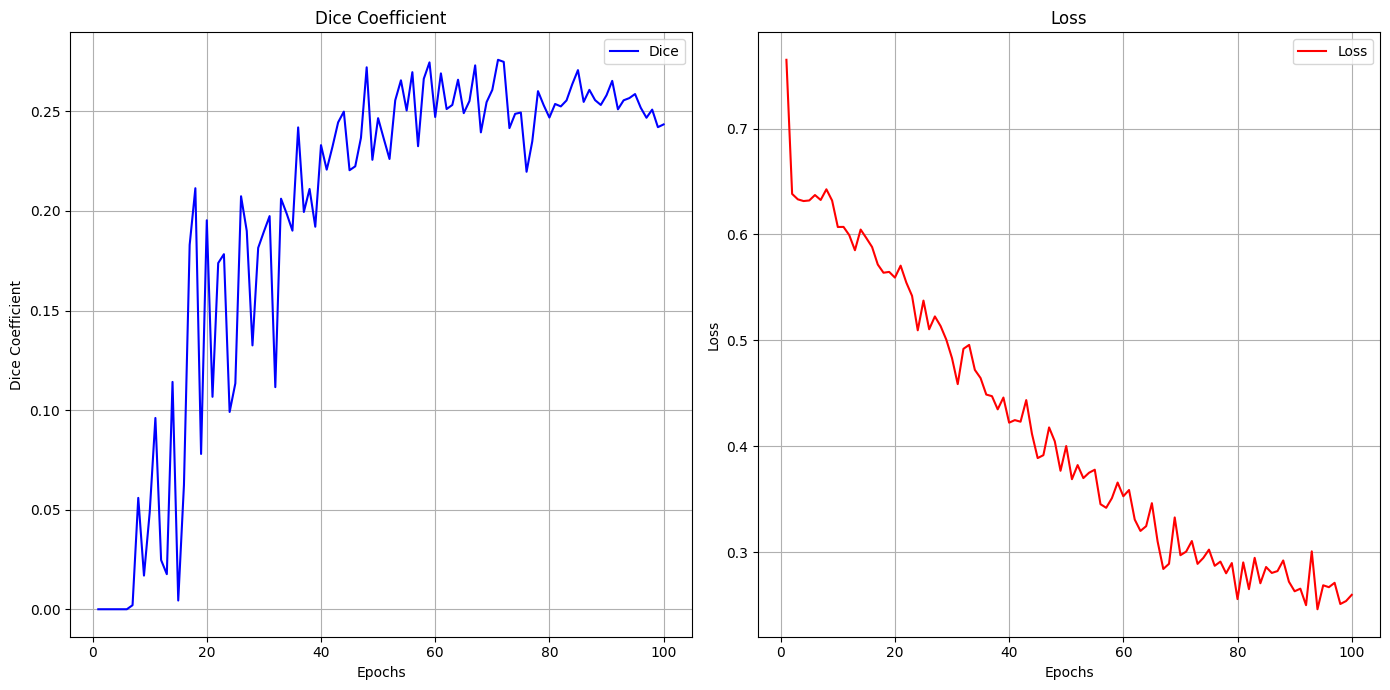

In [ ]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## Result using tversky + focal loss

In [ ]:
model_result = load_metrics("/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_1.json")

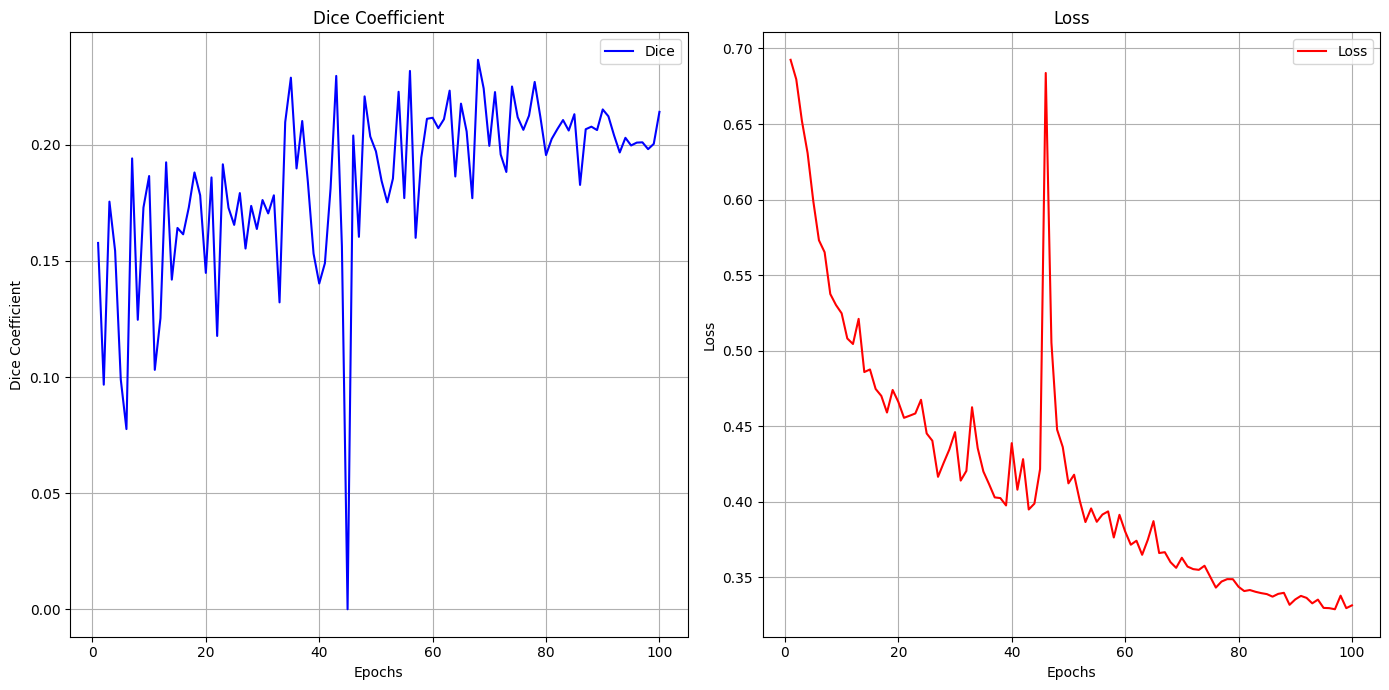

In [ ]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

##Result using tversky + BCE Loss

In [ ]:
model_result = load_metrics("/content/gdrive/MyDrive/KLTN/code/result_model_UNet3DWResNeXtCoT_tumor_2.json")

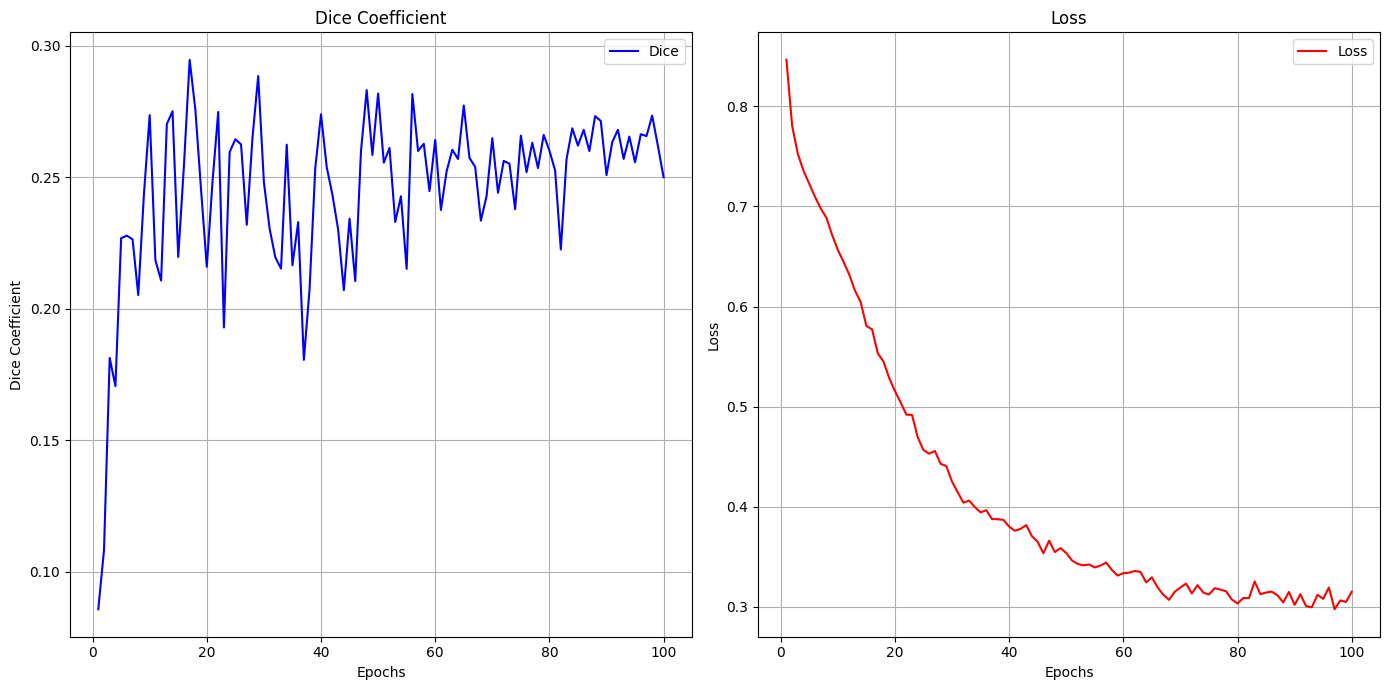

In [ ]:
epochs = np.arange(1, len(model_result["dice_tumor"]) + 1)
plt.figure(figsize=(14, 7))

# dice
plt.subplot(1, 2, 1)
plt.plot(epochs, model_result["dice_tumor"], label="Dice", color='blue')
plt.title("Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid()

# loss
plt.subplot(1, 2, 2)
plt.plot(epochs, model_result["loss"], label="Loss", color='red')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()